### 파생변수 + 타겟값 생성

In [67]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
import os
import pickle

# sklearn 라이브러리
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, f1_score, classification_report, confusion_matrix
)

# 선택적 라이브러리 (설치 여부 확인)
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost가 설치되지 않았습니다. XGBoost 모델은 건너뜁니다.")

try:
    import lightgbm as lgb
    HAS_LGB = True
except ImportError:
    HAS_LGB = False
    print("LightGBM이 설치되지 않았습니다. LightGBM 모델은 건너뜁니다.")

try:
    import catboost as cb
    HAS_CATBOOST = True
except ImportError:
    HAS_CATBOOST = False
    print("CatBoost가 설치되지 않았습니다. CatBoost 모델은 건너뜁니다.")

try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print("SHAP가 설치되지 않았습니다. SHAP 분석은 건너뜁니다.")

# 설정
warnings.filterwarnings('ignore')

# 한글 폰트 설정
# plt.rcParams['font.family'] ='Malgun Gothic' # 윈도우
plt.rcParams['font.family'] ='AppleGothic' # 맥
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료!")
print(f"XGBoost: {'✓' if HAS_XGB else '✗'}")
print(f"LightGBM: {'✓' if HAS_LGB else '✗'}")  
print(f"CatBoost: {'✓' if HAS_CATBOOST else '✗'}")
print(f"SHAP: {'✓' if HAS_SHAP else '✗'}")

# ========================================================================================
# 전체 코드 실행 순서 및 예시
# ========================================================================================

"""
📋 전체 실행 순서:

1. 데이터 로드 (make_features 함수 실행 후)
   - nanji, jungnang, seonam, tancheon 데이터프레임이 있어야 함

2. 전체 실험 실행:
   >>> results_df = run_stratified_comparison()

3. 결과 확인:
   >>> print(f"총 {len(results_df)}개 실험 완료")
   >>> successful = results_df[results_df['success'] == True]
   >>> print(f"성공: {len(successful)}개")

4. 저장된 파일 확인:
   >>> import os
   >>> for root, dirs, files in os.walk('../data/results'):
   ...     level = root.replace('../data/results', '').count(os.sep)
   ...     indent = ' ' * 2 * level
   ...     print(f'{indent}{os.path.basename(root)}/')
   ...     subindent = ' ' * 2 * (level + 1)
   ...     for file in files:
   ...         print(f'{subindent}{file}')

5. 단일 센터 테스트:
   >>> test_results = quick_stratified_test('nanji')
   >>> analyze_stratified_comparison(test_results)
"""

# ========================================================================================
# 주요 함수 사용법
# ========================================================================================

"""
🔧 주요 함수 설명:

1. run_stratified_comparison()
   - 전체 4개 센터의 Stratified vs 시계열 분할 비교 실험
   - 12개 모델 × 2가지 분할방법 × 4개 센터 = 96개 실험
   - 결과를 ../data/results/ 폴더에 체계적으로 저장

2. quick_stratified_test(center_name)
   - 단일 센터에 대한 빠른 테스트
   - center_name: 'nanji', 'jungnang', 'seonam', 'tancheon' 중 하나

3. analyze_stratified_comparison(results_df)  
   - 실험 결과에 대한 상세 분석 및 시각화
   - 분할 방법별 성능 비교, 모델별 성능 비교 등

4. comprehensive_model_analysis_with_save()
   - 최고 성능 모델에 대한 Feature Importance 및 SHAP 분석
   - 분석 결과를 자동으로 저장

5. save_results_comprehensive()
   - 다양한 유형의 결과를 적절한 폴더에 저장
   - 타임스탬프 포함하여 중복 방지
"""

# ========================================================================================
# 실험 결과 해석 가이드
# ========================================================================================

"""
📊 결과 해석 방법:

1. 회귀 성능 지표:
   - R² (결정계수): 0.7 이상이면 좋은 성능
   - MAE (평균 절대 오차): 실제 처리량 단위로 해석
   - MAPE (평균 절대 백분율 오차): 10% 이하면 우수

2. 분류 성능 지표:
   - Accuracy: 전체 정확도, 균형 데이터에서 의미있음
   - Macro F1: 클래스 불균형 고려한 주요 지표, 0.6 이상 목표
   - Extreme F1: 극값(등급 1,4) 분류 성능, 위험 상황 예측 능력

3. 분할 방법 비교:
   - Stratified가 temporal보다 높으면: 클래스 균형이 성능에 중요
   - Temporal이 더 높으면: 시간적 패턴이 더 중요
   - 차이가 적으면: 두 방법 모두 적절

4. Feature Importance:
   - 상위 10개 피처가 전체 중요도의 80% 이상 차지하면 주요 변수 식별됨
   - SHAP 분석으로 각 피처의 기여도 방향성 확인 가능
"""

print("\n🎯 실험 목표:")
print("- 하수처리장 처리량 예측 및 등급 분류 모델 성능 최적화")
print("- 데이터 분할 방법이 모델 성능에 미치는 영향 분석") 
print("- 센터별 최적 모델 및 중요 변수 식별")
print("- 실제 운영환경에 적용 가능한 모델 추천")

print(f"\n📈 기대 효과:")
print("- 처리량 예측 정확도 향상으로 운영 효율성 증대")
print("- 등급 예측을 통한 사전 대응 체계 구축") 
print("- 중요 변수 식별로 모니터링 포인트 최적화")
print("- 센터별 맞춤형 예측 모델 운영 가능")

라이브러리 로드 완료!
XGBoost: ✓
LightGBM: ✓
CatBoost: ✓
SHAP: ✓

🎯 실험 목표:
- 하수처리장 처리량 예측 및 등급 분류 모델 성능 최적화
- 데이터 분할 방법이 모델 성능에 미치는 영향 분석
- 센터별 최적 모델 및 중요 변수 식별
- 실제 운영환경에 적용 가능한 모델 추천

📈 기대 효과:
- 처리량 예측 정확도 향상으로 운영 효율성 증대
- 등급 예측을 통한 사전 대응 체계 구축
- 중요 변수 식별로 모니터링 포인트 최적화
- 센터별 맞춤형 예측 모델 운영 가능


In [68]:
nanji = pd.read_csv('../data/processed/center_season/nanji/난지_merged.csv', encoding='utf-8-sig')
jungnang = pd.read_csv('../data/processed/center_season/jungnang/중랑_merged.csv', encoding='utf-8-sig')
seonam = pd.read_csv('../data/processed/center_season/seonam/서남_merged.csv', encoding='utf-8-sig')
tancheon = pd.read_csv('../data/processed/center_season/tancheon/탄천_merged.csv', encoding='utf-8-sig')

print(nanji.info())
print(jungnang.info())
print(seonam.info())
print(tancheon.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3103 entries, 0 to 3102
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   날짜             3103 non-null   object 
 1   요일             3103 non-null   object 
 2   공휴일            3103 non-null   int64  
 3   목욕장업           3103 non-null   int64  
 4   세탁업            3103 non-null   int64  
 5   수영장업           3103 non-null   int64  
 6   종합체육시설업        3103 non-null   int64  
 7   체력단련장업         3103 non-null   int64  
 8   하천             3103 non-null   float64
 9   생활인구           3103 non-null   float64
 10  불쾌지수(DI)       3103 non-null   float64
 11  불쾌지수등급         3103 non-null   object 
 12  일_일강수량(mm)     3103 non-null   float64
 13  일_최저기온(°C)     3103 non-null   float64
 14  일_평균기온(°C)     3103 non-null   float64
 15  일_최고기온(°C)     3103 non-null   float64
 16  일_평균풍속(m/s)    3103 non-null   float64
 17  일_최대순간풍속(m/s)  3103 non-null   float64
 18  최저습도(%) 

In [69]:
def make_features(df):
    df = df.copy()  # 원본 보존
    
    # 날짜 정리 및 정렬
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values('날짜').reset_index(drop=True)

    # 달/요일 숫자
    df['월'] = df['날짜'].dt.month
    df['요일'] = df['날짜'].dt.weekday  # 0=월, ... , 6=일

    # 계절/불쾌지수등급 숫자 매핑
    season_map = {'봄': 0, '여름': 1, '가을': 2, '겨울': 3}
    discomfort_map = {'쾌적': 0, '약간 불쾌': 1, '불쾌': 2, '매우 불쾌': 3, '극심한 불쾌': 4}
    df['계절'] = df['계절'].map(season_map).astype('Int64')
    df['불쾌지수등급'] = df['불쾌지수등급'].map(discomfort_map).astype('Int64')

    # 강수량 시차 피처
    df['강수량_1일전'] = df['일_일강수량(mm)'].shift(1)
    df['강수량_2일전'] = df['일_일강수량(mm)'].shift(2)
    df['강수량_1일_누적'] = df['일_일강수량(mm)'].rolling(1, min_periods=1).sum()
    df['강수량_2일_누적'] = df['일_일강수량(mm)'].rolling(2, min_periods=1).sum()
    df['강수량_3일_누적'] = df['일_일강수량(mm)'].rolling(3, min_periods=1).sum()
    df['강수량_5일_누적'] = df['일_일강수량(mm)'].rolling(5, min_periods=1).sum()
    df['강수량_7일_누적'] = df['일_일강수량(mm)'].rolling(7, min_periods=1).sum()

    df['일교차']   = df['일_최고기온(°C)'] - df['일_최저기온(°C)'] 
    df['폭우_여부'] = (df['일_일강수량(mm)'] >= 80).astype(int)
    
    # 체감온도 계산(온도/풍속/습도 기반)
    # 사용 컬럼명: '일_평균기온(°C)', '일_평균풍속(m/s)', '평균습도(%)'
    # 숫자형 강제(문자 섞여도 안전)
    if '일_평균기온(°C)' in df.columns:
        T = pd.to_numeric(df['일_평균기온(°C)'], errors='coerce')
    else:
        T = pd.Series(np.nan, index=df.index)
    if '일_평균풍속(m/s)' in df.columns:
        V_ms = pd.to_numeric(df['일_평균풍속(m/s)'], errors='coerce')
    else:
        V_ms = pd.Series(np.nan, index=df.index)
    if '평균습도(%)' in df.columns:
        RH = pd.to_numeric(df['평균습도(%)'], errors='coerce')
    else:
        RH = pd.Series(np.nan, index=df.index)

    # 윈드칠(추울 때 바람 영향) — 단위: °C, 공식은 km/h 기준
    V_kmh = V_ms * 3.6
    wct_raw = 13.12 + 0.6215*T - 11.37*np.power(V_kmh, 0.16) + 0.3965*T*np.power(V_kmh, 0.16)
    wc_valid = (T <= 10.0) & (V_kmh >= 4.8)  # 유효 범위: T ≤ 10°C, v ≥ 4.8 km/h(≈1.34 m/s)
    wct = T.copy()             # 기본은 실제 기온
    wct[wc_valid] = wct_raw[wc_valid]

    # 열지수(더울 때 습도 영향) — NOAA 공식(화씨) 활용, 최종은 °C
    # 유효 권장 범위: T ≥ 26.7°C & RH ≥ 40%
    T_f = T * 9/5 + 32
    HI_f = (-42.379 + 2.04901523*T_f + 10.14333127*RH
            - 0.22475541*T_f*RH - 0.00683783*T_f**2 - 0.05481717*RH**2
            + 0.00122874*T_f**2*RH + 0.00085282*T_f*RH**2
            - 0.00000199*T_f**2*RH**2)
    # 저습 보정
    mask_low = (RH < 13) & (T_f >= 80) & (T_f <= 112)
    adj_low = ((13 - RH)/4) * np.sqrt((17 - np.abs(T_f - 95))/17)
    HI_f = HI_f.where(~mask_low, HI_f - adj_low)
    # 고습 보정
    mask_high = (RH > 85) & (T_f >= 80) & (T_f <= 87)
    adj_high = ((RH - 85)/10) * ((87 - T_f)/5)
    HI_f = HI_f.where(~mask_high, HI_f + adj_high)
    hi_valid = (T_f >= 80) & (RH >= 40)
    HI_c = (HI_f - 32) * 5/9
    hi = T.copy()
    hi[hi_valid] = HI_c[hi_valid]

    # Steadman Apparent Temperature(연속 지표, 전 구간)
    # AT = T + 0.33*e - 0.70*v - 4.00
    # e(hPa) = RH/100 * 6.105 * exp(17.27*T/(237.7+T)), v(m/s)
    e = (RH/100.0) * 6.105 * np.exp(17.27*T/(237.7 + T))
    at = T + 0.33*e - 0.70*V_ms - 4.00

    # 최종 체감온도 선택(윈드칠 > 열지수 > 스테드먼)
    apparent = at.copy()
    apparent[hi_valid] = hi[hi_valid]
    apparent[wc_valid] = wct[wc_valid]

    # 컬럼 추가
    df['윈드칠(°C)'] = wct
    df['열지수(°C)'] = hi
    df['스테드먼체감온도(°C)'] = at
    df['체감온도(°C)'] = apparent
    
    # 중간 산출 컬럼 정리
    df = df.drop(['윈드칠(°C)', '열지수(°C)', '스테드먼체감온도(°C)'], axis=1)

    # 회귀 타깃(1일/2일 후 합계)
    df['합계_1일후'] = df['합계'].shift(-1)
    df['합계_2일후'] = df['합계'].shift(-2)
    
    # ------------------------------
    # 분류 타겟(합계 기준, 백분위수 컷 계산)
    # 0~15%:1, 15~70%:2, 70~90%:3, 90~100%:4
    # ------------------------------
    # 퍼센타일 기준값 계산 (결측 제거)
    q = df['합계'].dropna().quantile([0.15, 0.70, 0.90])
    q15, q70, q90 = float(q.loc[0.15]), float(q.loc[0.70]), float(q.loc[0.90])

    # 경계 포함 규칙: x < q15 → 1, q15 ≤ x < q70 → 2, q70 ≤ x < q90 → 3, x ≥ q90 → 4
    def categorize(x):
        if pd.isna(x):
            return np.nan
        if x < q15:
            return 0
        elif x < q70:
            return 1
        elif x < q90:
            return 2
        else:
            return 3

    df['등급'] = df['합계'].apply(categorize)
    df['등급_1일후'] = df['등급'].shift(-1).astype('Int64')
    df['등급_2일후'] = df['등급'].shift(-2).astype('Int64')

    # 컷 기준 저장 (숫자값만, 나중 해석용)
    df.attrs['cutoffs'] = {"q15": q15, "q70": q70, "q90": q90}

    # 결측 제거 및 리셋
    df = df.dropna().reset_index(drop=True)
    
     # 난지/서남 6월 데이터 없음 → 0으로 채워진 구간 제거
    df = df[df["날짜"] < "2025-06-01"]
    
    return df

nanji    = make_features(nanji)
jungnang = make_features(jungnang)
seonam   = make_features(seonam)
tancheon = make_features(tancheon)

# 컷 확인
print(nanji.attrs['cutoffs'])  # {'q15': ..., 'q70': ..., 'q90': ...}
print(jungnang.attrs['cutoffs'])
print(seonam.attrs['cutoffs'])
print(tancheon.attrs['cutoffs'])

{'q15': 513466.485, 'q70': 596351.4, 'q90': 776100.8000000002}
{'q15': 1141432.0, 'q70': 1285042.4, 'q90': 1522312.6}
{'q15': 1411120.2, 'q70': 1570617.7999999998, 'q90': 1909166.4000000001}
{'q15': 661427.1, 'q70': 759528.7999999999, 'q90': 874285.6}


In [70]:
print(nanji.shape, nanji.columns)
print(jungnang.shape, jungnang.columns)
print(seonam.shape, seonam.columns)
print(tancheon.shape, tancheon.columns)

(3071, 44) Index(['날짜', '요일', '공휴일', '목욕장업', '세탁업', '수영장업', '종합체육시설업', '체력단련장업', '하천',
       '생활인구', '불쾌지수(DI)', '불쾌지수등급', '일_일강수량(mm)', '일_최저기온(°C)', '일_평균기온(°C)',
       '일_최고기온(°C)', '일_평균풍속(m/s)', '일_최대순간풍속(m/s)', '최저습도(%)', '평균습도(%)',
       '최고습도(%)', '습도표준편차', '1처리장', '2처리장', '정화조', '중계펌프장', '합계', '계절', '월',
       '강수량_1일전', '강수량_2일전', '강수량_1일_누적', '강수량_2일_누적', '강수량_3일_누적',
       '강수량_5일_누적', '강수량_7일_누적', '일교차', '폭우_여부', '체감온도(°C)', '합계_1일후',
       '합계_2일후', '등급', '등급_1일후', '등급_2일후'],
      dtype='object')
(3071, 44) Index(['날짜', '요일', '공휴일', '목욕장업', '세탁업', '수영장업', '종합체육시설업', '체력단련장업', '하천',
       '생활인구', '불쾌지수(DI)', '불쾌지수등급', '일_일강수량(mm)', '일_최저기온(°C)', '일_평균기온(°C)',
       '일_최고기온(°C)', '일_평균풍속(m/s)', '일_최대순간풍속(m/s)', '최저습도(%)', '평균습도(%)',
       '최고습도(%)', '습도표준편차', '1처리장', '2처리장', '3처리장', '4처리장', '합계', '계절', '월',
       '강수량_1일전', '강수량_2일전', '강수량_1일_누적', '강수량_2일_누적', '강수량_3일_누적',
       '강수량_5일_누적', '강수량_7일_누적', '일교차', '폭우_여부', '체감온도(°C)', '합계_1일후',
       '합계_2일후', '등급

### 센터별 분포 확인

In [71]:
def analyze_target_distribution(df, target_col='합계', center_name=''):
    """타깃 변수의 분포를 종합 분석"""
    
    series = pd.to_numeric(df[target_col], errors='coerce').dropna()
    print(f"=== {center_name} {target_col} 분포 분석 ===")
    print(f"데이터 개수: {len(series)}")
    print(f"결측치: {df[target_col].isna().sum()}개")
    
    # 기본 통계량
    print(f"\n기본 통계량:")
    print(f"  평균: {series.mean():.1f}")
    print(f"  표준편차: {series.std():.1f}")
    print(f"  중앙값: {series.median():.1f}")
    print(f"  최솟값: {series.min():.1f}")
    print(f"  최댓값: {series.max():.1f}")
    print(f"  범위: {series.max() - series.min():.1f}")
    
    # 분위수 정보
    quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    print(f"\n분위수:")
    for q in quantiles:
        print(f"  {q*100:2.0f}%: {series.quantile(q):8.1f}")
    
    # 정규성 검정
    shapiro_stat, shapiro_p = stats.shapiro(series.sample(min(5000, len(series))))
    print(f"\n정규성 검정 (Shapiro-Wilk):")
    print(f"  통계량: {shapiro_stat:.4f}")
    print(f"  p-값: {shapiro_p:.2e}")
    print(f"  정규분포 여부: {'아니오' if shapiro_p < 0.05 else '예'}")
    
    # 왜도와 첨도
    skewness = stats.skew(series)
    kurtosis = stats.kurtosis(series)
    print(f"\n분포 형태:")
    print(f"  왜도 (Skewness): {skewness:.3f} ({'오른쪽 치우침' if skewness > 0.5 else '왼쪽 치우침' if skewness < -0.5 else '대칭적'})")
    print(f"  첨도 (Kurtosis): {kurtosis:.3f} ({'뾰족함' if kurtosis > 0 else '평평함'})")
    
    # 이상치 분석
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    outliers = series[(series < lower_fence) | (series > upper_fence)]
    
    print(f"\n이상치 분석 (IQR 방법):")
    print(f"  IQR: {IQR:.1f}")
    print(f"  하한: {lower_fence:.1f}")
    print(f"  상한: {upper_fence:.1f}")
    print(f"  이상치 개수: {len(outliers)}개 ({len(outliers)/len(series)*100:.1f}%)")
    if len(outliers) > 0:
        print(f"  이상치 범위: {outliers.min():.1f} ~ {outliers.max():.1f}")
    
    return {
        'series': series,
        'stats': {
            'mean': series.mean(),
            'std': series.std(),
            'median': series.median(),
            'min': series.min(),
            'max': series.max(),
            'skewness': skewness,
            'kurtosis': kurtosis,
            'outlier_count': len(outliers),
            'outlier_ratio': len(outliers)/len(series)
        }
    }

def plot_target_distribution(df, target_col='합계', center_name=''):
    """타깃 변수 분포 시각화"""
    
    series = pd.to_numeric(df[target_col], errors='coerce').dropna()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{center_name} {target_col} 분포 분석', fontsize=16)
    
    # 1. 히스토그램
    axes[0,0].hist(series, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(series.mean(), color='red', linestyle='--', label=f'평균: {series.mean():.1f}')
    axes[0,0].axvline(series.median(), color='orange', linestyle='--', label=f'중앙값: {series.median():.1f}')
    axes[0,0].set_title('히스토그램')
    axes[0,0].set_xlabel(target_col)
    axes[0,0].set_ylabel('빈도')
    axes[0,0].legend()
    
    # 2. 박스플롯
    axes[0,1].boxplot(series, patch_artist=True)
    axes[0,1].set_title('박스플롯')
    axes[0,1].set_ylabel(target_col)
    
    # 3. Q-Q plot (정규분포와 비교)
    stats.probplot(series, dist="norm", plot=axes[0,2])
    axes[0,2].set_title('Q-Q Plot (정규분포 비교)')
    
    # 4. 시계열 플롯
    if '날짜' in df.columns:
        df_plot = df.copy()
        df_plot['날짜'] = pd.to_datetime(df_plot['날짜'])
        df_plot = df_plot.sort_values('날짜')
        axes[1,0].plot(df_plot['날짜'], df_plot[target_col], alpha=0.7)
        axes[1,0].set_title('시계열 변화')
        axes[1,0].set_xlabel('날짜')
        axes[1,0].set_ylabel(target_col)
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # 5. 밀도 플롯
    axes[1,1].hist(series, bins=50, density=True, alpha=0.7, color='lightgreen', label='실제 분포')
    # 정규분포 오버레이
    x = np.linspace(series.min(), series.max(), 100)
    normal_curve = stats.norm.pdf(x, series.mean(), series.std())
    axes[1,1].plot(x, normal_curve, 'r-', label='정규분포')
    axes[1,1].set_title('밀도 분포')
    axes[1,1].set_xlabel(target_col)
    axes[1,1].set_ylabel('밀도')
    axes[1,1].legend()
    
    # 6. 분위수별 구간 시각화
    quantiles = np.arange(0, 1.1, 0.1)
    q_values = [series.quantile(q) for q in quantiles]
    axes[1,2].plot(quantiles*100, q_values, 'bo-')
    axes[1,2].set_title('분위수 곡선')
    axes[1,2].set_xlabel('백분위수 (%)')
    axes[1,2].set_ylabel(target_col)
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def analyze_classification_difficulty(df, target_col='합계', q_range=range(3, 16), center_name=''):
    """여러 클래스 수에 대한 분류 난이도 분석"""
    
    series = pd.to_numeric(df[target_col], errors='coerce').dropna()
    
    results = []
    
    for q in q_range:
        try:
            # 분위수 기반 분할
            qcut = pd.qcut(series, q=q, duplicates='drop')
            
            # 실제 생성된 구간 수 (duplicates='drop' 때문에 q보다 작을 수 있음)
            actual_bins = len(qcut.cat.categories)
            
            # 클래스 분포
            class_counts = qcut.value_counts().sort_index()
            
            # 균형도 지표들
            min_count = class_counts.min()
            max_count = class_counts.max()
            balance_ratio = min_count / max_count
            cv = class_counts.std() / class_counts.mean()  # 변동계수
            
            # 엔트로피 (높을수록 균등분포)
            probs = class_counts / class_counts.sum()
            entropy = -np.sum(probs * np.log2(probs + 1e-10))
            max_entropy = np.log2(actual_bins)
            normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
            
            results.append({
                'q_requested': q,
                'q_actual': actual_bins,
                'min_samples': min_count,
                'max_samples': max_count,
                'balance_ratio': balance_ratio,
                'cv': cv,
                'entropy': entropy,
                'normalized_entropy': normalized_entropy,
                'theoretical_accuracy': 1.0 / actual_bins  # 랜덤 추측 정확도
            })
            
        except Exception as e:
            print(f"q={q} 분석 실패: {e}")
    
    results_df = pd.DataFrame(results)
    
    print(f"\n=== {center_name} 클래스 수별 분류 난이도 ===")
    print("q: 요청 클래스 수, actual: 실제 클래스 수, balance: 균형도(높을수록 좋음)")
    print("cv: 변동계수(낮을수록 균등), entropy: 정규화 엔트로피(높을수록 균등)")
    print("theor_acc: 이론적 랜덤 정확도")
    
    display_df = results_df[['q_requested', 'q_actual', 'balance_ratio', 'cv', 'normalized_entropy', 'theoretical_accuracy']].round(3)
    display_df.columns = ['q', 'actual', 'balance', 'cv', 'entropy', 'theor_acc']
    print(display_df.to_string(index=False))
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{center_name} 클래스 수별 분류 난이도 분석')
    
    # 균형도
    axes[0,0].plot(results_df['q_requested'], results_df['balance_ratio'], 'bo-')
    axes[0,0].set_title('클래스 균형도 (높을수록 좋음)')
    axes[0,0].set_xlabel('클래스 수')
    axes[0,0].set_ylabel('균형도 (min/max)')
    axes[0,0].grid(True, alpha=0.3)
    
    # 변동계수
    axes[0,1].plot(results_df['q_requested'], results_df['cv'], 'ro-')
    axes[0,1].set_title('변동계수 (낮을수록 균등)')
    axes[0,1].set_xlabel('클래스 수')
    axes[0,1].set_ylabel('변동계수')
    axes[0,1].grid(True, alpha=0.3)
    
    # 정규화 엔트로피
    axes[1,0].plot(results_df['q_requested'], results_df['normalized_entropy'], 'go-')
    axes[1,0].set_title('정규화 엔트로피 (높을수록 균등)')
    axes[1,0].set_xlabel('클래스 수')
    axes[1,0].set_ylabel('정규화 엔트로피')
    axes[1,0].grid(True, alpha=0.3)
    
    # 이론적 정확도
    axes[1,1].plot(results_df['q_requested'], results_df['theoretical_accuracy']*100, 'mo-')
    axes[1,1].set_title('이론적 랜덤 정확도')
    axes[1,1].set_xlabel('클래스 수')
    axes[1,1].set_ylabel('정확도 (%)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 추천 클래스 수
    optimal_idx = results_df['normalized_entropy'].idxmax()
    optimal_q = results_df.loc[optimal_idx, 'q_requested']
    print(f"\n추천 클래스 수: {optimal_q}개 (엔트로피 기준)")
    
    return results_df

def comprehensive_target_analysis(centers_dict):
    """모든 센터의 타깃 변수 종합 분석"""
    
    all_stats = {}
    
    for center_name, df in centers_dict.items():
        print(f"\n{'='*60}")
        
        # 파생변수 생성 (합계_1일후 포함)
        # df_processed = make_features(df)  #위에서 이미 실행함
         
        # 원본 합계 분석
        print(f"[{center_name}] 원본 합계")
        stats_original = analyze_target_distribution(df, '합계', center_name)
        
        # 1일 후 합계 분석
        print(f"\n[{center_name}] 1일 후 합계 (예측 타깃)")
        stats_1day = analyze_target_distribution(df, '합계_1일후', center_name)
        
        all_stats[center_name] = {
            'original': stats_original['stats'],
            '1day_after': stats_1day['stats']
        }
        
        # 분포 시각화
        plot_target_distribution(df, '합계', f'{center_name} 원본')
        plot_target_distribution(df, '합계_1일후', f'{center_name} 1일후')
        
        # 분류 난이도 분석
        analyze_classification_difficulty(df, '합계_1일후', range(3, 12), f'{center_name} 1일후')
    
    # 센터 간 비교
    print(f"\n{'='*60}")
    print("=== 센터별 비교 요약 ===")
    
    comparison_df = pd.DataFrame({
        center: stats['1day_after'] 
        for center, stats in all_stats.items()
    }).T.round(2)
    
    print(comparison_df)
    
    return all_stats

# 사용 예시
if __name__ == "__main__":
    print("=== 타깃 변수 분포 분석 도구 ===")
    print("사용법:")
    print("1. 단일 센터 분석:")
    print("   stats = analyze_target_distribution(nanji, '합계', 'nanji')")
    print("   plot_target_distribution(nanji, '합계', 'nanji')")
    print("   difficulty = analyze_classification_difficulty(nanji, '합계', range(3,12), 'nanji')")
    print("2. 전체 센터 종합 분석:")
    print("   all_stats = comprehensive_target_analysis(centers_dict)")

=== 타깃 변수 분포 분석 도구 ===
사용법:
1. 단일 센터 분석:
   stats = analyze_target_distribution(nanji, '합계', 'nanji')
   plot_target_distribution(nanji, '합계', 'nanji')
   difficulty = analyze_classification_difficulty(nanji, '합계', range(3,12), 'nanji')
2. 전체 센터 종합 분석:
   all_stats = comprehensive_target_analysis(centers_dict)



[nanji] 원본 합계
=== nanji 합계 분포 분석 ===
데이터 개수: 3071
결측치: 0개

기본 통계량:
  평균: 603919.3
  표준편차: 133017.6
  중앙값: 556452.0
  최솟값: 442332.8
  최댓값: 1381444.0
  범위: 939111.2

분위수:
   5%: 498752.4
  10%: 507749.0
  25%: 527229.0
  50%: 556452.0
  75%: 617096.5
  90%: 778084.0
  95%: 893091.5
  99%: 1145005.8

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7151
  p-값: 3.24e-58
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.423 (오른쪽 치우침)
  첨도 (Kurtosis): 6.588 (뾰족함)

이상치 분석 (IQR 방법):
  IQR: 89867.5
  하한: 392427.8
  상한: 751897.8
  이상치 개수: 354개 (11.5%)
  이상치 범위: 752024.0 ~ 1381444.0

[nanji] 1일 후 합계 (예측 타깃)
=== nanji 합계_1일후 분포 분석 ===
데이터 개수: 3071
결측치: 0개

기본 통계량:
  평균: 603760.2
  표준편차: 133447.1
  중앙값: 556452.0
  최솟값: 0.0
  최댓값: 1381444.0
  범위: 1381444.0

분위수:
   5%: 498752.4
  10%: 507749.0
  25%: 527229.0
  50%: 556452.0
  75%: 617096.5
  90%: 778084.0
  95%: 893091.5
  99%: 1145005.8

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7178
  p-값: 4.87e-58
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.374 (오른쪽 치우침)
  첨도 (Kurtosis): 6.613 (뾰족

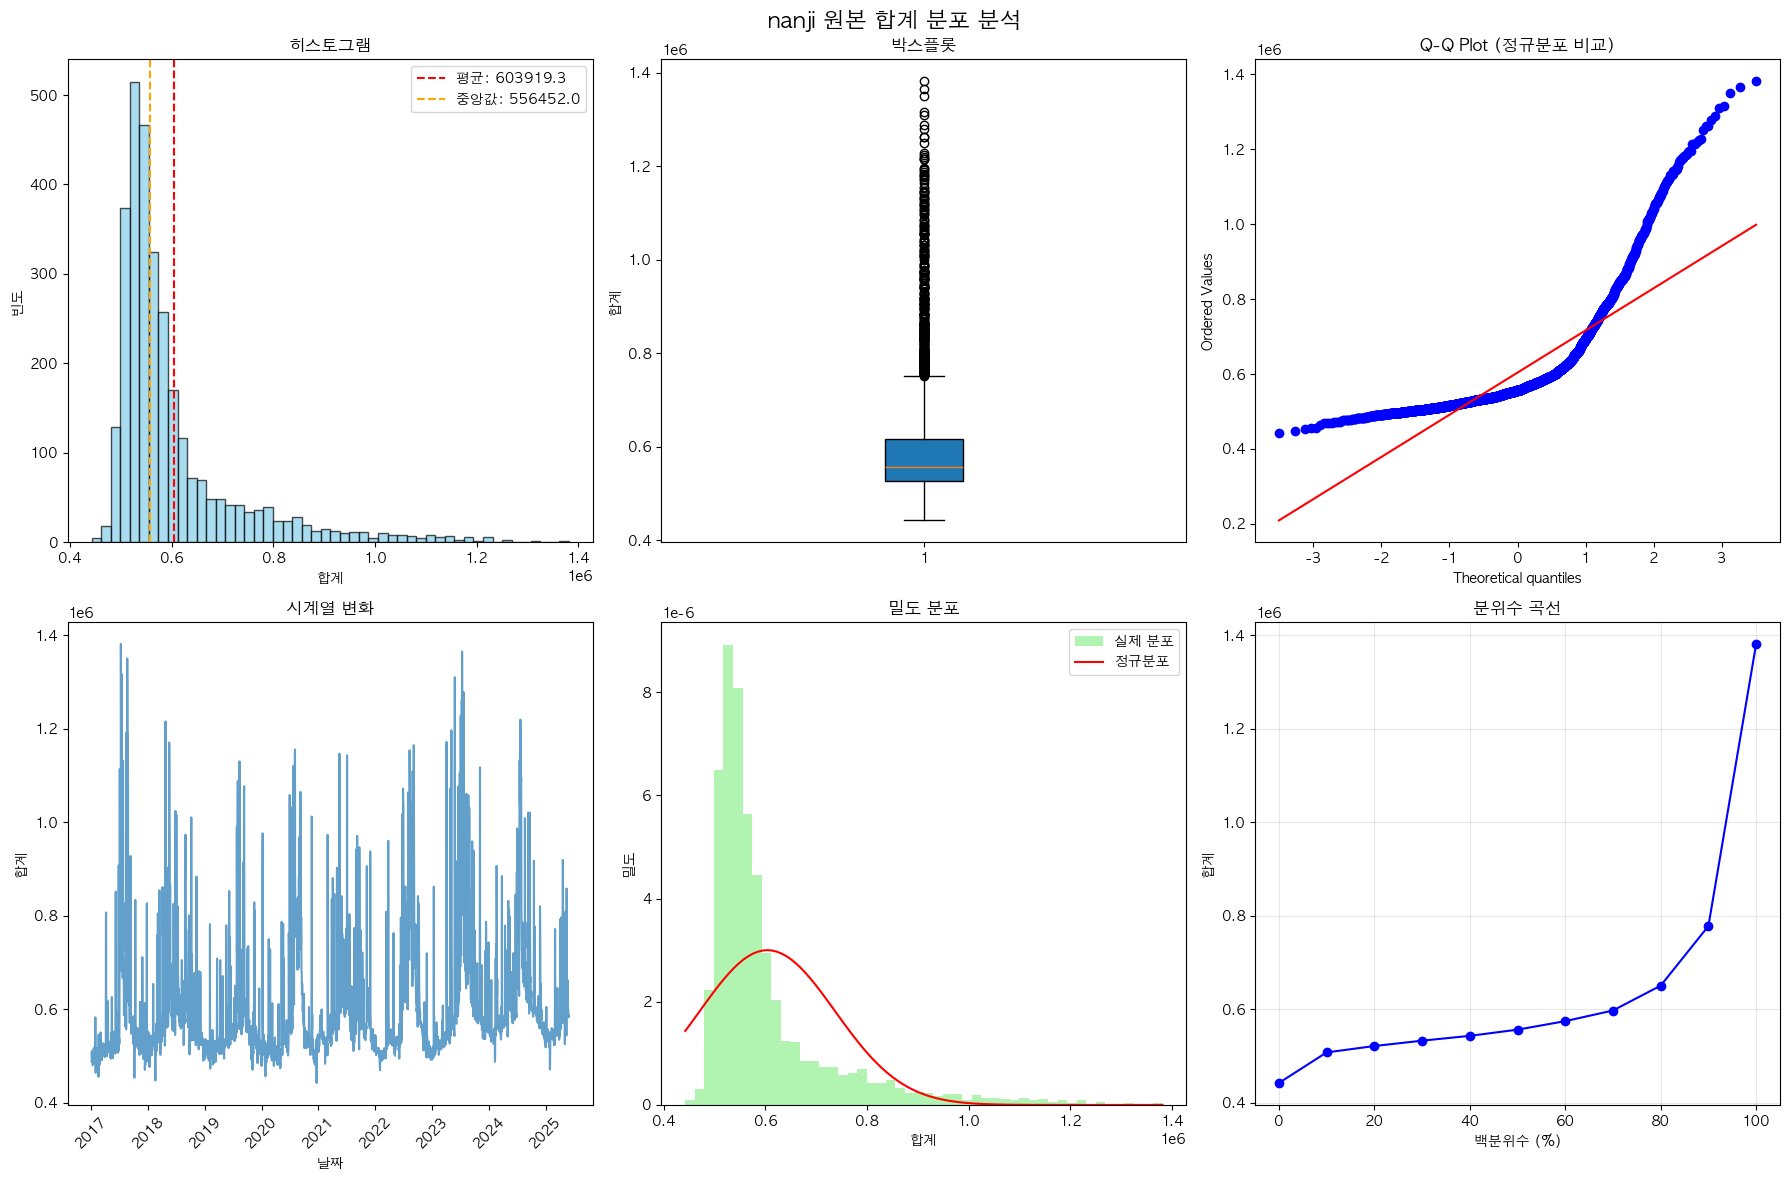

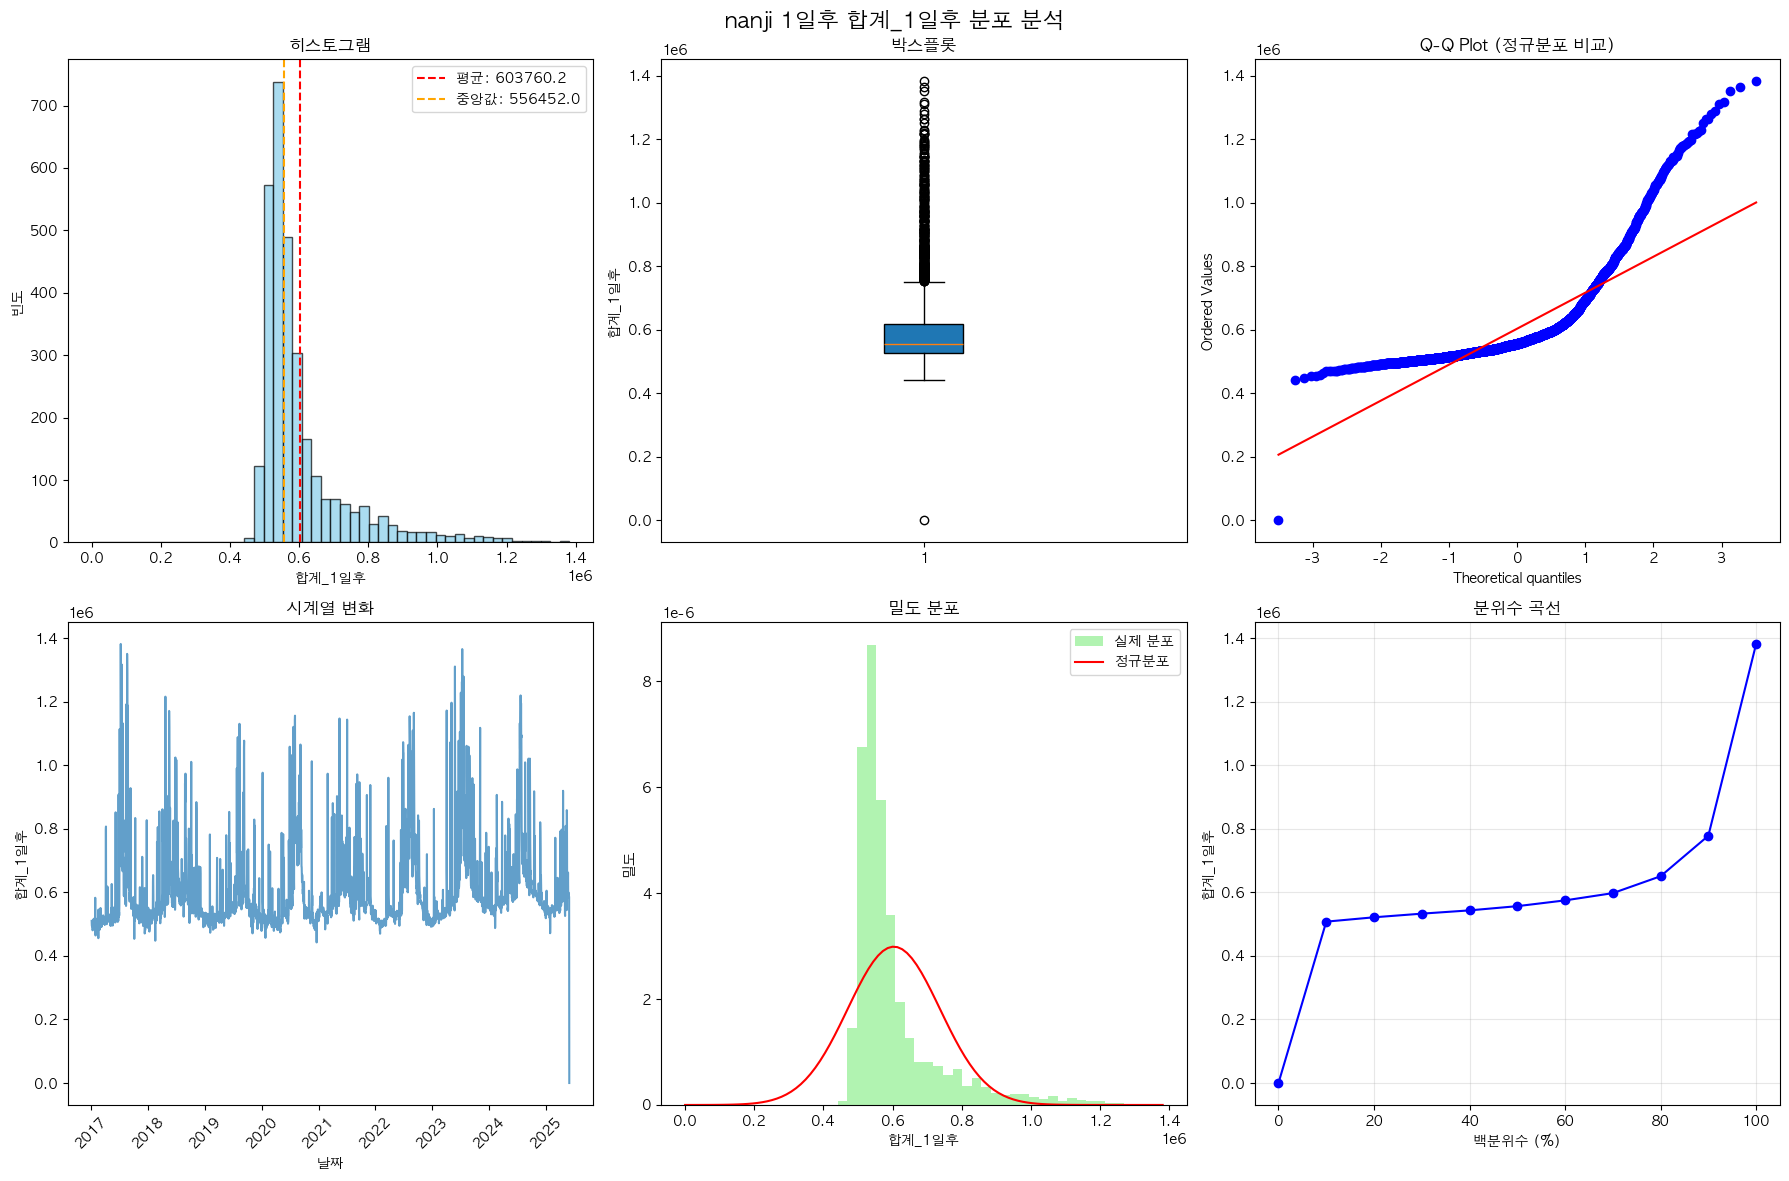


=== nanji 1일후 클래스 수별 분류 난이도 ===
q: 요청 클래스 수, actual: 실제 클래스 수, balance: 균형도(높을수록 좋음)
cv: 변동계수(낮을수록 균등), entropy: 정규화 엔트로피(높을수록 균등)
theor_acc: 이론적 랜덤 정확도
 q  actual  balance    cv  entropy  theor_acc
 3       3    0.999 0.001      1.0      0.333
 4       4    0.999 0.001      1.0      0.250
 5       5    0.998 0.001      1.0      0.200
 6       6    0.998 0.001      1.0      0.167
 7       7    0.998 0.001      1.0      0.143
 8       8    0.997 0.001      1.0      0.125
 9       9    0.997 0.001      1.0      0.111
10      10    0.997 0.001      1.0      0.100
11      11    0.996 0.001      1.0      0.091


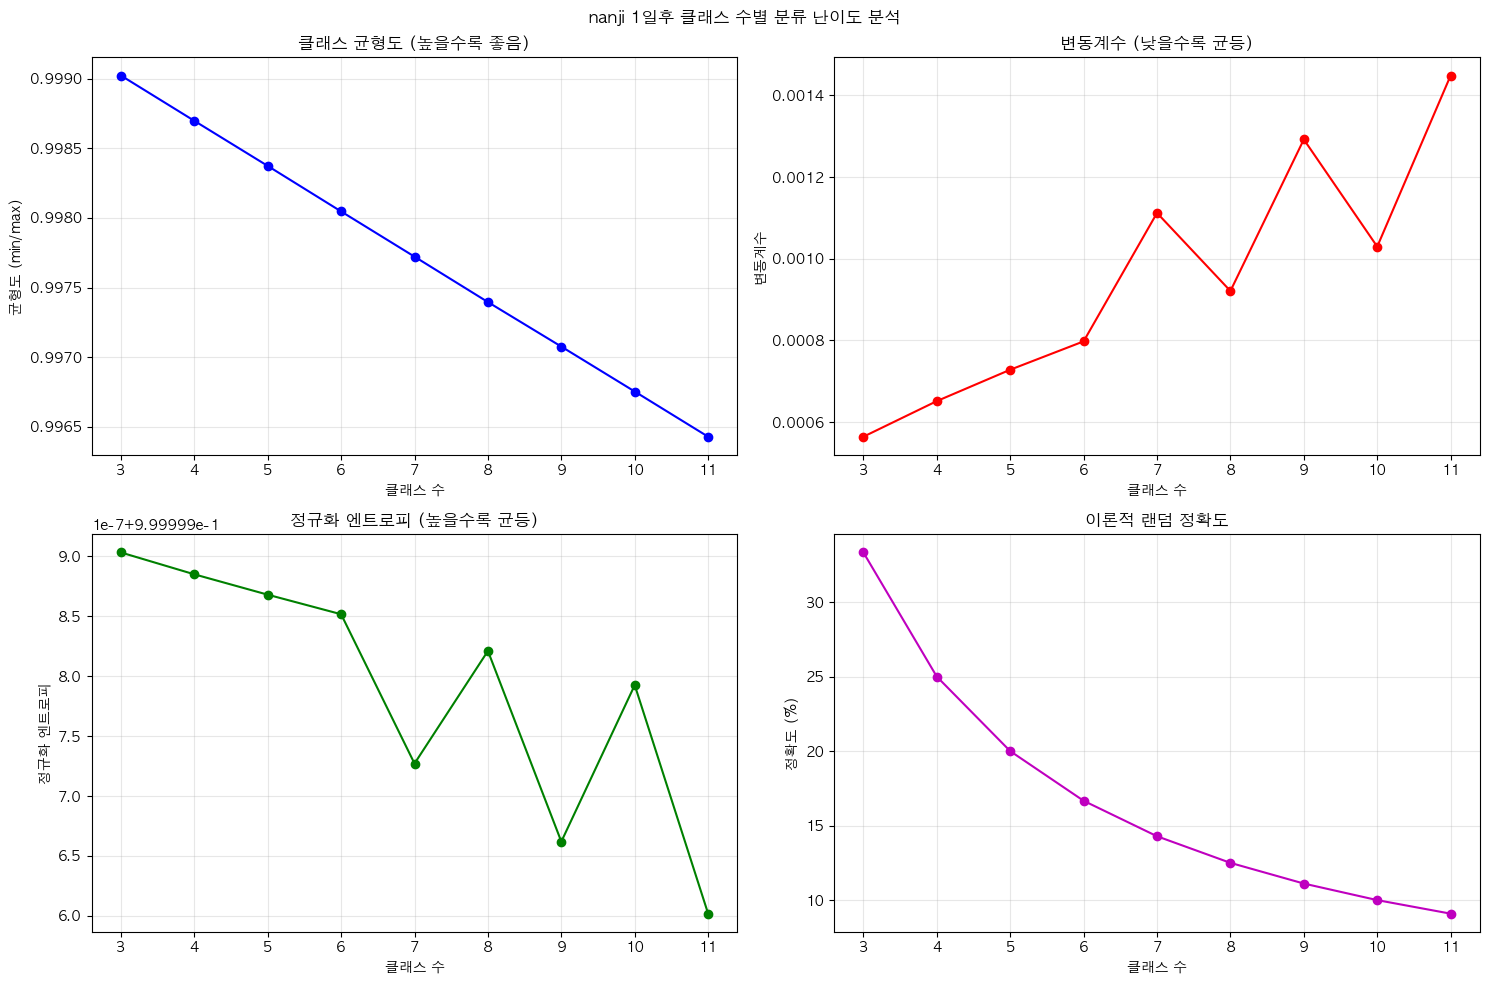


추천 클래스 수: 3개 (엔트로피 기준)

[jungnang] 원본 합계
=== jungnang 합계 분포 분석 ===
데이터 개수: 3071
결측치: 0개

기본 통계량:
  평균: 1278604.8
  표준편차: 197496.7
  중앙값: 1222238.0
  최솟값: 101840.0
  최댓값: 2745792.0
  범위: 2643952.0

분위수:
   5%: 1093100.5
  10%: 1122814.0
  25%: 1169116.5
  50%: 1222238.0
  75%: 1315782.5
  90%: 1522502.0
  95%: 1689342.0
  99%: 1994609.5

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7786
  p-값: 9.41e-54
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.305 (오른쪽 치우침)
  첨도 (Kurtosis): 8.691 (뾰족함)

이상치 분석 (IQR 방법):
  IQR: 146666.0
  하한: 949117.5
  상한: 1535781.5
  이상치 개수: 292개 (9.5%)
  이상치 범위: 101840.0 ~ 2745792.0

[jungnang] 1일 후 합계 (예측 타깃)
=== jungnang 합계_1일후 분포 분석 ===
데이터 개수: 3071
결측치: 0개

기본 통계량:
  평균: 1278601.9
  표준편차: 197497.6
  중앙값: 1222176.0
  최솟값: 101840.0
  최댓값: 2745792.0
  범위: 2643952.0

분위수:
   5%: 1093100.5
  10%: 1122814.0
  25%: 1169116.5
  50%: 1222176.0
  75%: 1315782.5
  90%: 1522502.0
  95%: 1689342.0
  99%: 1994609.5

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7786
  p-값: 9.40e-54
  정규분포 여부: 아니오

분포 형태

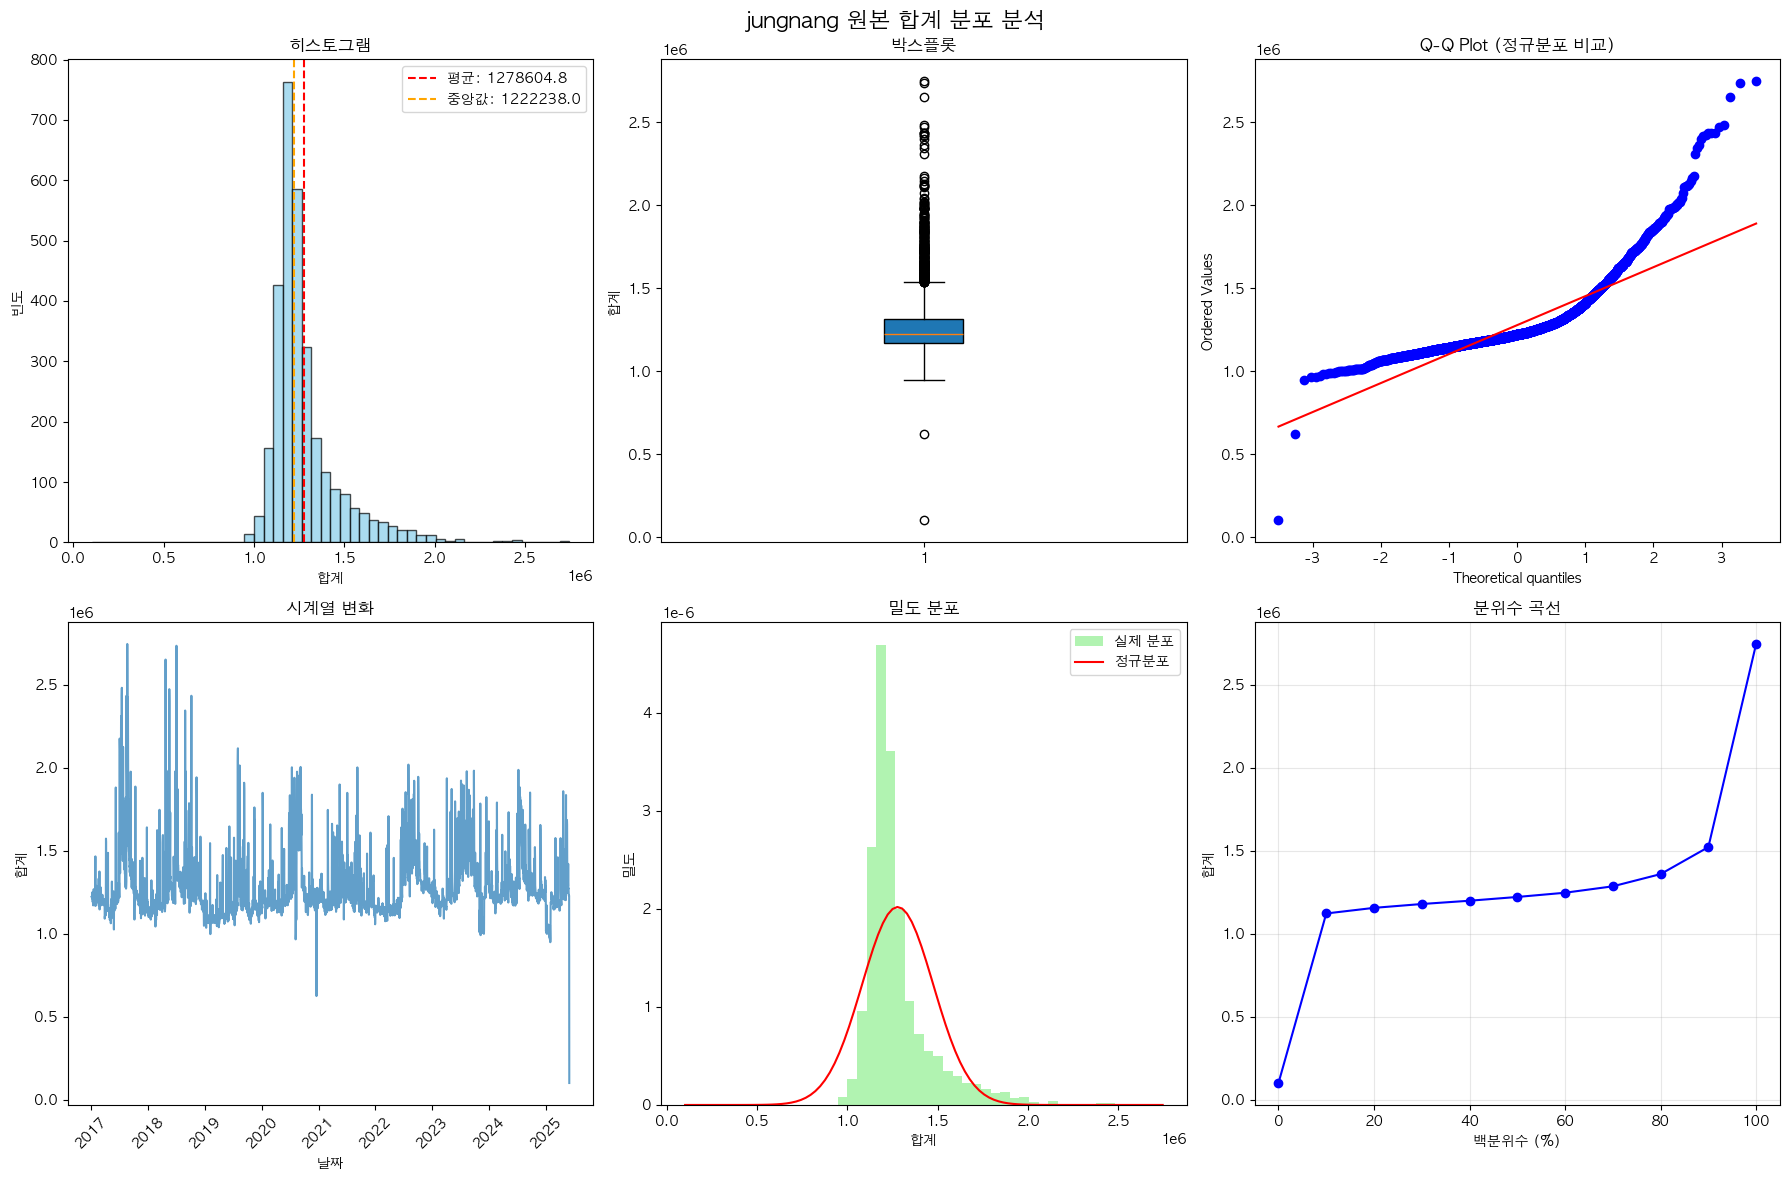

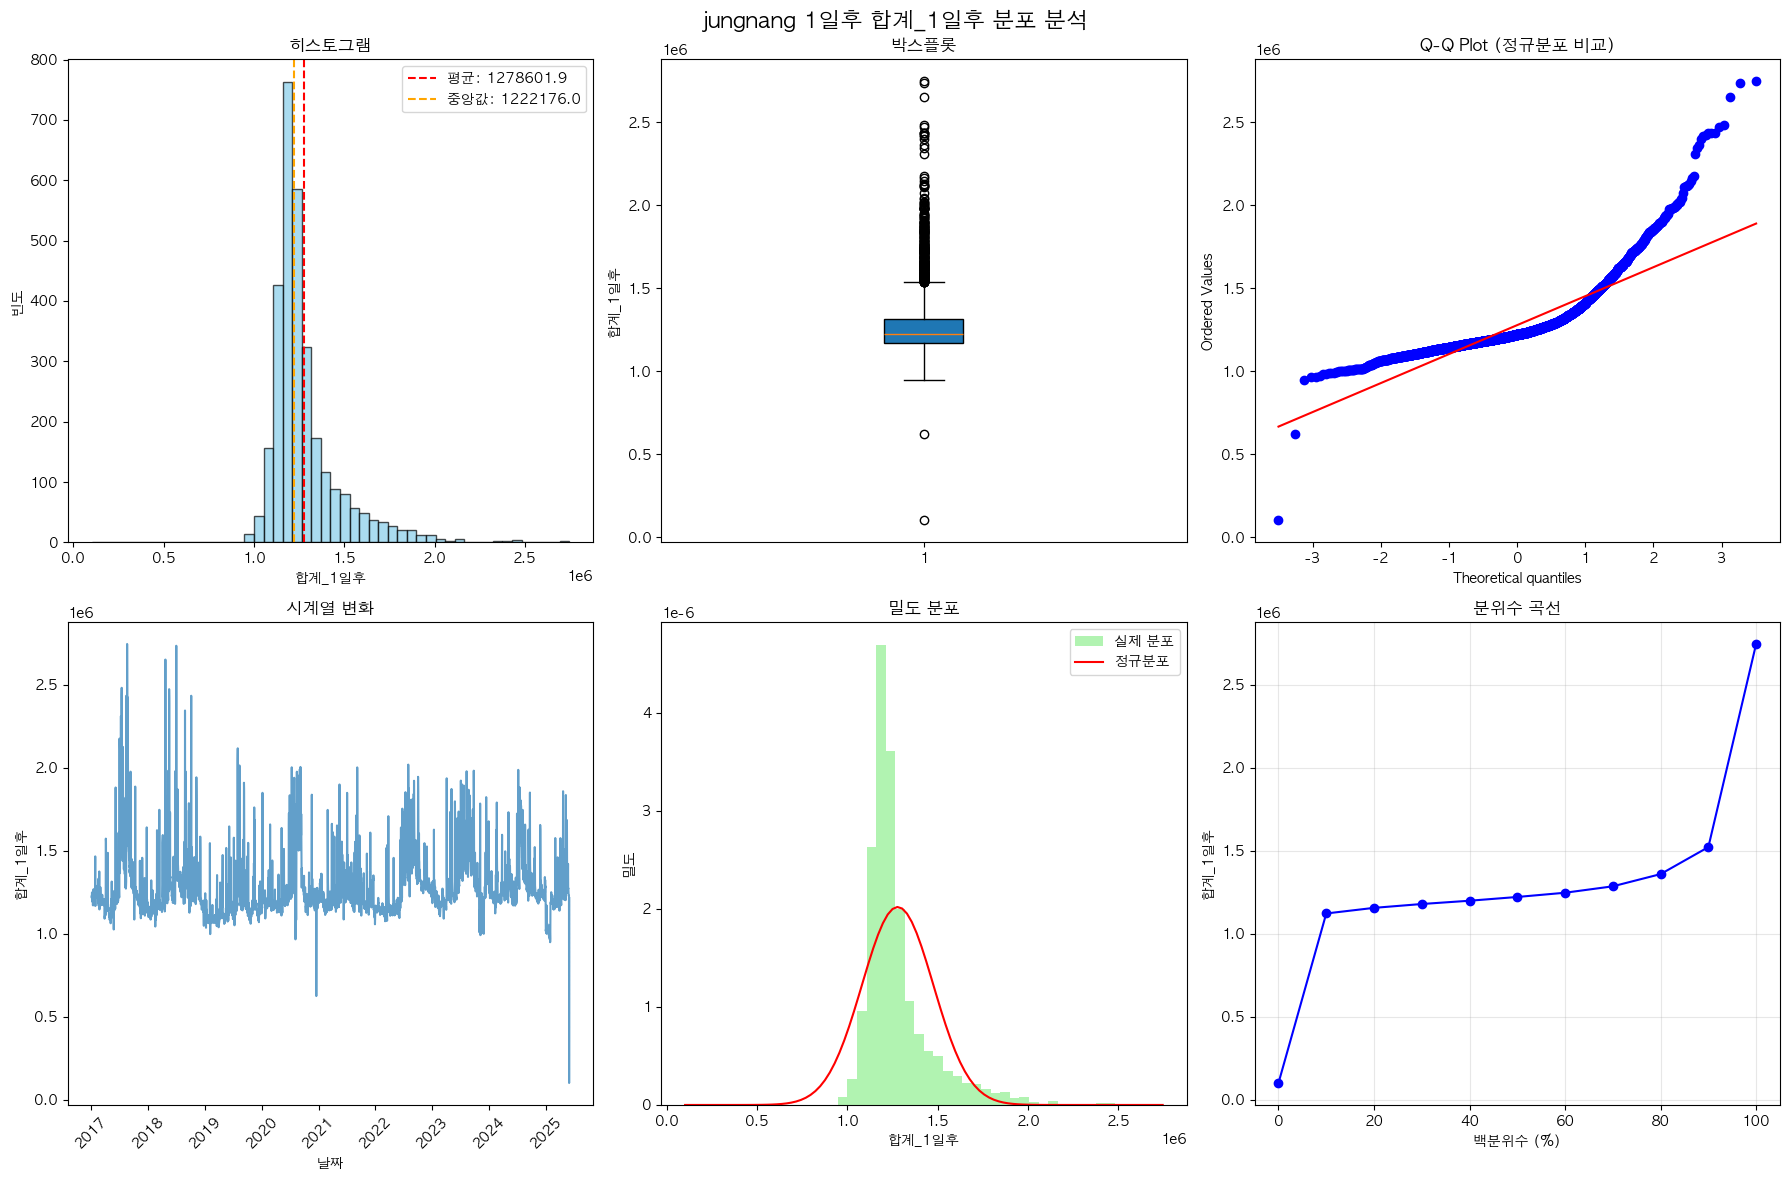


=== jungnang 1일후 클래스 수별 분류 난이도 ===
q: 요청 클래스 수, actual: 실제 클래스 수, balance: 균형도(높을수록 좋음)
cv: 변동계수(낮을수록 균등), entropy: 정규화 엔트로피(높을수록 균등)
theor_acc: 이론적 랜덤 정확도
 q  actual  balance    cv  entropy  theor_acc
 3       3    0.999 0.001      1.0      0.333
 4       4    0.999 0.001      1.0      0.250
 5       5    0.998 0.001      1.0      0.200
 6       6    0.998 0.001      1.0      0.167
 7       7    0.998 0.001      1.0      0.143
 8       8    0.997 0.001      1.0      0.125
 9       9    0.997 0.001      1.0      0.111
10      10    0.997 0.001      1.0      0.100
11      11    0.996 0.001      1.0      0.091


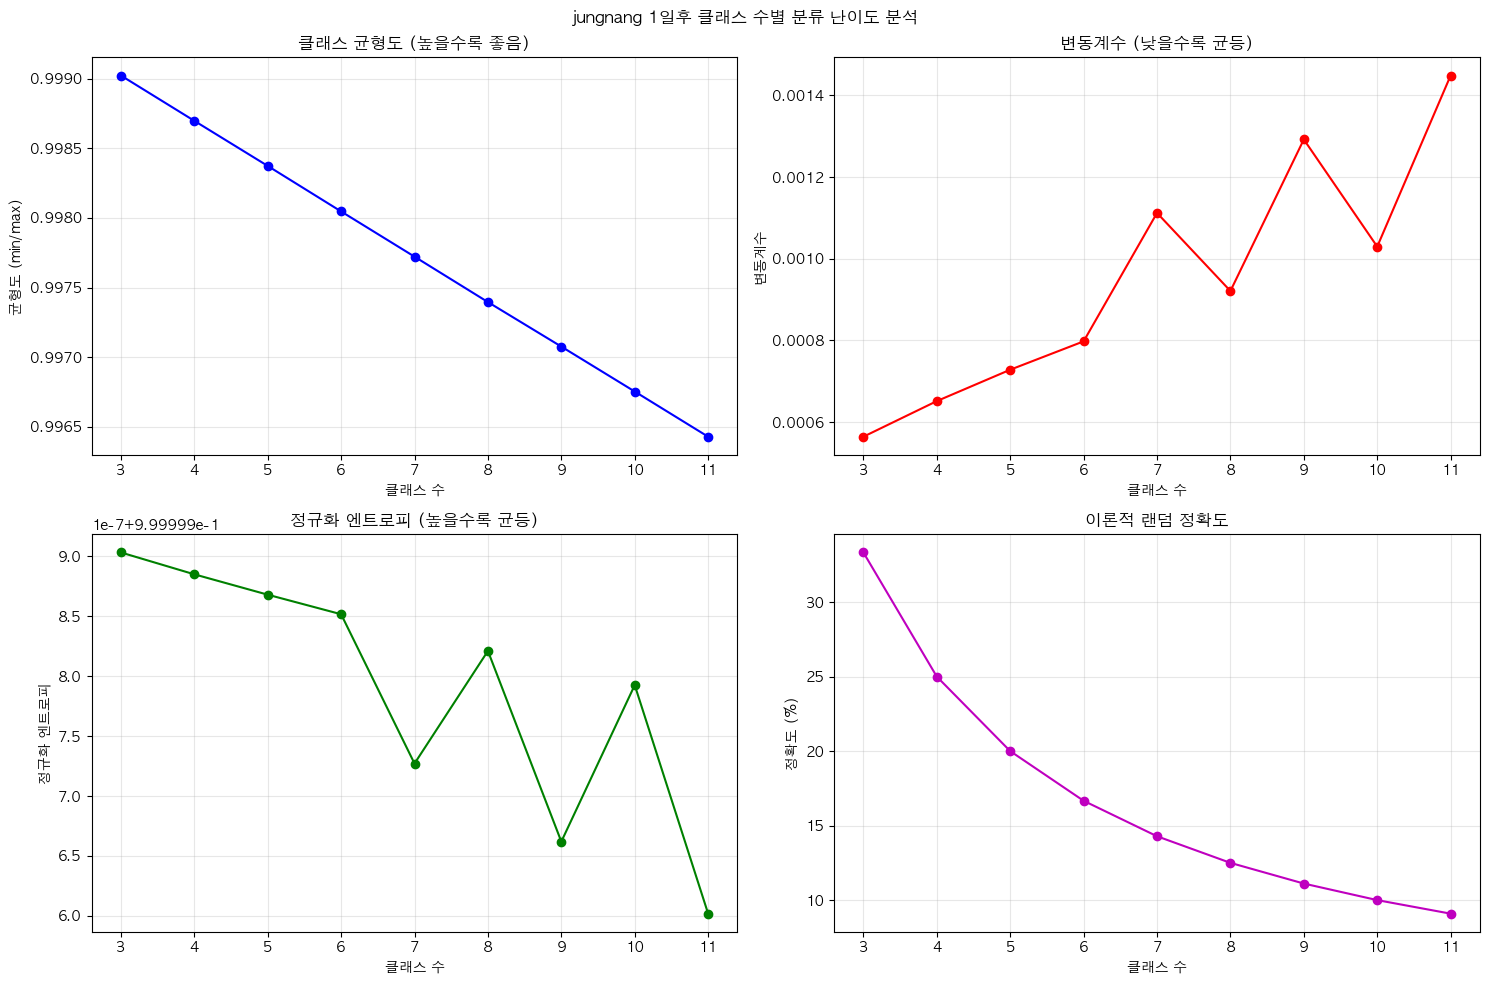


추천 클래스 수: 3개 (엔트로피 기준)

[seonam] 원본 합계
=== seonam 합계 분포 분석 ===
데이터 개수: 3071
결측치: 0개

기본 통계량:
  평균: 1576634.4
  표준편차: 238545.9
  중앙값: 1504239.0
  최솟값: 1160337.0
  최댓값: 2780034.0
  범위: 1619697.0

분위수:
   5%: 1347918.5
  10%: 1392119.0
  25%: 1446441.5
  50%: 1504239.0
  75%: 1604284.5
  90%: 1915901.0
  95%: 2130948.0
  99%: 2495574.9

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7613
  p-값: 4.60e-55
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.114 (오른쪽 치우침)
  첨도 (Kurtosis): 4.641 (뾰족함)

이상치 분석 (IQR 방법):
  IQR: 157843.0
  하한: 1209677.0
  상한: 1841049.0
  이상치 개수: 362개 (11.8%)
  이상치 범위: 1160337.0 ~ 2780034.0

[seonam] 1일 후 합계 (예측 타깃)
=== seonam 합계_1일후 분포 분석 ===
데이터 개수: 3071
결측치: 0개

기본 통계량:
  평균: 1576157.0
  표준편차: 240228.3
  중앙값: 1504239.0
  최솟값: 0.0
  최댓값: 2780034.0
  범위: 2780034.0

분위수:
   5%: 1347536.0
  10%: 1391607.0
  25%: 1446325.0
  50%: 1504239.0
  75%: 1604284.5
  90%: 1915901.0
  95%: 2130948.0
  99%: 2495574.9

정규성 검정 (Shapiro-Wilk):
  통계량: 0.7624
  p-값: 5.57e-55
  정규분포 여부: 아니오

분포 형태:
  왜도 (S

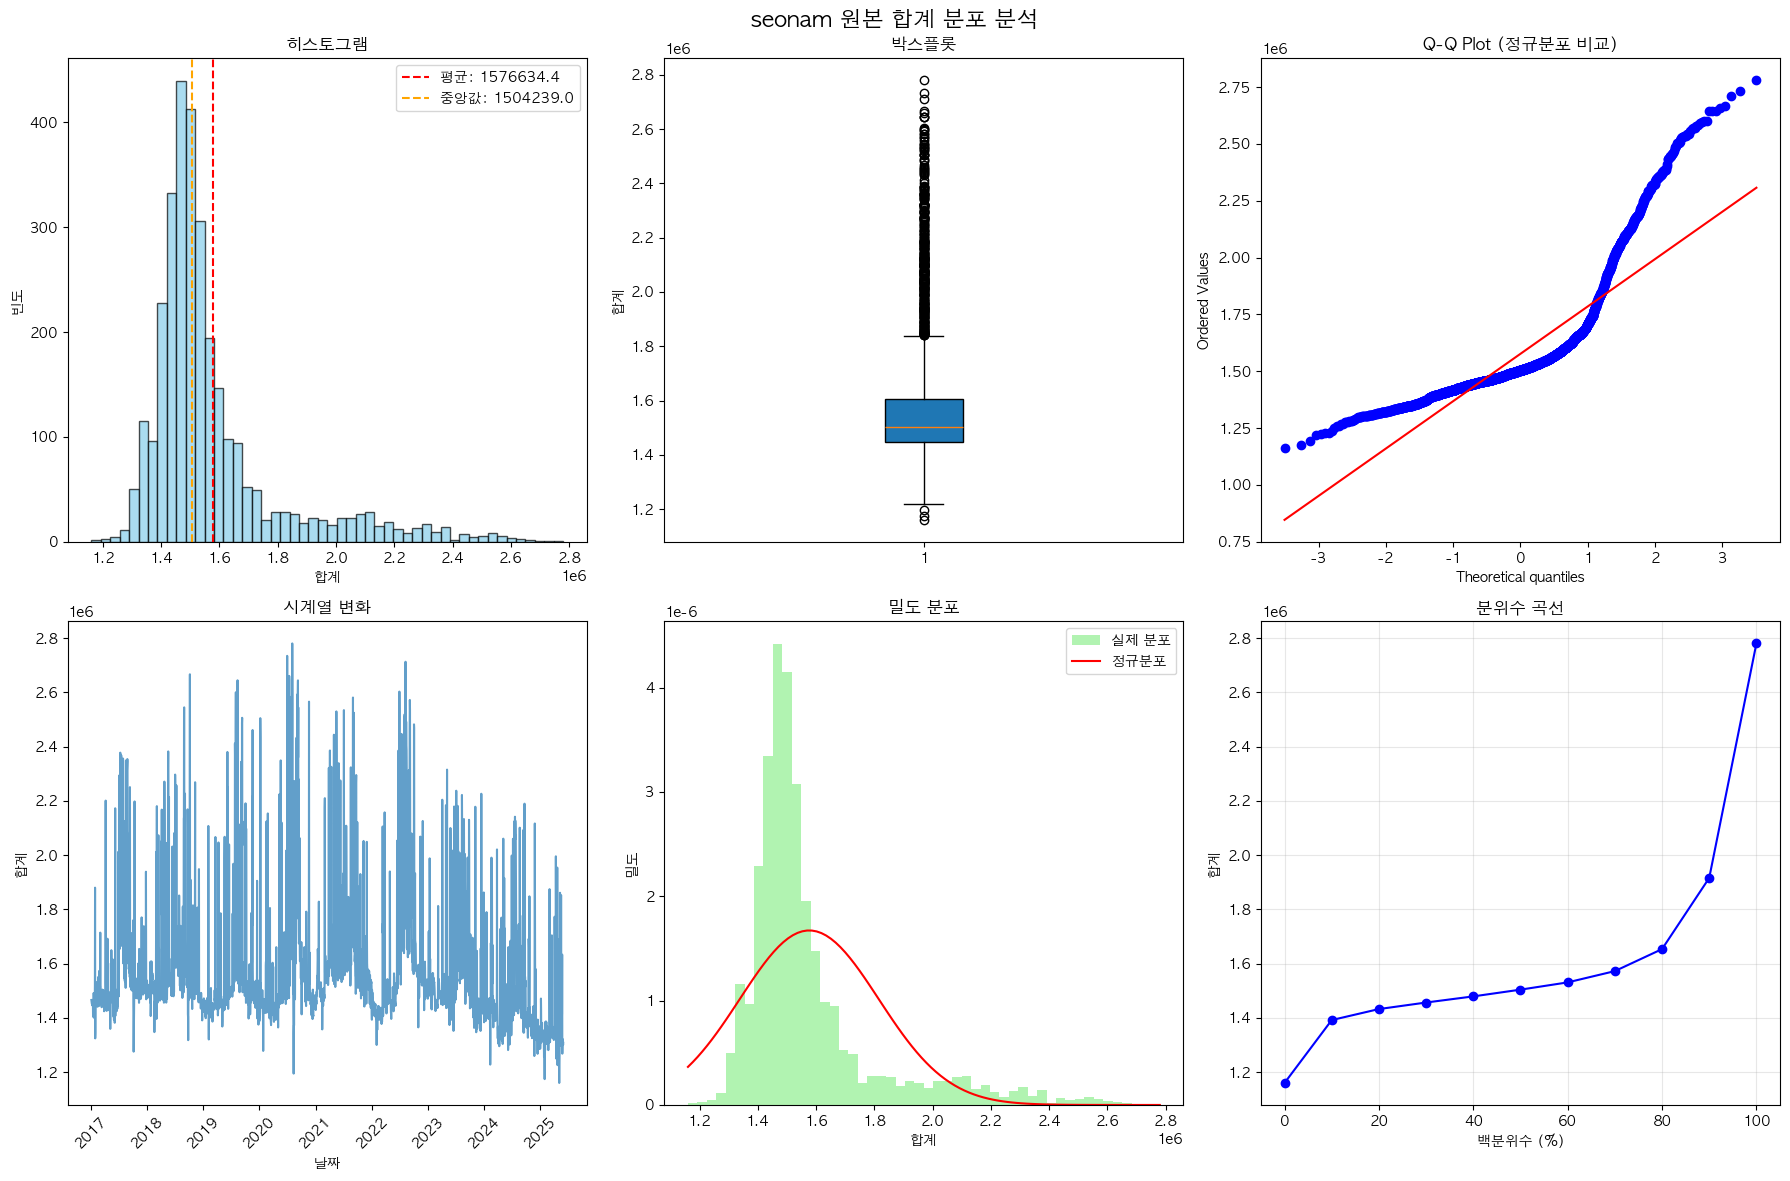

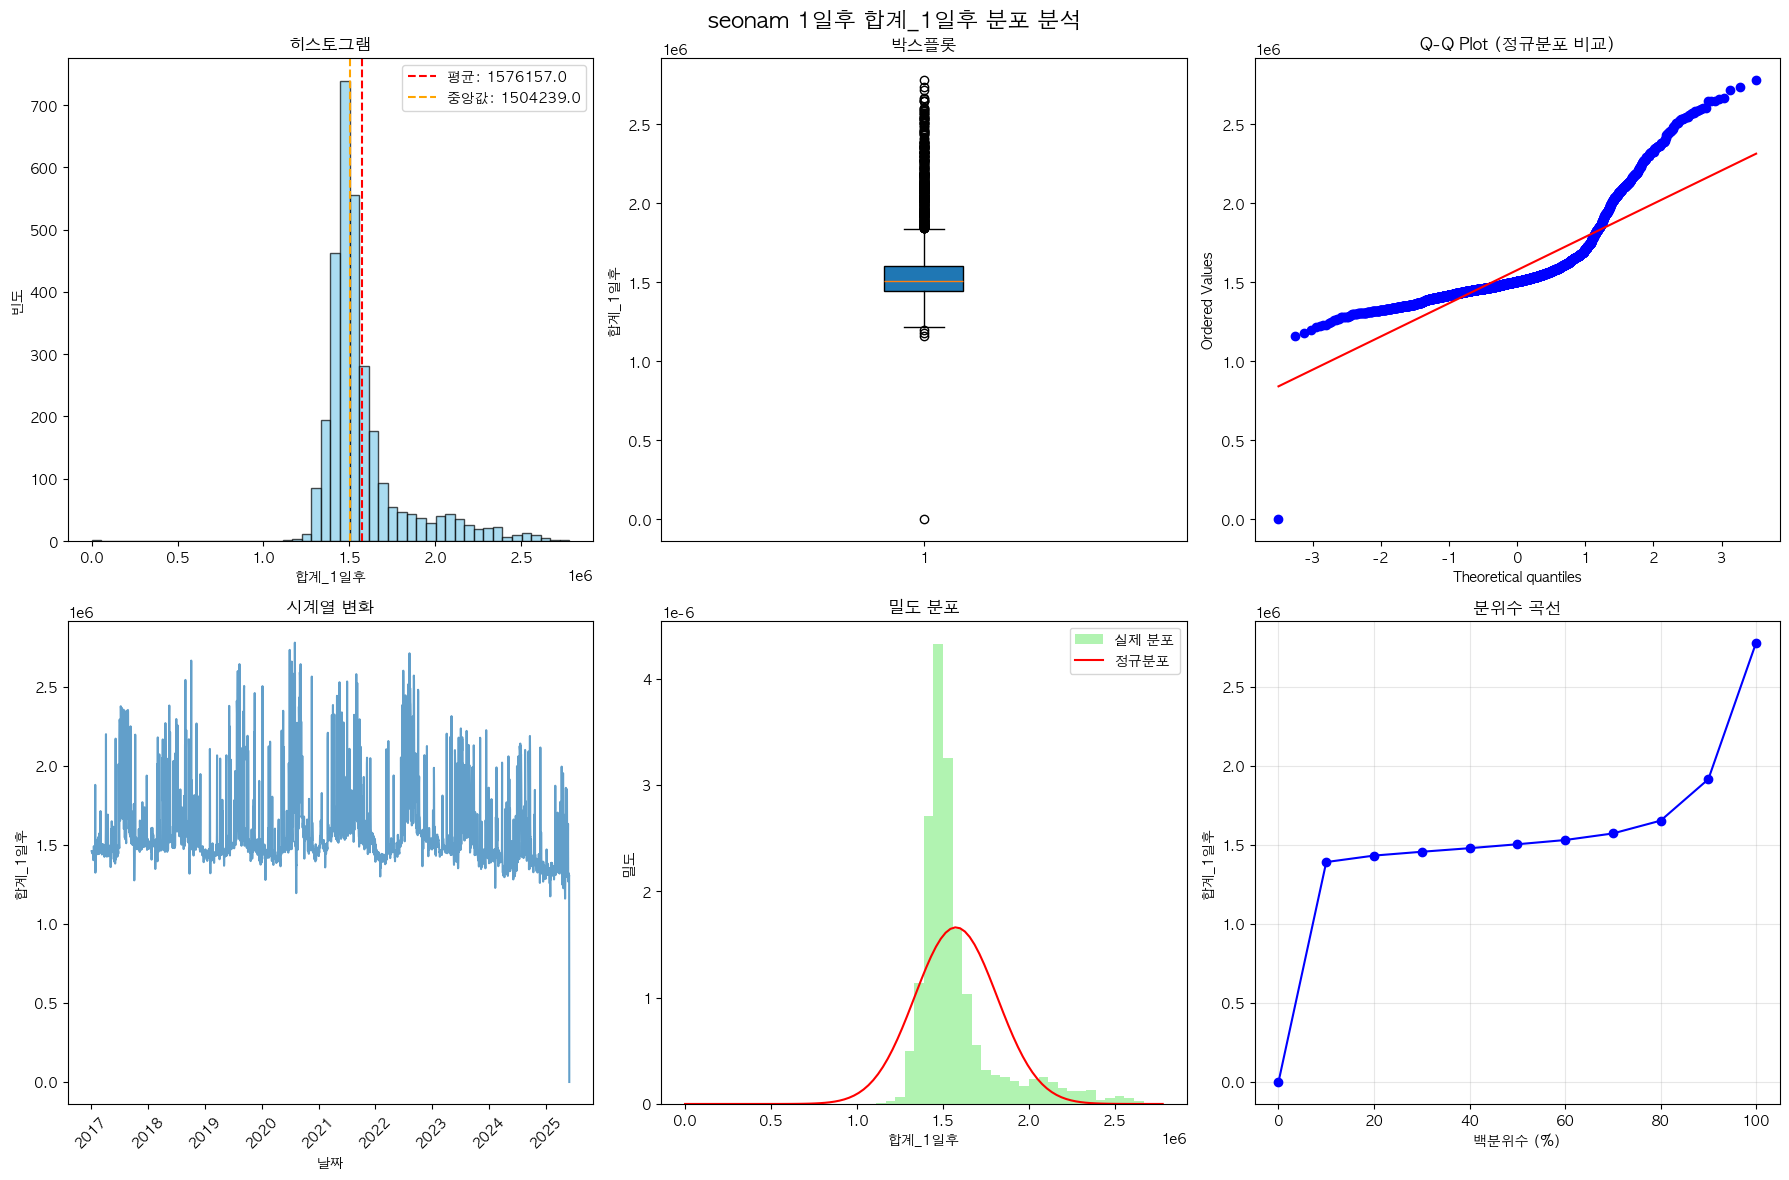


=== seonam 1일후 클래스 수별 분류 난이도 ===
q: 요청 클래스 수, actual: 실제 클래스 수, balance: 균형도(높을수록 좋음)
cv: 변동계수(낮을수록 균등), entropy: 정규화 엔트로피(높을수록 균등)
theor_acc: 이론적 랜덤 정확도
 q  actual  balance    cv  entropy  theor_acc
 3       3    0.999 0.001      1.0      0.333
 4       4    0.999 0.001      1.0      0.250
 5       5    0.998 0.001      1.0      0.200
 6       6    0.998 0.001      1.0      0.167
 7       7    0.998 0.001      1.0      0.143
 8       8    0.997 0.001      1.0      0.125
 9       9    0.997 0.001      1.0      0.111
10      10    0.997 0.001      1.0      0.100
11      11    0.996 0.001      1.0      0.091


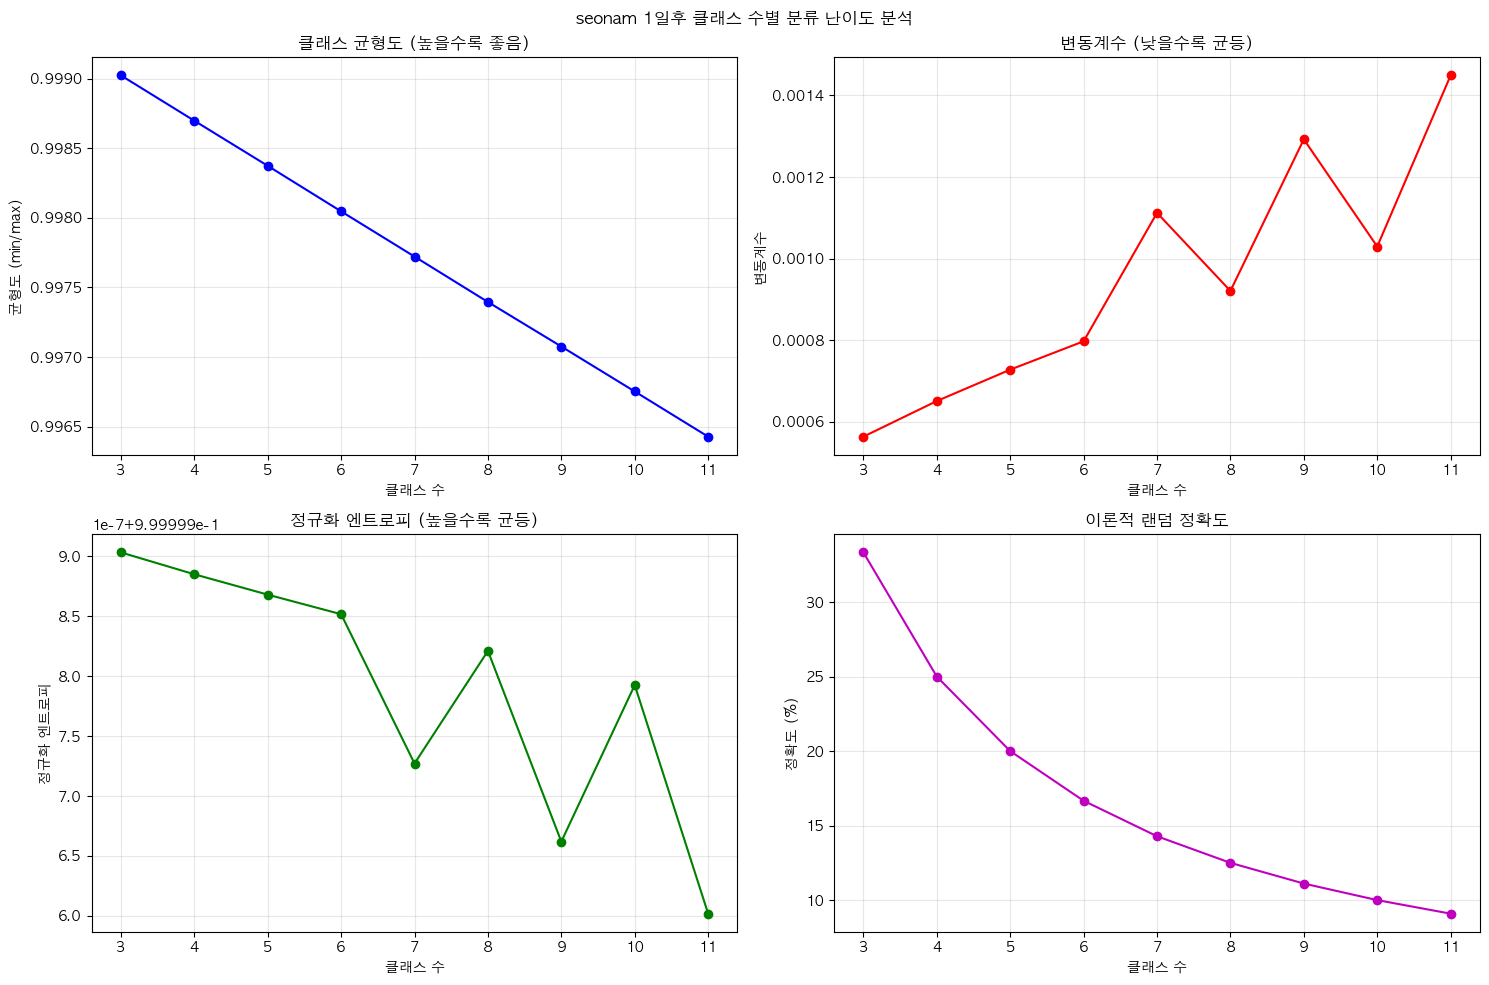


추천 클래스 수: 3개 (엔트로피 기준)

[tancheon] 원본 합계
=== tancheon 합계 분포 분석 ===
데이터 개수: 3071
결측치: 0개

기본 통계량:
  평균: 745524.3
  표준편차: 108208.9
  중앙값: 718123.0
  최솟값: 543425.0
  최댓값: 1423827.0
  범위: 880402.0

분위수:
   5%: 639655.5
  10%: 651966.0
  25%: 677376.5
  50%: 718123.0
  75%: 776736.0
  90%: 874300.0
  95%: 969523.0
  99%: 1179654.0

정규성 검정 (Shapiro-Wilk):
  통계량: 0.8091
  p-값: 3.28e-51
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.151 (오른쪽 치우침)
  첨도 (Kurtosis): 6.189 (뾰족함)

이상치 분석 (IQR 방법):
  IQR: 99359.5
  하한: 528337.2
  상한: 925775.2
  이상치 개수: 194개 (6.3%)
  이상치 범위: 925800.0 ~ 1423827.0

[tancheon] 1일 후 합계 (예측 타깃)
=== tancheon 합계_1일후 분포 분석 ===
데이터 개수: 3071
결측치: 0개

기본 통계량:
  평균: 745519.0
  표준편차: 108212.8
  중앙값: 718123.0
  최솟값: 543425.0
  최댓값: 1423827.0
  범위: 880402.0

분위수:
   5%: 639655.5
  10%: 651966.0
  25%: 677376.5
  50%: 718123.0
  75%: 776736.0
  90%: 874300.0
  95%: 969523.0
  99%: 1179654.0

정규성 검정 (Shapiro-Wilk):
  통계량: 0.8092
  p-값: 3.30e-51
  정규분포 여부: 아니오

분포 형태:
  왜도 (Skewness): 2.1

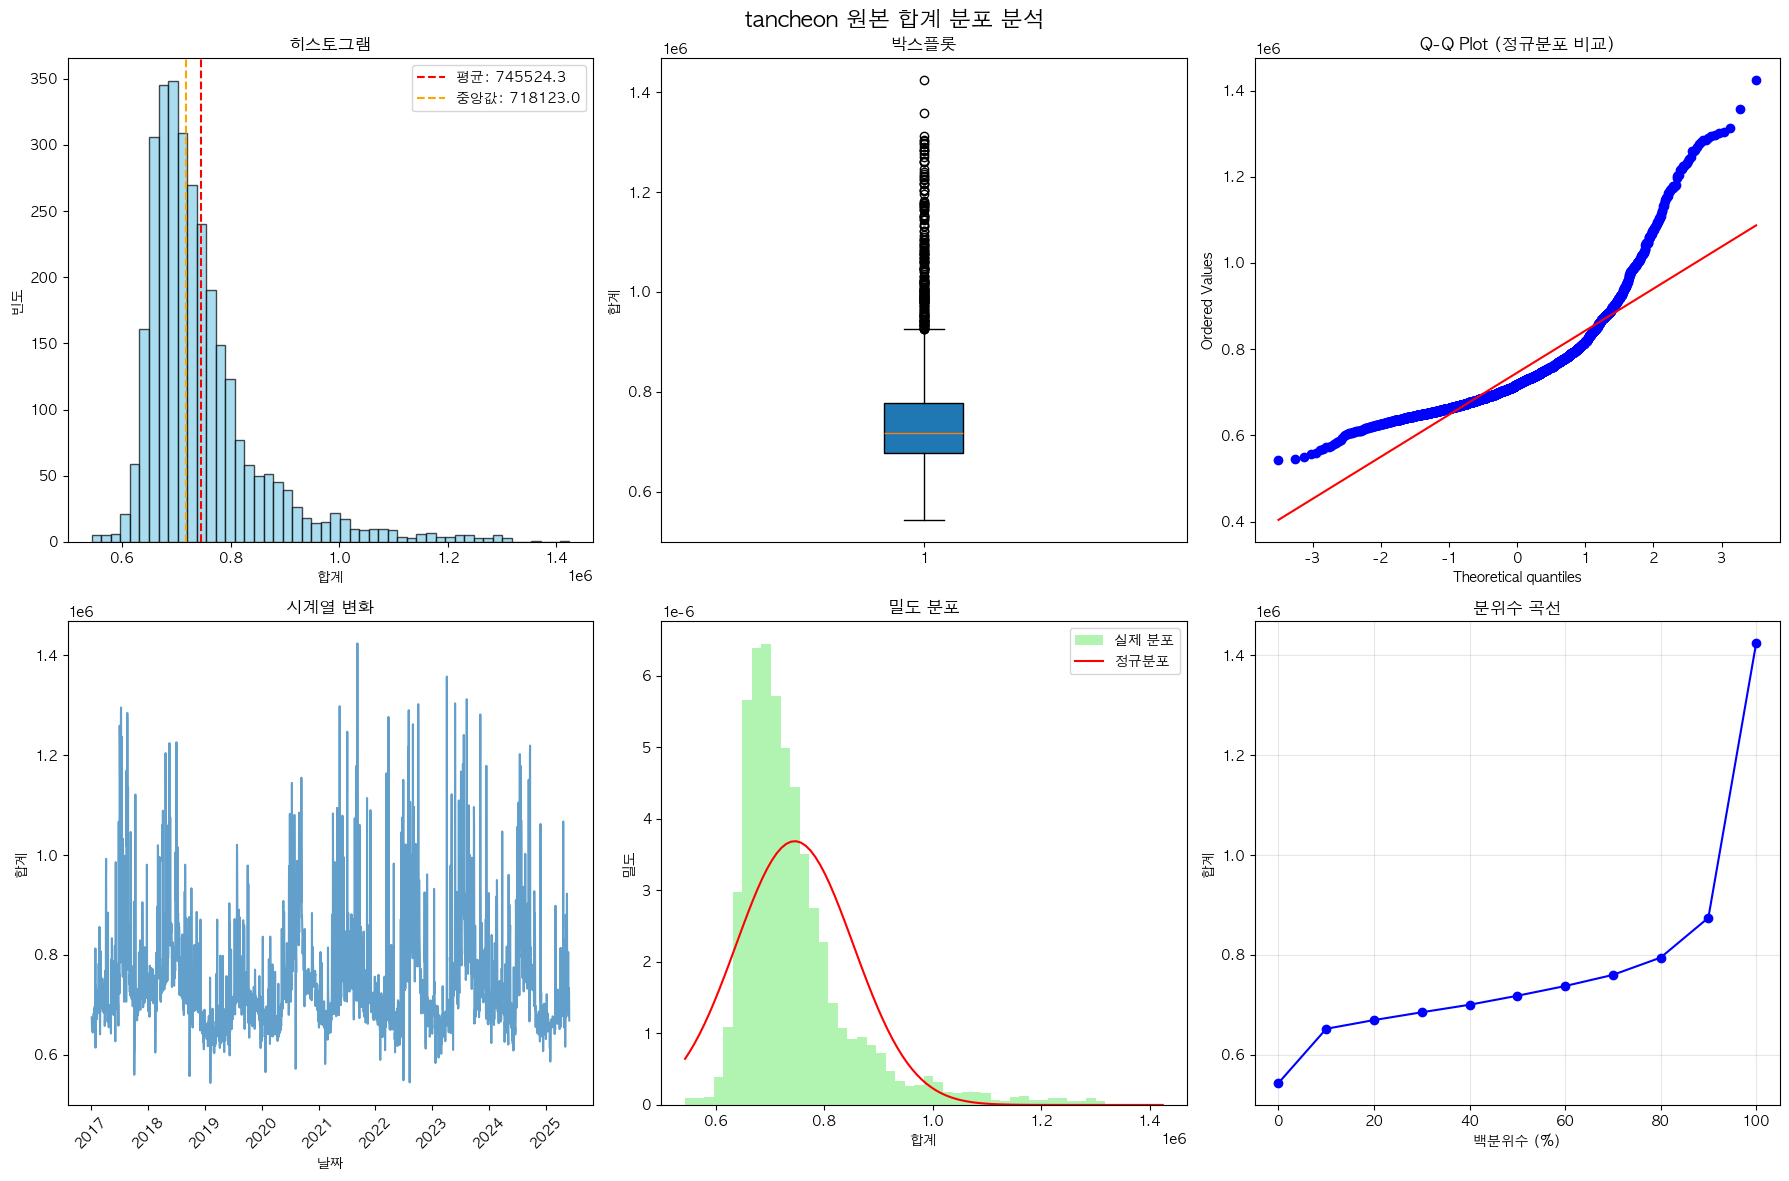

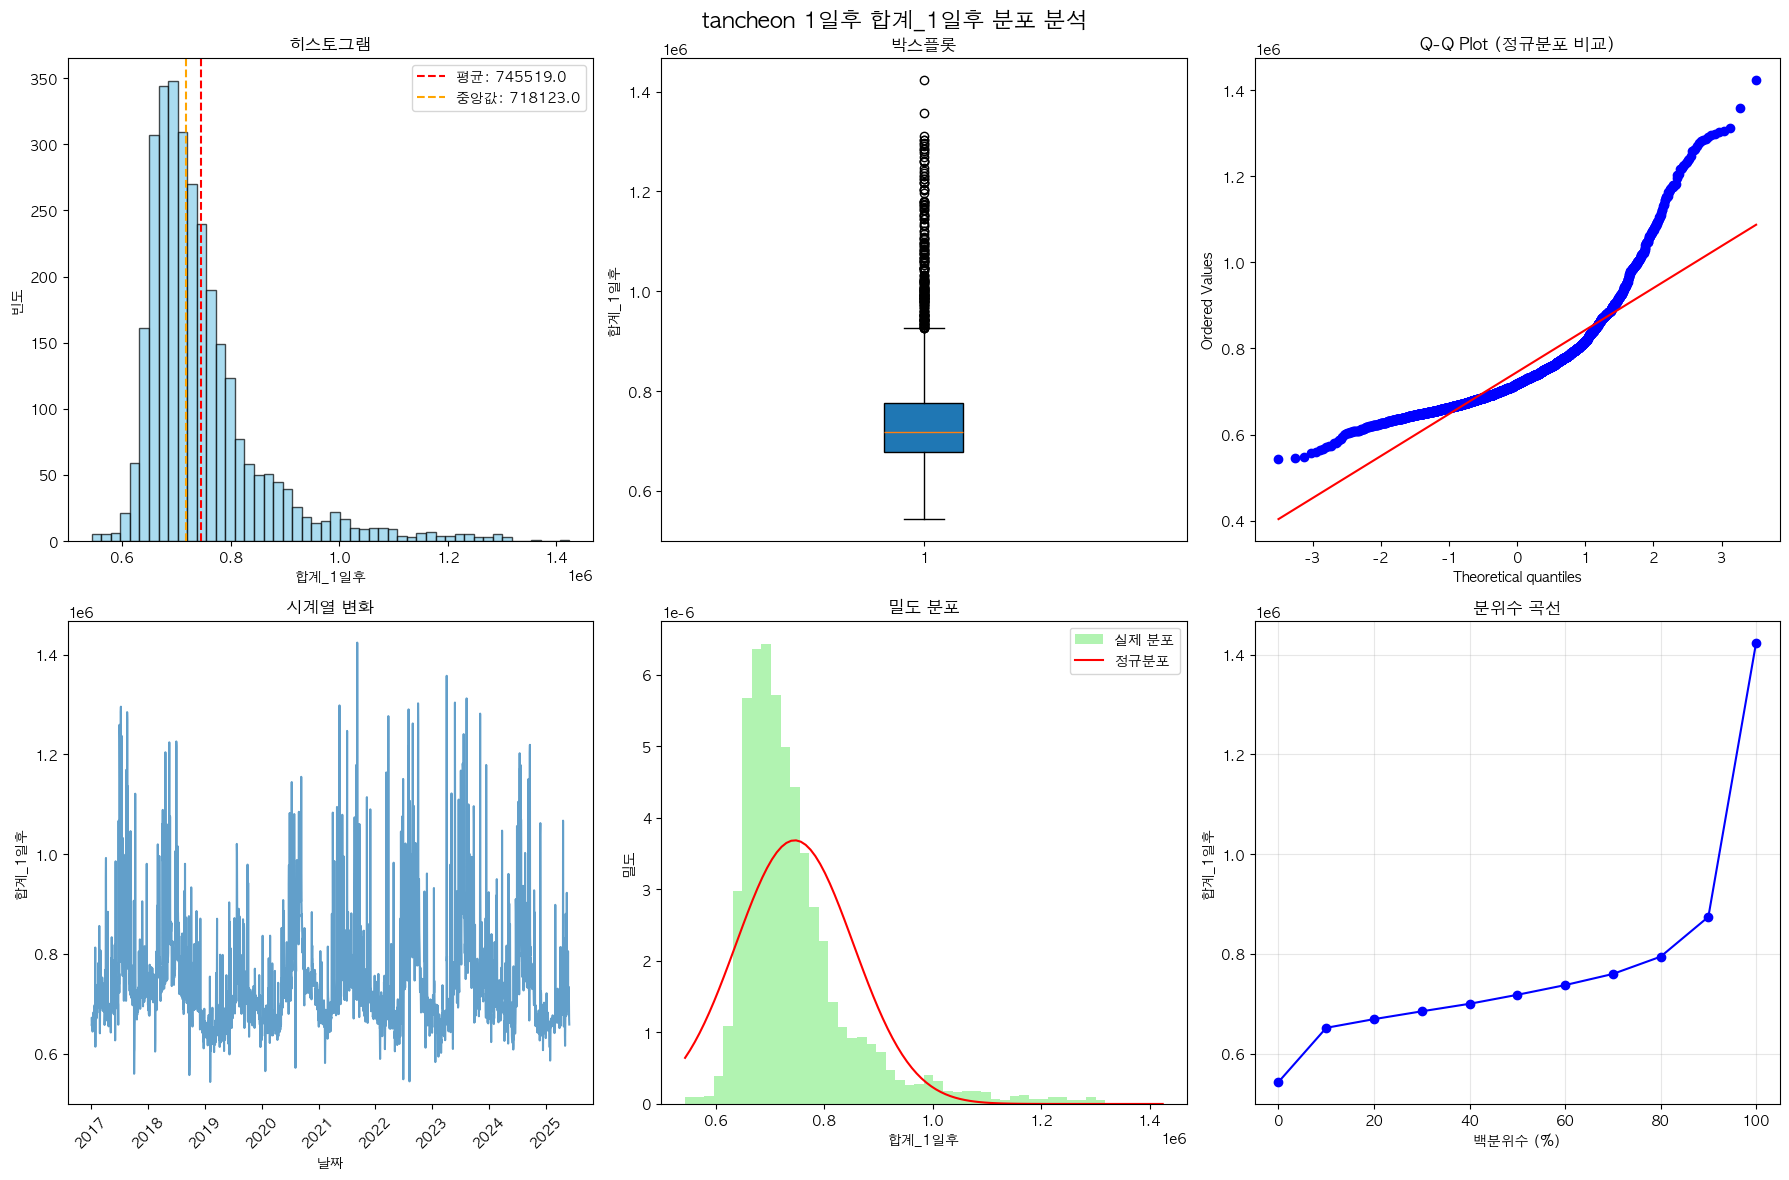


=== tancheon 1일후 클래스 수별 분류 난이도 ===
q: 요청 클래스 수, actual: 실제 클래스 수, balance: 균형도(높을수록 좋음)
cv: 변동계수(낮을수록 균등), entropy: 정규화 엔트로피(높을수록 균등)
theor_acc: 이론적 랜덤 정확도
 q  actual  balance    cv  entropy  theor_acc
 3       3    0.999 0.001      1.0      0.333
 4       4    0.999 0.001      1.0      0.250
 5       5    0.998 0.001      1.0      0.200
 6       6    0.998 0.001      1.0      0.167
 7       7    0.993 0.002      1.0      0.143
 8       8    0.997 0.001      1.0      0.125
 9       9    0.997 0.001      1.0      0.111
10      10    0.997 0.001      1.0      0.100
11      11    0.996 0.001      1.0      0.091


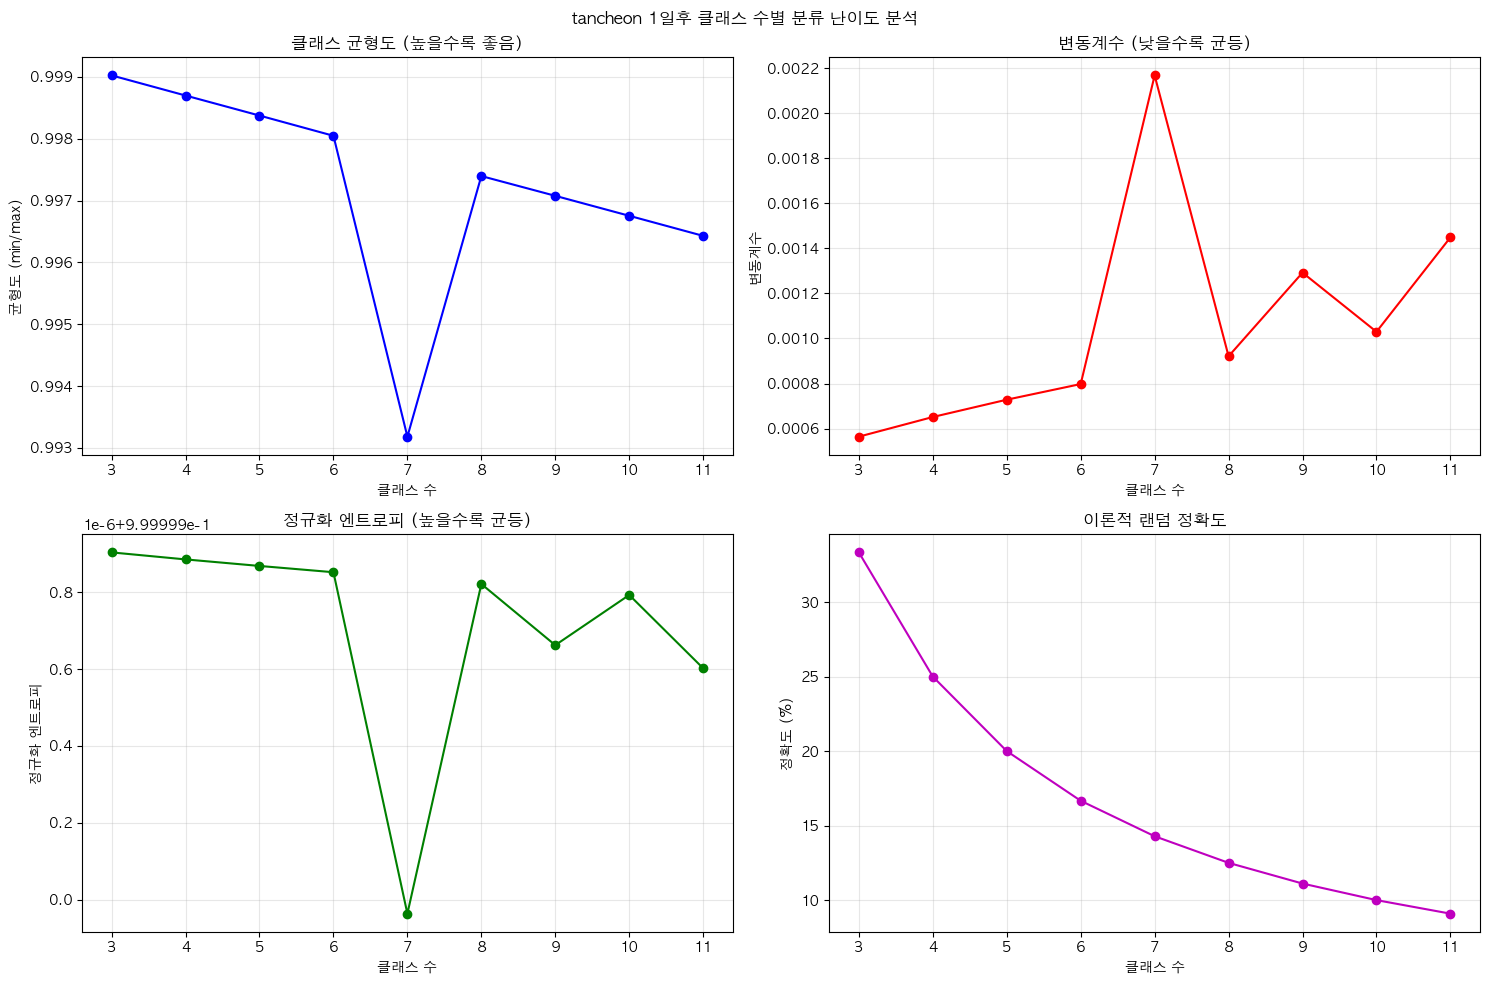


추천 클래스 수: 3개 (엔트로피 기준)

=== 센터별 비교 요약 ===
                mean        std     median       min        max  skewness  \
nanji      603760.22  133447.05   556452.0       0.0  1381444.0      2.37   
jungnang  1278601.90  197497.59  1222176.0  101840.0  2745792.0      2.30   
seonam    1576156.99  240228.33  1504239.0       0.0  2780034.0      1.98   
tancheon   745519.03  108212.79   718123.0  543425.0  1423827.0      2.15   

          kurtosis  outlier_count  outlier_ratio  
nanji         6.61          355.0           0.12  
jungnang      8.69          292.0           0.10  
seonam        5.05          363.0           0.12  
tancheon      6.19          194.0           0.06  


In [72]:
# 현재 로드된 데이터로 종합 분석
centers_dict = {
    "nanji": nanji,
    "jungnang": jungnang, 
    "seonam": seonam,
    "tancheon": tancheon
}

# 전체 분석 (시간이 걸릴 수 있음)
all_stats = comprehensive_target_analysis(centers_dict)

In [73]:
'''
nanji    = make_features(nanji)
jungnang = make_features(jungnang)
seonam   = make_features(seonam)
tancheon = make_features(tancheon)
'''

# 컷 확인
print(nanji.attrs['cutoffs'])  # {'q15': ..., 'q70': ..., 'q90': ...}
print(jungnang.attrs['cutoffs'])
print(seonam.attrs['cutoffs'])
print(tancheon.attrs['cutoffs'])

print(nanji.shape)
print(jungnang.shape)
print(seonam.shape)
print(tancheon.shape)

{'q15': 513466.485, 'q70': 596351.4, 'q90': 776100.8000000002}
{'q15': 1141432.0, 'q70': 1285042.4, 'q90': 1522312.6}
{'q15': 1411120.2, 'q70': 1570617.7999999998, 'q90': 1909166.4000000001}
{'q15': 661427.1, 'q70': 759528.7999999999, 'q90': 874285.6}
(3071, 44)
(3071, 44)
(3071, 43)
(3071, 42)


### 모델링

In [74]:
'''def build_regression_models():
    """회귀 모델들"""
    models = {}
    
    models["RandomForest_Reg"] = RandomForestRegressor(
        n_estimators=300, min_samples_leaf=2, random_state=42, n_jobs=-1
    )
    
    models["LinearRegression"] = LinearRegression()
    
    models["GradientBoosting_Reg"] = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, random_state=42
    )
    
    if HAS_XGB:
        models["XGBoost_Reg"] = xgb.XGBRegressor(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbosity=0
        )
    
    if HAS_LGB:
        models["LightGBM_Reg"] = lgb.LGBMRegressor(
            n_estimators=500, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbosity=-1
        )
    
    '''
    if HAS_CATBOOST:
        models["CatBoost_Reg"] = cb.CatBoostRegressor(
            iterations=500, learning_rate=0.05, depth=6,
            random_state=42, verbose=False
        )
    '''
    if HAS_CATBOOST:
        models["CatBoost_Clf"] = cb.CatBoostClassifier(
            iterations=500, learning_rate=0.05, depth=6,
            random_state=42, verbose=False, auto_class_weights='Balanced' # <--- 여기를 수정!
        )
    return models

def build_classification_models():
    """분류 모델들 (4등급)"""
    models = {}
    
    models["RandomForest_Clf"] = RandomForestClassifier(
        n_estimators=300, min_samples_leaf=2, random_state=42, 
        n_jobs=-1, class_weight='balanced'
    )
    
    models["GradientBoosting_Clf"] = GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, random_state=42
    )
    
    models["LogisticRegression_Clf"] = LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=1000,
        random_state=42, class_weight='balanced'
    )
    
    if HAS_XGB:
        models["XGBoost_Clf"] = xgb.XGBClassifier(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            objective="multi:softprob", num_class=4,
            tree_method="hist", random_state=42, n_jobs=-1, verbosity=0
        )
    
    if HAS_LGB:
        models["LightGBM_Clf"] = lgb.LGBMClassifier(
            n_estimators=500, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            objective="multiclass", num_class=4,
            random_state=42, n_jobs=-1, verbosity=-1, is_unbalance=True
        )
    
    if HAS_CATBOOST:
        models["CatBoost_Clf"] = cb.CatBoostClassifier(
            iterations=500, learning_rate=0.05, depth=6,
            random_state=42, verbose=False, class_weights='Balanced'
        )
    
    return models

def extract_feature_importance(model, model_name, feature_names):
    """모델별 Feature Importance 추출"""
    try:
        if hasattr(model.named_steps['model'], 'feature_importances_'):
            # Tree-based models (RandomForest, GradientBoosting, XGBoost, LightGBM, CatBoost)
            importance = model.named_steps['model'].feature_importances_
        elif hasattr(model.named_steps['model'], 'coef_'):
            # Linear models (LinearRegression, LogisticRegression)
            importance = np.abs(model.named_steps['model'].coef_.flatten())
        else:
            return None
            
        # Feature importance DataFrame 생성
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        return importance_df
    except Exception as e:
        print(f"Feature importance 추출 실패 ({model_name}): {e}")
        return None

def plot_feature_importance(importance_df, model_name, top_n=15):
    """Feature Importance 시각화"""
    if importance_df is None or len(importance_df) == 0:
        return
    
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(top_n)
    
    # 가로 막대 그래프
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'{model_name} - Top {top_n} Feature Importance')
    plt.gca().invert_yaxis()
    
    # 값 표시
    for i, v in enumerate(top_features['importance']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

def analyze_model_with_shap(model, X_test, feature_names, model_name, max_samples=100):
    """SHAP 분석"""
    if not HAS_SHAP:
        print("SHAP 라이브러리가 설치되지 않았습니다.")
        return None
    
    try:
        # 샘플 수 제한 (SHAP 계산 시간 단축)
        if len(X_test) > max_samples:
            sample_idx = np.random.choice(len(X_test), max_samples, replace=False)
            X_sample = X_test.iloc[sample_idx]
        else:
            X_sample = X_test
        
        # 전처리된 데이터 얻기
        X_processed = model.named_steps['pre'].transform(X_sample)
        
        # 모델별 SHAP Explainer 선택
        if 'RandomForest' in model_name or 'GradientBoosting' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        elif 'XGBoost' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        elif 'LightGBM' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        elif 'CatBoost' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        else:
            # Linear models
            explainer = shap.LinearExplainer(model.named_steps['model'], X_processed)
        
        # SHAP values 계산
        shap_values = explainer.shap_values(X_processed)
        
        # 다중 클래스의 경우 첫 번째 클래스만 사용
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        return shap_values, X_processed, explainer
        
    except Exception as e:
        print(f"SHAP 분석 실패 ({model_name}): {e}")
        return None

def plot_shap_summary(shap_values, X_processed, feature_names, model_name):
    """SHAP Summary Plot"""
    if shap_values is None or not HAS_SHAP:
        return
    
    try:
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_processed, feature_names=feature_names, 
                         plot_type="bar", show=False)
        plt.title(f'{model_name} - SHAP Feature Importance')
        plt.tight_layout()
        plt.show()
        
        # Beeswarm plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_processed, feature_names=feature_names, 
                         show=False)
        plt.title(f'{model_name} - SHAP Summary Plot')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"SHAP 시각화 실패 ({model_name}): {e}")

def comprehensive_model_analysis(model, model_name, X_train, X_test, y_train, y_test, 
                               feature_names, model_type):
    """종합적인 모델 분석 (Feature Importance + SHAP)"""
    print(f"\n--- {model_name} 상세 분석 ---")
    
    # 1. Feature Importance 추출 및 시각화
    importance_df = extract_feature_importance(model, model_name, feature_names)
    if importance_df is not None:
        print(f"Top 10 중요 피처:")
        print(importance_df.head(10).to_string(index=False))
        plot_feature_importance(importance_df, model_name)
    
    # 2. SHAP 분석
    shap_result = analyze_model_with_shap(model, X_test, feature_names, model_name)
    if shap_result is not None:
        shap_values, X_processed, explainer = shap_result
        plot_shap_summary(shap_values, X_processed, feature_names, model_name)
    
    return importance_df, shap_result

def plot_stratified_comparison(results_df):
    """비교 결과 시각화"""
    if len(results_df) == 0:
        print("시각화할 결과가 없습니다.")
        return
    
    # successful_results가 results_df 안에 있어야 함
    successful_results = results_df[results_df['success'] == True].copy()
    if len(successful_results) == 0:
        print("성공한 결과가 없어 시각화를 생략합니다.")
        return

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Stratified vs 시계열 분할 비교', fontsize=16)
    
    # 1. 회귀 모델 R² 비교
    reg_results = successful_results[successful_results['type'] == 'regression']
    if len(reg_results) > 0:
        reg_pivot = reg_results.pivot_table(
            index='model', columns='split_method', values='r2', aggfunc='mean'
        )
        reg_pivot = reg_pivot.rename(columns={'stratified': 'random_shuffle'})
        reg_pivot.plot(kind='bar', ax=axes[0,0], color=['lightblue', 'orange'])
        axes[0,0].set_title('회귀 모델 R² 성능 비교')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].legend(title='Split Method')
        axes[0,0].set_ylim(0, 1)
    
    # 2. 분류 모델 F1 비교
    clf_results = successful_results[successful_results['type'] == 'classification']
    if len(clf_results) > 0:
        clf_pivot = clf_results.pivot_table(
            index='model', columns='split_method', values='macro_f1', aggfunc='mean'
        )
        clf_pivot.plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'red'])
        axes[0,1].set_title('분류 모델 Macro F1 성능 비교')
        axes[0,1].set_ylabel('Macro F1 Score')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].legend(title='Split Method')
        axes[0,1].set_ylim(0, 1)
    
    # 3. 센터별 회귀 성능
    if len(reg_results) > 0:
        center_reg = reg_results.groupby(['center', 'split_method'])['r2'].mean().unstack()
        center_reg = center_reg.rename(columns={'stratified': 'random_shuffle'})
        center_reg.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'orange'])
        axes[1,0].set_title('센터별 회귀 평균 성능')
        axes[1,0].set_ylabel('평균 R² Score')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend(title='Split Method')
    
    # 4. 센터별 분류 성능
    if len(clf_results) > 0:
        center_clf = clf_results.groupby(['center', 'split_method'])['macro_f1'].mean().unstack()
        center_clf.plot(kind='bar', ax=axes[1,1], color=['lightgreen', 'red'])
        axes[1,1].set_title('센터별 분류 평균 성능')
        axes[1,1].set_ylabel('평균 Macro F1 Score')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].legend(title='Split Method')
    
    plt.tight_layout()
    plt.show()
    
    
def make_pipeline_unified(model, model_name, model_type):
    """통합 전처리 파이프라인"""
    if model_name in ["LinearRegression", "LogisticRegression_Clf"]:
        # 선형 모델은 정규화 필요
        pre = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ])
    else:
        # 트리 기반 모델들은 정규화 불필요
        pre = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ])
    return Pipeline(steps=[("pre", pre), ("model", model)])

def prepare_data_stratified(df, target_col, model_type, test_size=0.2, split_method='stratified'):
    """
    데이터 준비 - Stratified vs 시계열 분할 선택 가능
    
    Parameters:
    - split_method: 'stratified' 또는 'temporal'
    """
    work = df.sort_values('날짜').reset_index(drop=True).copy()
    dates = pd.to_datetime(work['날짜'])

    # 제외할 컬럼들
    not_use_col = [
        '날짜',
        '1처리장','2처리장','정화조','중계펌프장','합계','시설현대화',
        '3처리장','4처리장','합계', '합계_1일후','합계_2일후',
        '등급','등급_1일후','등급_2일후'
    ]
    
    drop_cols = [c for c in (set(not_use_col) | {target_col}) if c in work.columns]
    X_raw = work.drop(columns=drop_cols, errors="ignore")
    
    # 수치형 변환
    for c in X_raw.columns:
        X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce")

    if model_type == "regression":
        y = pd.to_numeric(work[target_col], errors="coerce")
    else:  # classification
        y = work[target_col].astype("int64")

    # 결측치 제거
    valid_idx = (~X_raw.isnull().all(axis=1)) & (~pd.isnull(y))
    X_raw = X_raw[valid_idx].reset_index(drop=True)
    y = y[valid_idx].reset_index(drop=True)
    dates = dates[valid_idx].reset_index(drop=True)
    
    if split_method == 'stratified':
        # Stratified 분할 (분류에만 적용, 회귀는 일반 random split)
        if model_type == "classification":
            # 등급별 균등 분할
            sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
            train_idx, test_idx = next(sss.split(X_raw, y))
        else:
            # 회귀는 일반 랜덤 분할 (연속값이므로 stratify 불가)
            train_idx, test_idx = train_test_split(
                range(len(X_raw)), test_size=test_size, random_state=42
            )
            
        X_train, X_test = X_raw.iloc[train_idx].copy(), X_raw.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()
        dates_train, dates_test = dates.iloc[train_idx].copy(), dates.iloc[test_idx].copy()
        
    else:  # temporal split
        # 기존 시계열 분할
        n = len(work)
        split = int(n * (1 - test_size))
        X_train, X_test = X_raw.iloc[:split].copy(), X_raw.iloc[split:].copy()
        y_train, y_test = y.iloc[:split].copy(), y.iloc[split:].copy()
        dates_train, dates_test = dates.iloc[:split].copy(), dates.iloc[split:].copy()

    feature_names = list(X_raw.columns)
    return X_train, X_test, y_train, y_test, feature_names, dates_train, dates_test

def evaluate_regression_model(model, model_name, X_train, X_test, y_train, y_test):
    """회귀 모델 평가"""
    try:
        pipe = make_pipeline_unified(model, model_name, "regression")
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100  # 0으로 나누기 방지
        
        return {
            'model': model_name,
            'type': 'regression',
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'success': True
        }, pipe, y_pred
        
    except Exception as e:
        return {
            'model': model_name,
            'type': 'regression',
            'mae': np.nan,
            'rmse': np.nan,
            'r2': np.nan,
            'mape': np.nan,
            'success': False,
            'error': str(e)
        }, None, None

def evaluate_classification_model(model, model_name, X_train, X_test, y_train, y_test):
    """분류 모델 평가"""
    try:
        pipe = make_pipeline_unified(model, model_name, "classification")
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        
        # 차원 문제 해결
        if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
            y_pred = y_pred.ravel()
        
        acc = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
        f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)
        
        # 극값 분류 성능 (등급 0, 3로 수정: 0-base 변환 때문에)
        extreme_classes = [0, 3]  # 원래 1,4가 0,3으로 변환됨
        y_true_extreme = pd.Series(y_test).isin(extreme_classes).astype(int)
        y_pred_extreme = pd.Series(y_pred).isin(extreme_classes).astype(int)
        extreme_f1 = f1_score(y_true_extreme, y_pred_extreme, zero_division=0)
        
        return {
            'model': model_name,
            'type': 'classification',
            'accuracy': acc,
            'macro_f1': f1_macro,
            'weighted_f1': f1_weighted,
            'extreme_f1': extreme_f1,
            'success': True
        }, pipe, y_pred
        
    except Exception as e:
        return {
            'model': model_name,
            'type': 'classification',
            'accuracy': np.nan,
            'macro_f1': np.nan,
            'weighted_f1': np.nan,
            'extreme_f1': np.nan,
            'success': False,
            'error': str(e)
        }, None, None

def comprehensive_evaluation_comparison(center_name, df):
    """Stratified vs 시계열 분할 비교 평가"""
    print(f"\n{'='*70}")
    print(f"센터: {center_name} - Stratified vs 시계열 분할 비교")
    print(f"{'='*70}")
    
    # 데이터 확인
    print(f"데이터 크기: {len(df)}행, {len(df.columns)}컬럼")
    
    # 등급 분포 확인
    if '등급_1일후' in df.columns:
        grade_dist = df['등급_1일후'].value_counts().sort_index()
        print(f"등급 분포: {dict(grade_dist)}")
        
        # 불균형 정도 확인
        min_class = grade_dist.min()
        max_class = grade_dist.max()
        imbalance_ratio = max_class / min_class
        print(f"클래스 불균형 비율: {imbalance_ratio:.1f}:1 (최대:{max_class}, 최소:{min_class})")
    
    results = []
    
    # 두 가지 분할 방법 비교
    for split_method in ['temporal', 'stratified']:
        print(f"\n{'='*50}")
        print(f"분할 방법: {split_method.upper()}")
        print(f"{'='*50}")
        
        # =========================
        # 1. 회귀 모델 평가
        # =========================
        reg_method_name = "random_shuffle" if split_method == "stratified" else split_method
        print(f"\n--- 회귀 모델 평가 ({reg_method_name}) ---")
        
        try:
            X_train, X_test, y_train, y_test, feature_names, dates_train, dates_test = prepare_data_stratified(
                df, target_col="합계_1일후", model_type="regression", test_size=0.2, split_method=split_method
            )
            
            print(f"회귀용 데이터: 학습 {len(X_train)}행, 테스트 {len(X_test)}행")
            
            regression_models = build_regression_models()
            
            for model_name, model in tqdm(regression_models.items(), desc=f"회귀({reg_method_name})", leave=False):
                result, pipe, y_pred = evaluate_regression_model(model, model_name, X_train, X_test, y_train, y_test)
                result['center'] = center_name
                result['split_method'] = split_method
                results.append(result)
                
                if result['success']:
                    print(f"  {model_name:18s}: R²={result['r2']:.3f}, MAE={result['mae']:.0f}, MAPE={result['mape']:.1f}%")
                else:
                    print(f"  {model_name:18s}: 실패 - {result.get('error', '')[:50]}")
                    
        except Exception as e:
            print(f"회귀 모델 평가 실패 ({reg_method_name}): {e}")
        
        # =========================
        # 2. 분류 모델 평가
        # =========================
        print(f"\n--- 분류 모델 평가 ({split_method}) ---")
        
        try:
            X_train_clf, X_test_clf, y_train_clf, y_test_clf, feature_names_clf, _, _ = prepare_data_stratified(
                df, target_col="등급_1일후", model_type="classification", test_size=0.2, split_method=split_method
            )
            
            print(f"분류용 데이터: 학습 {len(X_train_clf)}행, 테스트 {len(X_test_clf)}행")
            
            # 테스트 세트 등급 분포 확인
            test_dist = pd.Series(y_test_clf).value_counts().sort_index()
            train_dist = pd.Series(y_train_clf).value_counts().sort_index()
            print(f"학습 세트 등급 분포: {dict(train_dist)}")
            print(f"테스트 세트 등급 분포: {dict(test_dist)}")
            
            classification_models = build_classification_models()
            
            for model_name, model in tqdm(classification_models.items(), desc=f"분류({split_method})", leave=False):
                result, pipe, y_pred = evaluate_classification_model(model, model_name, X_train_clf, X_test_clf, y_train_clf, y_test_clf)
                result['center'] = center_name
                result['split_method'] = split_method
                results.append(result)
                
                if result['success']:
                    print(f"  {model_name:18s}: ACC={result['accuracy']:.3f}, F1={result['macro_f1']:.3f}, 극값F1={result['extreme_f1']:.3f}")
                else:
                    print(f"  {model_name:18s}: 실패 - {result.get('error', '')[:50]}")
                    
        except Exception as e:
            print(f"분류 모델 평가 실패 ({split_method}): {e}")
    
    return results

def run_stratified_comparison():
    """전체 센터 Stratified vs 시계열 비교"""
    print("=== Stratified vs 시계열 분할 비교 실험 ===")
    
    # 데이터 로드 확인
    try:
        centers = {
            "nanji": nanji,
            "jungnang": jungnang,  
            "seonam": seonam,
            "tancheon": tancheon
        }
        
        print(f"\n데이터 확인:")
        for name, df in centers.items():
            print(f"  {name}: {len(df)}행")
    
    except NameError:
        print("데이터가 로드되지 않았습니다. 먼저 make_features를 실행하세요.")
        return pd.DataFrame()
    
    # 전체 실험 실행
    all_results = []
    best_models = {'regression': None, 'classification': None}
    
    for center_name, df in centers.items():
        try:
            center_results = comprehensive_evaluation_comparison(center_name, df)
            all_results.extend(center_results)
        except Exception as e:
            print(f"[{center_name}] 실험 실패: {e}")
    
    # 결과 분석
    results_df = pd.DataFrame(all_results)
    
    if len(results_df) > 0:
        analyze_stratified_comparison(results_df)
        
        # 최고 성능 모델 식별 및 상세 분석
        perform_detailed_analysis(results_df, centers)
        
        # 결과 저장
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        filename = f"stratified_comparison_{timestamp}.csv"
        results_df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"\n결과 저장: {filename}")
    
    return results_df

def perform_detailed_analysis(results_df, centers):
    """최고 성능 모델에 대한 상세 분석"""
    print(f"\n{'='*60}")
    print("=== 최고 성능 모델 상세 분석 ===")
    print(f"{'='*60}")
    
    successful_results = results_df[results_df['success'] == True].copy()
    
    # 최고 성능 모델 찾기
    reg_results = successful_results[successful_results['type'] == 'regression']
    clf_results = successful_results[successful_results['type'] == 'classification']
    
    if len(reg_results) > 0:
        best_reg = reg_results.loc[reg_results['r2'].idxmax()]
        print(f"\n최고 회귀 성능: {best_reg['center']} - {best_reg['model']} ({best_reg['split_method']}) R²={best_reg['r2']:.3f}")
        
        # 최고 성능 모델 재학습 및 분석
        analyze_best_model(best_reg, centers, 'regression')
    
    if len(clf_results) > 0:
        best_clf = clf_results.loc[clf_results['macro_f1'].idxmax()]
        print(f"\n최고 분류 성능: {best_clf['center']} - {best_clf['model']} ({best_clf['split_method']}) F1={best_clf['macro_f1']:.3f}")
        
        # 최고 성능 모델 재학습 및 분석
        analyze_best_model(best_clf, centers, 'classification')

def analyze_best_model(best_result, centers, model_type):
    """최고 성능 모델 상세 분석"""
    center_name = best_result['center']
    model_name = best_result['model']
    split_method = best_result['split_method']
    
    print(f"\n{'='*50}")
    print(f"모델 재학습 및 분석: {center_name} - {model_name}")
    print(f"{'='*50}")
    
    try:
        # 데이터 준비
        df = centers[center_name]
        target_col = "합계_1일후" if model_type == "regression" else "등급_1일후"
        
        X_train, X_test, y_train, y_test, feature_names, _, _ = prepare_data_stratified(
            df, target_col=target_col, model_type=model_type, 
            test_size=0.2, split_method=split_method
        )
        
        # 모델 재구축 및 학습
        if model_type == "regression":
            models = build_regression_models()
        else:
            models = build_classification_models()
            
        model = models[model_name]
        pipe = make_pipeline_unified(model, model_name, model_type)
        pipe.fit(X_train, y_train)
        
        # 상세 분석 수행
        comprehensive_model_analysis(pipe, model_name, X_train, X_test, y_train, y_test, 
                                   feature_names, model_type)
        
    except Exception as e:
        print(f"상세 분석 실패: {e}")

def analyze_stratified_comparison(results_df):
    """Stratified vs 시계열 비교 분석"""
    print(f"\n{'='*60}")
    print("=== Stratified vs 시계열 분할 비교 분석 ===")
    print(f"{'='*60}")
    
    successful_results = results_df[results_df['success'] == True].copy()
    
    # 분할 방법별 성능 비교
    for task_type in ['regression', 'classification']:
        print(f"\n--- {task_type.upper()} 모델 비교 ---")
        
        task_results = successful_results[successful_results['type'] == task_type]
        if len(task_results) == 0:
            continue
            
        if task_type == 'regression':
            metric = 'r2'
            metric_name = 'R²'
        else:
            metric = 'macro_f1'  
            metric_name = 'Macro F1'
        
        # 분할 방법별 평균 성능
        split_performance = task_results.groupby('split_method')[metric].agg(['mean', 'std', 'count'])
        
        for split_method in split_performance.index:
            mean_val = split_performance.loc[split_method, 'mean']
            std_val = split_performance.loc[split_method, 'std']
            count_val = split_performance.loc[split_method, 'count']
            method_display = "random_shuffle" if split_method == "stratified" and task_type == "regression" else split_method
            print(f"  {method_display:13s}: {metric_name}={mean_val:.3f} ± {std_val:.3f} ({count_val}개)")
        
        # 모델별 비교
        print(f"\n  모델별 {metric_name} 비교:")
        model_comparison = task_results.pivot_table(
            index='model', columns='split_method', values=metric, aggfunc='mean'
        ).round(3)
        
        print(model_comparison.to_string())
        
        # 개선 정도 분석 (stratified가 temporal보다 좋은 경우)
        if 'temporal' in model_comparison.columns and 'stratified' in model_comparison.columns:
            improvement = model_comparison['stratified'] - model_comparison['temporal']
            improvement_name = "Random Shuffle 개선 정도" if task_type == "regression" else "Stratified 개선 정도"
            print(f"\n  {improvement_name} ({metric_name}):")
            for model in improvement.index:
                imp_val = improvement[model]
                if not pd.isna(imp_val):
                    symbol = "↑" if imp_val > 0 else "↓" if imp_val < 0 else "="
                    print(f"    {model:18s}: {imp_val:+.3f} {symbol}")
    
    # 센터별 분할 방법 효과
    print(f"\n--- 센터별 분할 방법 효과 ---")
    for center in successful_results['center'].unique():
        center_data = successful_results[successful_results['center'] == center]
        
        reg_data = center_data[center_data['type'] == 'regression']
        clf_data = center_data[center_data['type'] == 'classification']
        
        print(f"\n  {center.upper()} 센터:")
        
        # 회귀 성능
        if len(reg_data) > 0:
            reg_perf = reg_data.groupby('split_method')['r2'].mean()
            for method in reg_perf.index:
                method_display = "random_shuffle" if method == "stratified" else method
                print(f"    회귀 R² ({method_display:13s}): {reg_perf[method]:.3f}")
        
        # 분류 성능  
        if len(clf_data) > 0:
            clf_perf = clf_data.groupby('split_method')['macro_f1'].mean()
            for method in clf_perf.index:
                print(f"    분류 F1 ({method:13s}): {clf_perf[method]:.3f}")
    
    # 기본 시각화
    plot_stratified_comparison(successful_results)
    
    # 상세 모델 성능 비교
    plot_model_performance_comparison(successful_results)

def plot_model_performance_comparison(results_df):
    """모델별 성능 상세 비교 시각화"""
    if len(results_df) == 0:
        return
        
    successful_results = results_df[results_df['success'] == True].copy()
    
    # 1. 모든 모델 성능 한눈에 보기
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('모델별 성능 상세 비교', fontsize=16)
    
    # 1-1. 회귀 모델 R² (분할 방법별)
    reg_results = successful_results[successful_results['type'] == 'regression']
    if len(reg_results) > 0:
        reg_pivot = reg_results.pivot_table(
            index='model', columns='split_method', values='r2', aggfunc='mean'
        )
        reg_pivot.plot(kind='bar', ax=axes[0,0], color=['lightblue', 'orange'])
        axes[0,0].set_title('회귀 모델 R² 성능')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].legend(title='Split Method')
    
    # 1-2. 분류 모델 Macro F1 (분할 방법별)
    clf_results = successful_results[successful_results['type'] == 'classification']
    if len(clf_results) > 0:
        clf_pivot = clf_results.pivot_table(
            index='model', columns='split_method', values='macro_f1', aggfunc='mean'
        )
        clf_pivot.plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'red'])
        axes[0,1].set_title('분류 모델 Macro F1 성능')
        axes[0,1].set_ylabel('Macro F1 Score')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].legend(title='Split Method')
    
    # 1-3. 분류 모델 Extreme F1 성능
    if len(clf_results) > 0:
        extreme_pivot = clf_results.pivot_table(
            index='model', columns='split_method', values='extreme_f1', aggfunc='mean'
        )
        extreme_pivot.plot(kind='bar', ax=axes[0,2], color=['lightcoral', 'gold'])
        axes[0,2].set_title('분류 모델 Extreme F1 성능')
        axes[0,2].set_ylabel('Extreme F1 Score')
        axes[0,2].tick_params(axis='x', rotation=45)
        axes[0,2].legend(title='Split Method')
    
    # 2-1. 회귀 모델 MAE 성능
    if len(reg_results) > 0:
        mae_pivot = reg_results.pivot_table(
            index='model', columns='split_method', values='mae', aggfunc='mean'
        )
        mae_pivot.plot(kind='bar', ax=axes[1,0], color=['lightsteelblue', 'sandybrown'])
        axes[1,0].set_title('회귀 모델 MAE 성능 (낮을수록 좋음)')
        axes[1,0].set_ylabel('Mean Absolute Error')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend(title='Split Method')
    
    # 2-2. 분류 모델 Accuracy
    if len(clf_results) > 0:
        acc_pivot = clf_results.pivot_table(
            index='model', columns='split_method', values='accuracy', aggfunc='mean'
        )
        acc_pivot.plot(kind='bar', ax=axes[1,1], color=['mediumseagreen', 'indianred'])
        axes[1,1].set_title('분류 모델 Accuracy 성능')
        axes[1,1].set_ylabel('Accuracy Score')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].legend(title='Split Method')
    
    # 2-3. 센터별 최고 성능 모델
    plot_best_models_per_center(successful_results, axes[1,2])
    
    plt.tight_layout()
    plt.show()

def plot_best_models_per_center(results_df, ax):
    """센터별 최고 성능 모델 표시"""
    centers = results_df['center'].unique()
    reg_best = []
    clf_best = []
    
    for center in centers:
        center_data = results_df[results_df['center'] == center]
        
        # 회귀 최고 성능
        reg_data = center_data[center_data['type'] == 'regression']
        if len(reg_data) > 0:
            best_reg_idx = reg_data['r2'].idxmax()
            reg_best.append(reg_data.loc[best_reg_idx, 'r2'])
        else:
            reg_best.append(0)
        
        # 분류 최고 성능
        clf_data = center_data[center_data['type'] == 'classification']
        if len(clf_data) > 0:
            best_clf_idx = clf_data['macro_f1'].idxmax()
            clf_best.append(clf_data.loc[best_clf_idx, 'macro_f1'])
        else:
            clf_best.append(0)
    
    x = np.arange(len(centers))
    width = 0.35
    
    ax.bar(x - width/2, reg_best, width, label='회귀 R²', color='skyblue')
    ax.bar(x + width/2, clf_best, width, label='분류 F1', color='lightcoral')
    
    ax.set_xlabel('센터')
    ax.set_ylabel('성능 점수')
    ax.set_title('센터별 최고 성능')
    ax.set_xticks(x)
    ax.set_xticklabels(centers)
    ax.legend()
    ax.set_ylim(0, 1)
    
    # 값 표시
    for i, (r, c) in enumerate(zip(reg_best, clf_best)):
        if r > 0:
            ax.text(i - width/2, r + 0.01, f'{r:.3f}', ha='center', va='bottom')
        if c > 0:
            ax.text(i + width/2, c + 0.01, f'{c:.3f}', ha='center', va='bottom')
    """비교 결과 시각화"""
    if len(results_df) == 0:
        print("시각화할 결과가 없습니다.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Stratified vs 시계열 분할 비교', fontsize=16)
    
    # 1. 회귀 모델 R² 비교
    reg_results = results_df[results_df['type'] == 'regression']
    if len(reg_results) > 0:
        reg_pivot = reg_results.pivot_table(
            index='model', columns='split_method', values='r2', aggfunc='mean'
        )
        # 컬럼명 변경
        reg_pivot = reg_pivot.rename(columns={'stratified': 'random_shuffle'})
        reg_pivot.plot(kind='bar', ax=axes[0,0], color=['lightblue', 'orange'])
        axes[0,0].set_title('회귀 모델 R² 성능 비교')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].legend(title='Split Method')
        axes[0,0].set_ylim(0, 1)
    
    # 2. 분류 모델 F1 비교
    clf_results = results_df[results_df['type'] == 'classification']
    if len(clf_results) > 0:
        clf_pivot = clf_results.pivot_table(
            index='model', columns='split_method', values='macro_f1', aggfunc='mean'
        )
        clf_pivot.plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'red'])
        axes[0,1].set_title('분류 모델 Macro F1 성능 비교')
        axes[0,1].set_ylabel('Macro F1 Score')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].legend(title='Split Method')
        axes[0,1].set_ylim(0, 1)
    
    # 3. 센터별 회귀 성능
    if len(reg_results) > 0:
        center_reg = reg_results.groupby(['center', 'split_method'])['r2'].mean().unstack()
        center_reg = center_reg.rename(columns={'stratified': 'random_shuffle'})
        center_reg.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'orange'])
        axes[1,0].set_title('센터별 회귀 평균 성능')
        axes[1,0].set_ylabel('평균 R² Score')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend(title='Split Method')
    
    # 4. 센터별 분류 성능
    if len(clf_results) > 0:
        center_clf = clf_results.groupby(['center', 'split_method'])['macro_f1'].mean().unstack()
        center_clf.plot(kind='bar', ax=axes[1,1], color=['lightgreen', 'red'])
        axes[1,1].set_title('센터별 분류 평균 성능')
        axes[1,1].set_ylabel('평균 Macro F1 Score')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].legend(title='Split Method')
    
    plt.tight_layout()
    plt.show()

def quick_stratified_test(center_name="nanji"):
    """단일 센터 Stratified 테스트"""
    print(f"=== {center_name} 센터 Stratified vs 시계열 비교 ===")
    
    try:
        if center_name == "nanji":
            df = nanji
        elif center_name == "jungnang":
            df = jungnang
        elif center_name == "seonam":
            df = seonam
        elif center_name == "tancheon":
            df = tancheon
        else:
            raise ValueError(f"Unknown center: {center_name}")
            
        results = comprehensive_evaluation_comparison(center_name, df)
        return pd.DataFrame(results)
        
    except Exception as e:
        print(f"테스트 실패: {e}")
        return pd.DataFrame()

# 메인 실행 부분
if __name__ == "__main__":
    print("=== Stratified vs 시계열 분할 비교 실험 ===")
    print("\n사용 방법:")
    print("1. 전체 센터 비교 실행:")
    print("   results_df = run_stratified_comparison()")
    print("\n2. 단일 센터 테스트:")
    print("   results_df = quick_stratified_test('nanji')")
    print("\n3. 결과 분석:")
    print("   analyze_stratified_comparison(results_df)")
    
    print(f"\n차이점:")
    print("- temporal: 기존 시계열 순서 유지한 분할")
    print("- stratified: 등급별 균등 분할 (분류만, 회귀는 random_shuffle)")
    print("- 불균형 데이터에서 stratified가 더 안정적일 가능성")'''

IndentationError: unexpected indent (2161642875.py, line 30)

In [ ]:
'''# 1단계: 전체 실험
results_df = run_stratified_comparison()

# 2단계: 결과는 자동으로 분석되고 CSV로 저장됨
# stratified_comparison_YYYYMMDD_HHMMSS.csv 파일 생성

# 3단계: 추가 분석이 필요하면
analyze_stratified_comparison(results_df)'''

'# 1단계: 전체 실험\nresults_df = run_stratified_comparison()\n\n# 2단계: 결과는 자동으로 분석되고 CSV로 저장됨\n# stratified_comparison_YYYYMMDD_HHMMSS.csv 파일 생성\n\n# 3단계: 추가 분석이 필요하면\nanalyze_stratified_comparison(results_df)'

In [ ]:
# 설정
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 로드 완료!")
print(f"XGBoost: {'✓' if HAS_XGB else '✗'}")
print(f"LightGBM: {'✓' if HAS_LGB else '✗'}")  
print(f"CatBoost: {'✓' if HAS_CATBOOST else '✗'}")
print(f"SHAP: {'✓' if HAS_SHAP else '✗'}")

# ================================================================================================
# 2. 모델 정의 함수들
# ================================================================================================
def build_regression_models():
    """회귀 모델들"""
    models = {}
    
    models["RandomForest_Reg"] = RandomForestRegressor(
        n_estimators=300, min_samples_leaf=2, random_state=42, n_jobs=-1
    )
    
    models["LinearRegression"] = LinearRegression()
    
    models["GradientBoosting_Reg"] = GradientBoostingRegressor(
        n_estimators=200, learning_rate=0.1, random_state=42
    )
    
    if HAS_XGB:
        models["XGBoost_Reg"] = xgb.XGBRegressor(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbosity=0
        )
    
    if HAS_LGB:
        models["LightGBM_Reg"] = lgb.LGBMRegressor(
            n_estimators=500, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            random_state=42, n_jobs=-1, verbosity=-1
        )
    
    # 수정: 회귀 모델로 정정
    if HAS_CATBOOST:
        models["CatBoost_Reg"] = cb.CatBoostRegressor(
            iterations=500, learning_rate=0.05, depth=6,
            random_state=42, verbose=False
        )
    
    return models

def build_classification_models():
    """분류 모델들 (4등급)"""
    models = {}
    
    models["RandomForest_Clf"] = RandomForestClassifier(
        n_estimators=300, min_samples_leaf=2, random_state=42, 
        n_jobs=-1, class_weight='balanced'
    )
    
    models["GradientBoosting_Clf"] = GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.1, random_state=42
    )
    
    models["LogisticRegression_Clf"] = LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=1000,
        random_state=42, class_weight='balanced'
    )
    
    if HAS_XGB:
        models["XGBoost_Clf"] = xgb.XGBClassifier(
            n_estimators=400, max_depth=5, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            objective="multi:softprob", num_class=4,
            tree_method="hist", random_state=42, n_jobs=-1, verbosity=0
        )
    
    if HAS_LGB:
        models["LightGBM_Clf"] = lgb.LGBMClassifier(
            n_estimators=500, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            objective="multiclass", num_class=4,
            random_state=42, n_jobs=-1, verbosity=-1, is_unbalance=True
        )
    
    # 수정: auto_class_weights로 정정
    if HAS_CATBOOST:
        models["CatBoost_Clf"] = cb.CatBoostClassifier(
            iterations=500, learning_rate=0.05, depth=6,
            random_state=42, verbose=False, auto_class_weights='Balanced'
        )
    
    return models

# ================================================================================================
# 3. 결과 저장 시스템 (새로 추가)
# ================================================================================================
def create_result_directories():
    """결과 저장용 디렉토리 생성"""
    base_dir = '../data/results'
    subdirs = [
        'stratified_comparison',
        'feature_importance', 
        'shap_analysis',
        'model_performance',
        'visualizations'
    ]
    
    for subdir in [base_dir] + [os.path.join(base_dir, d) for d in subdirs]:
        os.makedirs(subdir, exist_ok=True)
    
    return base_dir

def save_results_comprehensive(results_df, analysis_type='stratified_comparison', 
                             center_name=None, model_name=None, extra_data=None):
    """포괄적 결과 저장 함수"""
    if len(results_df) == 0:
        print("저장할 결과가 없습니다.")
        return None
    
    # 디렉토리 생성
    base_dir = create_result_directories()
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    saved_files = []
    
    if analysis_type == 'stratified_comparison':
        # 1. 전체 실험 결과
        filename = f"stratified_comparison_{timestamp}.csv"
        filepath = os.path.join(base_dir, 'stratified_comparison', filename)
        results_df.to_csv(filepath, index=False, encoding='utf-8-sig')
        saved_files.append(filepath)
        
        # 2. 성공한 결과만 필터링
        successful_results = results_df[results_df['success'] == True]
        
        if len(successful_results) > 0:
            # 3. 요약 통계
            summary_stats = create_summary_statistics(successful_results)
            if len(summary_stats) > 0:
                summary_filename = f"stratified_summary_{timestamp}.csv"
                summary_filepath = os.path.join(base_dir, 'stratified_comparison', summary_filename)
                summary_stats.to_csv(summary_filepath, index=False, encoding='utf-8-sig')
                saved_files.append(summary_filepath)
            
            # 4. 최고 성능 모델
            best_models = identify_best_models(successful_results)
            if len(best_models) > 0:
                best_filename = f"stratified_best_models_{timestamp}.csv"
                best_filepath = os.path.join(base_dir, 'stratified_comparison', best_filename)
                best_models.to_csv(best_filepath, index=False, encoding='utf-8-sig')
                saved_files.append(best_filepath)
    
    elif analysis_type == 'feature_importance':
        # 피처 중요도 저장
        filename = f"importance_{center_name}_{model_name}_{timestamp}.csv"
        filepath = os.path.join(base_dir, 'feature_importance', filename)
        results_df.to_csv(filepath, index=False, encoding='utf-8-sig')
        saved_files.append(filepath)
    
    elif analysis_type == 'shap_analysis':
        # SHAP 값 저장 (pickle)
        if extra_data is not None and 'shap_values' in extra_data:
            shap_filename = f"shap_values_{center_name}_{model_name}_{timestamp}.pkl"
            shap_filepath = os.path.join(base_dir, 'shap_analysis', shap_filename)
            with open(shap_filepath, 'wb') as f:
                pickle.dump(extra_data['shap_values'], f)
            saved_files.append(shap_filepath)
        
        # SHAP 요약 정보 저장 (CSV)
        summary_filename = f"shap_summary_{center_name}_{model_name}_{timestamp}.csv"
        summary_filepath = os.path.join(base_dir, 'shap_analysis', summary_filename)
        results_df.to_csv(summary_filepath, index=False, encoding='utf-8-sig')
        saved_files.append(summary_filepath)
    
    elif analysis_type == 'model_performance':
        filename = f"performance_{timestamp}.csv"
        filepath = os.path.join(base_dir, 'model_performance', filename)
        results_df.to_csv(filepath, index=False, encoding='utf-8-sig')
        saved_files.append(filepath)
    
    # 결과 출력
    print(f"\n=== 저장 완료 ===")
    for file in saved_files:
        print(f"저장됨: {file}")
    
    return saved_files

def create_summary_statistics(successful_results):
    """요약 통계 생성"""
    summary_stats = []
    
    for model_type in ['regression', 'classification']:
        type_data = successful_results[successful_results['type'] == model_type]
        if len(type_data) == 0:
            continue
            
        if model_type == 'regression':
            metrics = ['r2', 'mae', 'rmse', 'mape']
        else:
            metrics = ['accuracy', 'macro_f1', 'weighted_f1', 'extreme_f1']
        
        for metric in metrics:
            if metric in type_data.columns:
                # 모델별, 분할방법별 평균/표준편차
                grouped = type_data.groupby(['model', 'split_method'])[metric].agg(['mean', 'std', 'count']).round(4)
                grouped = grouped.reset_index()
                grouped['metric'] = metric
                grouped['type'] = model_type
                summary_stats.append(grouped)
    
    if summary_stats:
        return pd.concat(summary_stats, ignore_index=True)
    else:
        return pd.DataFrame()

def identify_best_models(successful_results):
    """센터별, 타입별 최고 성능 모델 식별"""
    best_models = []
    
    for center in successful_results['center'].unique():
        center_data = successful_results[successful_results['center'] == center]
        
        # 회귀 최고 성능 (R² 기준)
        reg_data = center_data[center_data['type'] == 'regression']
        if len(reg_data) > 0:
            best_reg_idx = reg_data['r2'].idxmax()
            best_reg = reg_data.loc[best_reg_idx].copy()
            best_reg['rank_type'] = 'regression_best'
            best_models.append(best_reg)
        
        # 분류 최고 성능 (Macro F1 기준)
        clf_data = center_data[center_data['type'] == 'classification']
        if len(clf_data) > 0:
            best_clf_idx = clf_data['macro_f1'].idxmax()
            best_clf = clf_data.loc[best_clf_idx].copy()
            best_clf['rank_type'] = 'classification_best'
            best_models.append(best_clf)
    
    if best_models:
        return pd.DataFrame(best_models)
    else:
        return pd.DataFrame()

def save_visualization(fig, filename):
    """시각화 결과 저장"""
    base_dir = create_result_directories()
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    filepath = os.path.join(base_dir, 'visualizations', f"{filename}_{timestamp}.png")
    fig.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"시각화 저장: {filepath}")
    return filepath

def create_performance_comparison_data(successful_results):
    """성능 비교 데이터 생성"""
    comparison_data = []
    
    # 센터별 성능 비교
    for center in successful_results['center'].unique():
        center_data = successful_results[successful_results['center'] == center]
        
        for split_method in center_data['split_method'].unique():
            method_data = center_data[center_data['split_method'] == split_method]
            
            # 회귀 평균 성능
            reg_data = method_data[method_data['type'] == 'regression']
            if len(reg_data) > 0:
                comparison_data.append({
                    'center': center,
                    'split_method': split_method,
                    'type': 'regression',
                    'avg_r2': reg_data['r2'].mean(),
                    'std_r2': reg_data['r2'].std(),
                    'avg_mae': reg_data['mae'].mean(),
                    'model_count': len(reg_data)
                })
            
            # 분류 평균 성능
            clf_data = method_data[method_data['type'] == 'classification']
            if len(clf_data) > 0:
                comparison_data.append({
                    'center': center,
                    'split_method': split_method,
                    'type': 'classification',
                    'avg_accuracy': clf_data['accuracy'].mean(),
                    'std_accuracy': clf_data['accuracy'].std(),
                    'avg_macro_f1': clf_data['macro_f1'].mean(),
                    'std_macro_f1': clf_data['macro_f1'].std(),
                    'avg_extreme_f1': clf_data['extreme_f1'].mean(),
                    'model_count': len(clf_data)
                })
    
    return pd.DataFrame(comparison_data)

# ================================================================================================
# 4. Feature Importance & SHAP 분석 함수들
# ================================================================================================
def extract_feature_importance(model, model_name, feature_names):
    """모델별 Feature Importance 추출"""
    try:
        if hasattr(model.named_steps['model'], 'feature_importances_'):
            # Tree-based models (RandomForest, GradientBoosting, XGBoost, LightGBM, CatBoost)
            importance = model.named_steps['model'].feature_importances_
        elif hasattr(model.named_steps['model'], 'coef_'):
            # Linear models (LinearRegression, LogisticRegression)
            importance = np.abs(model.named_steps['model'].coef_.flatten())
        else:
            return None
            
        # Feature importance DataFrame 생성
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importance
        }).sort_values('importance', ascending=False)
        
        return importance_df
    except Exception as e:
        print(f"Feature importance 추출 실패 ({model_name}): {e}")
        return None

def plot_feature_importance(importance_df, model_name, top_n=15):
    """Feature Importance 시각화"""
    if importance_df is None or len(importance_df) == 0:
        return
    
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(top_n)
    
    # 가로 막대 그래프
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'{model_name} - Top {top_n} Feature Importance')
    plt.gca().invert_yaxis()
    
    # 값 표시
    for i, v in enumerate(top_features['importance']):
        plt.text(v + 0.001, i, f'{v:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

def analyze_model_with_shap(model, X_test, feature_names, model_name, max_samples=100):
    """SHAP 분석"""
    if not HAS_SHAP:
        print("SHAP 라이브러리가 설치되지 않았습니다.")
        return None
    
    try:
        # 샘플 수 제한 (SHAP 계산 시간 단축)
        if len(X_test) > max_samples:
            sample_idx = np.random.choice(len(X_test), max_samples, replace=False)
            X_sample = X_test.iloc[sample_idx]
        else:
            X_sample = X_test
        
        # 전처리된 데이터 얻기
        X_processed = model.named_steps['pre'].transform(X_sample)
        
        # 모델별 SHAP Explainer 선택
        if 'RandomForest' in model_name or 'GradientBoosting' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        elif 'XGBoost' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        elif 'LightGBM' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        elif 'CatBoost' in model_name:
            explainer = shap.TreeExplainer(model.named_steps['model'])
        else:
            # Linear models
            explainer = shap.LinearExplainer(model.named_steps['model'], X_processed)
        
        # SHAP values 계산
        shap_values = explainer.shap_values(X_processed)
        
        # 다중 클래스의 경우 첫 번째 클래스만 사용
        if isinstance(shap_values, list):
            shap_values = shap_values[0]
        
        return shap_values, X_processed, explainer
        
    except Exception as e:
        print(f"SHAP 분석 실패 ({model_name}): {e}")
        return None

def plot_shap_summary(shap_values, X_processed, feature_names, model_name):
    """SHAP Summary Plot"""
    if shap_values is None or not HAS_SHAP:
        return
    
    try:
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_processed, feature_names=feature_names, 
                         plot_type="bar", show=False)
        plt.title(f'{model_name} - SHAP Feature Importance')
        plt.tight_layout()
        plt.show()
        
        # Beeswarm plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_processed, feature_names=feature_names, 
                         show=False)
        plt.title(f'{model_name} - SHAP Summary Plot')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"SHAP 시각화 실패 ({model_name}): {e}")

def comprehensive_model_analysis_with_save(model, model_name, X_train, X_test, y_train, y_test, 
                                         feature_names, model_type, center_name=None):
    """종합적인 모델 분석 (Feature Importance + SHAP) + 저장"""
    print(f"\n--- {model_name} 상세 분석 ---")
    
    # 1. Feature Importance 추출 및 시각화
    importance_df = extract_feature_importance(model, model_name, feature_names)
    if importance_df is not None:
        print(f"Top 10 중요 피처:")
        print(importance_df.head(10).to_string(index=False))
        
        # Feature Importance 저장
        if center_name:
            save_results_comprehensive(
                importance_df, 
                analysis_type='feature_importance',
                center_name=center_name,
                model_name=model_name
            )
        
        # 시각화
        fig = plt.figure(figsize=(10, 8))
        plot_feature_importance(importance_df, model_name)
        if center_name:
            save_visualization(fig, f"feature_importance_{center_name}_{model_name}")
    
    # 2. SHAP 분석
    shap_result = analyze_model_with_shap(model, X_test, feature_names, model_name)
    if shap_result is not None:
        shap_values, X_processed, explainer = shap_result
        
        # SHAP 요약 정보 생성
        if isinstance(shap_values, np.ndarray):
            # 피처별 평균 절대 SHAP 값 계산
            mean_abs_shap = np.mean(np.abs(shap_values), axis=0)
            shap_summary_df = pd.DataFrame({
                'feature': feature_names,
                'mean_abs_shap': mean_abs_shap
            }).sort_values('mean_abs_shap', ascending=False)
            
            # SHAP 분석 결과 저장
            if center_name:
                extra_data = {'shap_values': shap_values, 'X_processed': X_processed}
                save_results_comprehensive(
                    shap_summary_df,
                    analysis_type='shap_analysis',
                    center_name=center_name,
                    model_name=model_name,
                    extra_data=extra_data
                )
        
        # SHAP 시각화
        plot_shap_summary(shap_values, X_processed, feature_names, model_name)
        if center_name:
            fig = plt.gcf()
            save_visualization(fig, f"shap_{center_name}_{model_name}")
    
    return importance_df, shap_result

# ================================================================================================
# 5. 데이터 처리 및 평가 함수들
# ================================================================================================
def make_pipeline_unified(model, model_name, model_type):
    """통합 전처리 파이프라인"""
    if model_name in ["LinearRegression", "LogisticRegression_Clf"]:
        # 선형 모델은 정규화 필요
        pre = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ])
    else:
        # 트리 기반 모델들은 정규화 불필요
        pre = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
        ])
    return Pipeline(steps=[("pre", pre), ("model", model)])

def prepare_data_stratified(df, target_col, model_type, test_size=0.2, split_method='stratified'):
    """
    데이터 준비 - Stratified vs 시계열 분할 선택 가능
    
    Parameters:
    - split_method: 'stratified' 또는 'temporal'
    """
    work = df.sort_values('날짜').reset_index(drop=True).copy()
    dates = pd.to_datetime(work['날짜'])

    # 제외할 컬럼들
    not_use_col = [
        '날짜',
        '1처리장','2처리장','정화조','중계펌프장','합계','시설현대화',
        '3처리장','4처리장','합계', '합계_1일후','합계_2일후',
        '등급','등급_1일후','등급_2일후'
    ]
    
    drop_cols = [c for c in (set(not_use_col) | {target_col}) if c in work.columns]
    X_raw = work.drop(columns=drop_cols, errors="ignore")
    
    # 수치형 변환
    for c in X_raw.columns:
        X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce")

    if model_type == "regression":
        y = pd.to_numeric(work[target_col], errors="coerce")
    else:  # classification
        y = work[target_col].astype("int64")

    # 결측치 제거
    valid_idx = (~X_raw.isnull().all(axis=1)) & (~pd.isnull(y))
    X_raw = X_raw[valid_idx].reset_index(drop=True)
    y = y[valid_idx].reset_index(drop=True)
    dates = dates[valid_idx].reset_index(drop=True)
    
    if split_method == 'stratified':
        # Stratified 분할 (분류에만 적용, 회귀는 일반 random split)
        if model_type == "classification":
            # 등급별 균등 분할
            sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
            train_idx, test_idx = next(sss.split(X_raw, y))
        else:
            # 회귀는 일반 랜덤 분할 (연속값이므로 stratify 불가)
            train_idx, test_idx = train_test_split(
                range(len(X_raw)), test_size=test_size, random_state=42
            )
            
        X_train, X_test = X_raw.iloc[train_idx].copy(), X_raw.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()
        dates_train, dates_test = dates.iloc[train_idx].copy(), dates.iloc[test_idx].copy()
        
    else:  # temporal split
        # 기존 시계열 분할
        n = len(work)
        split = int(n * (1 - test_size))
        X_train, X_test = X_raw.iloc[:split].copy(), X_raw.iloc[split:].copy()
        y_train, y_test = y.iloc[:split].copy(), y.iloc[split:].copy()
        dates_train, dates_test = dates.iloc[:split].copy(), dates.iloc[split:].copy()

    feature_names = list(X_raw.columns)
    return X_train, X_test, y_train, y_test, feature_names, dates_train, dates_test

def evaluate_regression_model(model, model_name, X_train, X_test, y_train, y_test):
    """회귀 모델 평가 (수정됨)"""
    try:
        pipe = make_pipeline_unified(model, model_name, "regression")
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        # MAPE (Mean Absolute Percentage Error)
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
        
        # 올바른 return 문
        return {
            'model': model_name,
            'type': 'regression',
            'mae': mae,         # ← 계산된 값 사용
            'rmse': rmse,       # ← 계산된 값 사용
            'r2': r2,           # ← 계산된 값 사용
            'mape': mape,       # ← 계산된 값 사용
            'success': True     # ← 성공 시 True
        }, pipe, y_pred
        
    except Exception as e:
        # 실패 시에만 이 부분 실행
        return {
            'model': model_name,
            'type': 'regression',
            'mae': np.nan,
            'rmse': np.nan,
            'r2': np.nan,
            'mape': np.nan,
            'success': False,
            'error': str(e)
        }, None, None
        
        
def evaluate_classification_model(model, model_name, X_train, X_test, y_train, y_test):
    """분류 모델 평가"""
    try:
        pipe = make_pipeline_unified(model, model_name, "classification")
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        
        # 차원 문제 해결
        if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
            y_pred = y_pred.ravel()
        
        acc = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
        f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)
        
        # 극값 분류 성능 (등급 0, 3로 수정: 0-base 변환 때문에)
        extreme_classes = [0, 3]  # 원래 1,4가 0,3으로 변환됨
        y_true_extreme = pd.Series(y_test).isin(extreme_classes).astype(int)
        y_pred_extreme = pd.Series(y_pred).isin(extreme_classes).astype(int)
        extreme_f1 = f1_score(y_true_extreme, y_pred_extreme, zero_division=0)
        
        return {
            'model': model_name,
            'type': 'classification',
            'accuracy': acc,
            'macro_f1': f1_macro,
            'weighted_f1': f1_weighted,
            'extreme_f1': extreme_f1,
            'success': True
        }, pipe, y_pred
        
    except Exception as e:
        return {
            'model': model_name,
            'type': 'classification',
            'accuracy': np.nan,
            'macro_f1': np.nan,
            'weighted_f1': np.nan,
            'extreme_f1': np.nan,
            'success': False,
            'error': str(e)
        }, None, None

def comprehensive_evaluation_comparison(center_name, df):
    """Stratified vs 시계열 분할 비교 평가"""
    print(f"\n{'='*70}")
    print(f"센터: {center_name} - Stratified vs 시계열 분할 비교")
    print(f"{'='*70}")
    
    # 데이터 확인
    print(f"데이터 크기: {len(df)}행, {len(df.columns)}컬럼")
    
    # 등급 분포 확인
    if '등급_1일후' in df.columns:
        grade_dist = df['등급_1일후'].value_counts().sort_index()
        print(f"등급 분포: {dict(grade_dist)}")
        
        # 불균형 정도 확인
        min_class = grade_dist.min()
        max_class = grade_dist.max()
        imbalance_ratio = max_class / min_class
        print(f"클래스 불균형 비율: {imbalance_ratio:.1f}:1 (최대:{max_class}, 최소:{min_class})")
    
    results = []
    
    # 두 가지 분할 방법 비교
    for split_method in ['temporal', 'stratified']:
        print(f"\n{'='*50}")
        print(f"분할 방법: {split_method.upper()}")
        print(f"{'='*50}")
        
        # =========================
        # 1. 회귀 모델 평가
        # =========================
        reg_method_name = "random_shuffle" if split_method == "stratified" else split_method
        print(f"\n--- 회귀 모델 평가 ({reg_method_name}) ---")
        
        try:
            X_train, X_test, y_train, y_test, feature_names, dates_train, dates_test = prepare_data_stratified(
                df, target_col="합계_1일후", model_type="regression", test_size=0.2, split_method=split_method
            )
            
            print(f"회귀용 데이터: 학습 {len(X_train)}행, 테스트 {len(X_test)}행")
            
            regression_models = build_regression_models()
            
            for model_name, model in tqdm(regression_models.items(), desc=f"회귀({reg_method_name})", leave=False):
                result, pipe, y_pred = evaluate_regression_model(model, model_name, X_train, X_test, y_train, y_test)
                result['center'] = center_name
                result['split_method'] = split_method
                results.append(result)
                
                if result['success']:
                    print(f"  {model_name:18s}: R²={result['r2']:.3f}, MAE={result['mae']:.0f}, MAPE={result['mape']:.1f}%")
                else:
                    print(f"  {model_name:18s}: 실패 - {result.get('error', '')[:50]}")
                    
        except Exception as e:
            print(f"회귀 모델 평가 실패 ({reg_method_name}): {e}")
        
        # =========================
        # 2. 분류 모델 평가
        # =========================
        print(f"\n--- 분류 모델 평가 ({split_method}) ---")
        
        try:
            X_train_clf, X_test_clf, y_train_clf, y_test_clf, feature_names_clf, _, _ = prepare_data_stratified(
                df, target_col="등급_1일후", model_type="classification", test_size=0.2, split_method=split_method
            )
            
            print(f"분류용 데이터: 학습 {len(X_train_clf)}행, 테스트 {len(X_test_clf)}행")
            
            # 테스트 세트 등급 분포 확인
            test_dist = pd.Series(y_test_clf).value_counts().sort_index()
            train_dist = pd.Series(y_train_clf).value_counts().sort_index()
            print(f"학습 세트 등급 분포: {dict(train_dist)}")
            print(f"테스트 세트 등급 분포: {dict(test_dist)}")
            
            classification_models = build_classification_models()
            
            for model_name, model in tqdm(classification_models.items(), desc=f"분류({split_method})", leave=False):
                result, pipe, y_pred = evaluate_classification_model(model, model_name, X_train_clf, X_test_clf, y_train_clf, y_test_clf)
                result['center'] = center_name
                result['split_method'] = split_method
                results.append(result)
                
                if result['success']:
                    print(f"  {model_name:18s}: ACC={result['accuracy']:.3f}, F1={result['macro_f1']:.3f}, 극값F1={result['extreme_f1']:.3f}")
                else:
                    print(f"  {model_name:18s}: 실패 - {result.get('error', '')[:50]}")
                    
        except Exception as e:
            print(f"분류 모델 평가 실패 ({split_method}): {e}")
    
    return results

# ================================================================================================
# 6. 시각화 함수들
# ================================================================================================
def plot_stratified_comparison(results_df):
    """비교 결과 시각화"""
    if len(results_df) == 0:
        print("시각화할 결과가 없습니다.")
        return
    
    # successful_results가 results_df 안에 있어야 함
    successful_results = results_df[results_df['success'] == True].copy()
    if len(successful_results) == 0:
        print("성공한 결과가 없어 시각화를 생략합니다.")
        return

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Stratified vs 시계열 분할 비교', fontsize=16)
    
    # 1. 회귀 모델 R² 비교
    reg_results = successful_results[successful_results['type'] == 'regression']
    if len(reg_results) > 0:
        reg_pivot = reg_results.pivot_table(
            index='model', columns='split_method', values='r2', aggfunc='mean'
        )
        reg_pivot = reg_pivot.rename(columns={'stratified': 'random_shuffle'})
        reg_pivot.plot(kind='bar', ax=axes[0,0], color=['lightblue', 'orange'])
        axes[0,0].set_title('회귀 모델 R² 성능 비교')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].legend(title='Split Method')
        axes[0,0].set_ylim(0, 1)
    
    # 2. 분류 모델 F1 비교
    clf_results = successful_results[successful_results['type'] == 'classification']
    if len(clf_results) > 0:
        clf_pivot = clf_results.pivot_table(
            index='model', columns='split_method', values='macro_f1', aggfunc='mean'
        )
        clf_pivot.plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'red'])
        axes[0,1].set_title('분류 모델 Macro F1 성능 비교')
        axes[0,1].set_ylabel('Macro F1 Score')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].legend(title='Split Method')
        axes[0,1].set_ylim(0, 1)
    
    # 3. 센터별 회귀 성능
    if len(reg_results) > 0:
        center_reg = reg_results.groupby(['center', 'split_method'])['r2'].mean().unstack()
        center_reg = center_reg.rename(columns={'stratified': 'random_shuffle'})
        center_reg.plot(kind='bar', ax=axes[1,0], color=['lightblue', 'orange'])
        axes[1,0].set_title('센터별 회귀 평균 성능')
        axes[1,0].set_ylabel('평균 R² Score')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend(title='Split Method')
    
    # 4. 센터별 분류 성능
    if len(clf_results) > 0:
        center_clf = clf_results.groupby(['center', 'split_method'])['macro_f1'].mean().unstack()
        center_clf.plot(kind='bar', ax=axes[1,1], color=['lightgreen', 'red'])
        axes[1,1].set_title('센터별 분류 평균 성능')
        axes[1,1].set_ylabel('평균 Macro F1 Score')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].legend(title='Split Method')
    
    plt.tight_layout()
    plt.show()
    
    # 시각화 저장
    save_visualization(fig, "stratified_comparison_plots")

def plot_model_performance_comparison(results_df):
    """모델별 성능 상세 비교 시각화"""
    if len(results_df) == 0:
        return
        
    successful_results = results_df[results_df['success'] == True].copy()
    
    # 1. 모든 모델 성능 한눈에 보기
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('모델별 성능 상세 비교', fontsize=16)
    
    # 1-1. 회귀 모델 R² (분할 방법별)
    reg_results = successful_results[successful_results['type'] == 'regression']
    if len(reg_results) > 0:
        reg_pivot = reg_results.pivot_table(
            index='model', columns='split_method', values='r2', aggfunc='mean'
        )
        reg_pivot.plot(kind='bar', ax=axes[0,0], color=['lightblue', 'orange'])
        axes[0,0].set_title('회귀 모델 R² 성능')
        axes[0,0].set_ylabel('R² Score')
        axes[0,0].tick_params(axis='x', rotation=45)
        axes[0,0].legend(title='Split Method')
    
    # 1-2. 분류 모델 Macro F1 (분할 방법별)
    clf_results = successful_results[successful_results['type'] == 'classification']
    if len(clf_results) > 0:
        clf_pivot = clf_results.pivot_table(
            index='model', columns='split_method', values='macro_f1', aggfunc='mean'
        )
        clf_pivot.plot(kind='bar', ax=axes[0,1], color=['lightgreen', 'red'])
        axes[0,1].set_title('분류 모델 Macro F1 성능')
        axes[0,1].set_ylabel('Macro F1 Score')
        axes[0,1].tick_params(axis='x', rotation=45)
        axes[0,1].legend(title='Split Method')
    
    # 1-3. 분류 모델 Extreme F1 성능
    if len(clf_results) > 0:
        extreme_pivot = clf_results.pivot_table(
            index='model', columns='split_method', values='extreme_f1', aggfunc='mean'
        )
        extreme_pivot.plot(kind='bar', ax=axes[0,2], color=['lightcoral', 'gold'])
        axes[0,2].set_title('분류 모델 Extreme F1 성능')
        axes[0,2].set_ylabel('Extreme F1 Score')
        axes[0,2].tick_params(axis='x', rotation=45)
        axes[0,2].legend(title='Split Method')
    
    # 2-1. 회귀 모델 MAE 성능
    if len(reg_results) > 0:
        mae_pivot = reg_results.pivot_table(
            index='model', columns='split_method', values='mae', aggfunc='mean'
        )
        mae_pivot.plot(kind='bar', ax=axes[1,0], color=['lightsteelblue', 'sandybrown'])
        axes[1,0].set_title('회귀 모델 MAE 성능 (낮을수록 좋음)')
        axes[1,0].set_ylabel('Mean Absolute Error')
        axes[1,0].tick_params(axis='x', rotation=45)
        axes[1,0].legend(title='Split Method')
    
    # 2-2. 분류 모델 Accuracy
    if len(clf_results) > 0:
        acc_pivot = clf_results.pivot_table(
            index='model', columns='split_method', values='accuracy', aggfunc='mean'
        )
        acc_pivot.plot(kind='bar', ax=axes[1,1], color=['mediumseagreen', 'indianred'])
        axes[1,1].set_title('분류 모델 Accuracy 성능')
        axes[1,1].set_ylabel('Accuracy Score')
        axes[1,1].tick_params(axis='x', rotation=45)
        axes[1,1].legend(title='Split Method')
    
    # 2-3. 센터별 최고 성능 모델
    plot_best_models_per_center(successful_results, axes[1,2])
    
    plt.tight_layout()
    plt.show()
    
    # 시각화 저장
    save_visualization(fig, "model_performance_comparison")

def plot_best_models_per_center(results_df, ax):
    """센터별 최고 성능 모델 표시"""
    centers = results_df['center'].unique()
    reg_best = []
    clf_best = []
    
    for center in centers:
        center_data = results_df[results_df['center'] == center]
        
        # 회귀 최고 성능
        reg_data = center_data[center_data['type'] == 'regression']
        if len(reg_data) > 0:
            best_reg_idx = reg_data['r2'].idxmax()
            reg_best.append(reg_data.loc[best_reg_idx, 'r2'])
        else:
            reg_best.append(0)
        
        # 분류 최고 성능
        clf_data = center_data[center_data['type'] == 'classification']
        if len(clf_data) > 0:
            best_clf_idx = clf_data['macro_f1'].idxmax()
            clf_best.append(clf_data.loc[best_clf_idx, 'macro_f1'])
        else:
            clf_best.append(0)
    
    x = np.arange(len(centers))
    width = 0.35
    
    ax.bar(x - width/2, reg_best, width, label='회귀 R²', color='skyblue')
    ax.bar(x + width/2, clf_best, width, label='분류 F1', color='lightcoral')
    
    ax.set_xlabel('센터')
    ax.set_ylabel('성능 점수')
    ax.set_title('센터별 최고 성능')
    ax.set_xticks(x)
    ax.set_xticklabels(centers)
    ax.legend()
    ax.set_ylim(0, 1)
    
    # 값 표시
    for i, (r, c) in enumerate(zip(reg_best, clf_best)):
        if r > 0:
            ax.text(i - width/2, r + 0.01, f'{r:.3f}', ha='center', va='bottom')
        if c > 0:
            ax.text(i + width/2, c + 0.01, f'{c:.3f}', ha='center', va='bottom')

# ================================================================================================
# 7. 분석 함수들
# ================================================================================================
def analyze_stratified_comparison(results_df):
    """Stratified vs 시계열 비교 분석"""
    print(f"\n{'='*60}")
    print("=== Stratified vs 시계열 분할 비교 분석 ===")
    print(f"{'='*60}")
    
    successful_results = results_df[results_df['success'] == True].copy()
    
    # 분할 방법별 성능 비교
    for task_type in ['regression', 'classification']:
        print(f"\n--- {task_type.upper()} 모델 비교 ---")
        
        task_results = successful_results[successful_results['type'] == task_type]
        if len(task_results) == 0:
            continue
            
        if task_type == 'regression':
            metric = 'r2'
            metric_name = 'R²'
        else:
            metric = 'macro_f1'  
            metric_name = 'Macro F1'
        
        # 분할 방법별 평균 성능
        split_performance = task_results.groupby('split_method')[metric].agg(['mean', 'std', 'count'])
        
        for split_method in split_performance.index:
            mean_val = split_performance.loc[split_method, 'mean']
            std_val = split_performance.loc[split_method, 'std']
            count_val = split_performance.loc[split_method, 'count']
            method_display = "random_shuffle" if split_method == "stratified" and task_type == "regression" else split_method
            print(f"  {method_display:13s}: {metric_name}={mean_val:.3f} ± {std_val:.3f} ({count_val}개)")
        
        # 모델별 비교
        print(f"\n  모델별 {metric_name} 비교:")
        model_comparison = task_results.pivot_table(
            index='model', columns='split_method', values=metric, aggfunc='mean'
        ).round(3)
        
        print(model_comparison.to_string())
        
        # 개선 정도 분석 (stratified가 temporal보다 좋은 경우)
        if 'temporal' in model_comparison.columns and 'stratified' in model_comparison.columns:
            improvement = model_comparison['stratified'] - model_comparison['temporal']
            improvement_name = "Random Shuffle 개선 정도" if task_type == "regression" else "Stratified 개선 정도"
            print(f"\n  {improvement_name} ({metric_name}):")
            for model in improvement.index:
                imp_val = improvement[model]
                if not pd.isna(imp_val):
                    symbol = "↑" if imp_val > 0 else "↓" if imp_val < 0 else "="
                    print(f"    {model:18s}: {imp_val:+.3f} {symbol}")
    
    # 센터별 분할 방법 효과
    print(f"\n--- 센터별 분할 방법 효과 ---")
    for center in successful_results['center'].unique():
        center_data = successful_results[successful_results['center'] == center]
        
        reg_data = center_data[center_data['type'] == 'regression']
        clf_data = center_data[center_data['type'] == 'classification']
        
        print(f"\n  {center.upper()} 센터:")
        
        # 회귀 성능
        if len(reg_data) > 0:
            reg_perf = reg_data.groupby('split_method')['r2'].mean()
            for method in reg_perf.index:
                method_display = "random_shuffle" if method == "stratified" else method
                print(f"    회귀 R² ({method_display:13s}): {reg_perf[method]:.3f}")
        
        # 분류 성능  
        if len(clf_data) > 0:
            clf_perf = clf_data.groupby('split_method')['macro_f1'].mean()
            for method in clf_perf.index:
                print(f"    분류 F1 ({method:13s}): {clf_perf[method]:.3f}")
    
    # 기본 시각화
    plot_stratified_comparison(successful_results)
    
    # 상세 모델 성능 비교
    plot_model_performance_comparison(successful_results)

def perform_detailed_analysis_with_save(results_df, centers):
    """최고 성능 모델에 대한 상세 분석 (저장 기능 포함)"""
    print(f"\n{'='*60}")
    print("=== 최고 성능 모델 상세 분석 ===")
    print(f"{'='*60}")
    
    successful_results = results_df[results_df['success'] == True].copy()
    
    # 최고 성능 모델 찾기
    reg_results = successful_results[successful_results['type'] == 'regression']
    clf_results = successful_results[successful_results['type'] == 'classification']
    
    analyzed_models = []
    
    if len(reg_results) > 0:
        best_reg = reg_results.loc[reg_results['r2'].idxmax()]
        print(f"\n최고 회귀 성능: {best_reg['center']} - {best_reg['model']} ({best_reg['split_method']}) R²={best_reg['r2']:.3f}")
        
        # 최고 성능 모델 재학습 및 분석
        model_info = analyze_best_model_with_save(best_reg, centers, 'regression')
        if model_info:
            analyzed_models.append(model_info)
    
    if len(clf_results) > 0:
        best_clf = clf_results.loc[clf_results['macro_f1'].idxmax()]
        print(f"\n최고 분류 성능: {best_clf['center']} - {best_clf['model']} ({best_clf['split_method']}) F1={best_clf['macro_f1']:.3f}")
        
        # 최고 성능 모델 재학습 및 분석
        model_info = analyze_best_model_with_save(best_clf, centers, 'classification')
        if model_info:
            analyzed_models.append(model_info)
    
    return analyzed_models

def analyze_best_model_with_save(best_result, centers, model_type):
    """최고 성능 모델 상세 분석 (저장 기능 포함)"""
    center_name = best_result['center']
    model_name = best_result['model']
    split_method = best_result['split_method']
    
    print(f"\n{'='*50}")
    print(f"모델 재학습 및 분석: {center_name} - {model_name}")
    print(f"{'='*50}")
    
    try:
        # 데이터 준비
        df = centers[center_name]
        target_col = "합계_1일후" if model_type == "regression" else "등급_1일후"
        
        X_train, X_test, y_train, y_test, feature_names, _, _ = prepare_data_stratified(
            df, target_col=target_col, model_type=model_type, 
            test_size=0.2, split_method=split_method
        )
        
        # 모델 재구축 및 학습
        if model_type == "regression":
            models = build_regression_models()
        else:
            models = build_classification_models()
            
        model = models[model_name]
        pipe = make_pipeline_unified(model, model_name, model_type)
        pipe.fit(X_train, y_train)
        
        # 상세 분석 수행 (저장 포함)
        importance_df, shap_result = comprehensive_model_analysis_with_save(
            pipe, model_name, X_train, X_test, y_train, y_test, 
            feature_names, model_type, center_name
        )
        
        return {
            'center': center_name,
            'model': model_name,
            'type': model_type,
            'split_method': split_method,
            'performance': best_result,
            'analysis_completed': True
        }
        
    except Exception as e:
        print(f"상세 분석 실패: {e}")
        return None

# ================================================================================================
# 8. 메인 실행 함수들 (개선된 버전)
# ================================================================================================
def run_stratified_comparison():
    """전체 센터 Stratified vs 시계열 비교 (개선된 저장 기능)"""
    print("=== Stratified vs 시계열 분할 비교 실험 ===")
    
    # 데이터 로드 확인
    try:
        centers = {
            "nanji": nanji,
            "jungnang": jungnang,  
            "seonam": seonam,
            "tancheon": tancheon
        }
        
        print(f"\n데이터 확인:")
        for name, df in centers.items():
            print(f"  {name}: {len(df)}행")
    
    except NameError:
        print("데이터가 로드되지 않았습니다. 먼저 make_features를 실행하세요.")
        return pd.DataFrame()
    
    # 전체 실험 실행
    all_results = []
    
    for center_name, df in centers.items():
        try:
            center_results = comprehensive_evaluation_comparison(center_name, df)
            all_results.extend(center_results)
        except Exception as e:
            print(f"[{center_name}] 실험 실패: {e}")
    
    # 결과 분석
    results_df = pd.DataFrame(all_results)
    
    if len(results_df) > 0:
        # 분석 및 시각화
        analyze_stratified_comparison(results_df)
        
        # 최고 성능 모델 식별 및 상세 분석
        perform_detailed_analysis_with_save(results_df, centers)
        
        # 포괄적 결과 저장
        saved_files = save_results_comprehensive(results_df, 'stratified_comparison')
        
        # 모델 성능 비교 데이터도 별도 저장
        successful_results = results_df[results_df['success'] == True]
        if len(successful_results) > 0:
            performance_comparison = create_performance_comparison_data(successful_results)
            save_results_comprehensive(
                performance_comparison, 
                'model_performance'
            )
        
        print(f"\n=== 실험 완료 ===")
        print(f"총 {len(results_df)}개 실험 중 {len(successful_results)}개 성공")
        print(f"결과 저장 위치: ../data/results/")
    
    return results_df

def quick_stratified_test(center_name="nanji"):
    """단일 센터 Stratified 테스트"""
    print(f"=== {center_name} 센터 Stratified vs 시계열 비교 ===")
    
    try:
        if center_name == "nanji":
            df = nanji
        elif center_name == "jungnang":
            df = jungnang
        elif center_name == "seonam":
            df = seonam
        elif center_name == "tancheon":
            df = tancheon
        else:
            raise ValueError(f"Unknown center: {center_name}")
            
        results = comprehensive_evaluation_comparison(center_name, df)
        return pd.DataFrame(results)
        
    except Exception as e:
        print(f"테스트 실패: {e}")
        return pd.DataFrame()
    
# 학습된 모델 저장 및 로드 시스템

import joblib
import json
from datetime import datetime

# ================================================================================================
# 모델 저장 함수들 (기존 코드에 추가)
# ================================================================================================

def save_trained_model(model_pipeline, model_info, performance_metrics, feature_names, 
                      center_name, model_name, split_method):
    """학습된 모델과 모든 관련 정보를 저장"""
    
    # 저장 디렉토리 생성
    base_dir = create_result_directories()
    model_dir = os.path.join(base_dir, 'trained_models')
    os.makedirs(model_dir, exist_ok=True)
    
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    
    # 파일명 생성
    model_filename = f"{center_name}_{model_name}_{split_method}_{timestamp}"
    
    saved_files = []
    
    try:
        # 1. 모델 파이프라인 저장 (joblib - sklearn 모델에 최적화)
        model_path = os.path.join(model_dir, f"{model_filename}_model.pkl")
        joblib.dump(model_pipeline, model_path)
        saved_files.append(model_path)
        
        # 2. 모델 메타데이터 저장 (JSON)
        metadata = {
            'model_info': {
                'center_name': center_name,
                'model_name': model_name,
                'model_type': model_info.get('type', 'unknown'),
                'split_method': split_method,
                'training_timestamp': timestamp,
                'training_date': datetime.now().isoformat()
            },
            'data_info': {
                'feature_names': feature_names,
                'feature_count': len(feature_names),
                'target_column': "합계_1일후" if model_info.get('type') == 'regression' else "등급_1일후"
            },
            'preprocessing_info': {
                'imputer_strategy': 'median',
                'scaling_applied': model_name in ["LinearRegression", "LogisticRegression_Clf"],
                'pipeline_steps': ['imputer'] + (['scaler'] if model_name in ["LinearRegression", "LogisticRegression_Clf"] else [])
            },
            'performance_metrics': performance_metrics,
            'model_parameters': get_model_parameters(model_pipeline, model_name)
        }
        
        metadata_path = os.path.join(model_dir, f"{model_filename}_metadata.json")
        with open(metadata_path, 'w', encoding='utf-8') as f:
            json.dump(metadata, f, ensure_ascii=False, indent=2)
        saved_files.append(metadata_path)
        
        # 3. 피처 이름 리스트 별도 저장 (빠른 접근용)
        feature_path = os.path.join(model_dir, f"{model_filename}_features.txt")
        with open(feature_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(feature_names))
        saved_files.append(feature_path)
        
        print(f"\n=== 모델 저장 완료 ===")
        print(f"모델: {center_name} - {model_name} ({split_method})")
        for file in saved_files:
            print(f"저장됨: {file}")
            
        return model_filename, saved_files
        
    except Exception as e:
        print(f"모델 저장 실패: {e}")
        return None, []

def get_model_parameters(model_pipeline, model_name):
    """모델의 하이퍼파라미터 추출"""
    try:
        model = model_pipeline.named_steps['model']
        params = model.get_params()
        
        # 중요한 파라미터만 저장 (너무 많으면 파일이 커짐)
        important_params = {}
        
        if 'RandomForest' in model_name:
            important_params = {
                'n_estimators': params.get('n_estimators'),
                'max_depth': params.get('max_depth'), 
                'min_samples_leaf': params.get('min_samples_leaf'),
                'random_state': params.get('random_state')
            }
        elif 'XGBoost' in model_name:
            important_params = {
                'n_estimators': params.get('n_estimators'),
                'max_depth': params.get('max_depth'),
                'learning_rate': params.get('learning_rate'),
                'subsample': params.get('subsample'),
                'random_state': params.get('random_state')
            }
        elif 'LightGBM' in model_name:
            important_params = {
                'n_estimators': params.get('n_estimators'),
                'learning_rate': params.get('learning_rate'),
                'random_state': params.get('random_state')
            }
        elif 'CatBoost' in model_name:
            important_params = {
                'iterations': params.get('iterations'),
                'learning_rate': params.get('learning_rate'),
                'depth': params.get('depth'),
                'random_state': params.get('random_state')
            }
        else:
            # Linear models 등
            important_params = {key: val for key, val in params.items() 
                              if key in ['C', 'max_iter', 'random_state', 'solver']}
        
        return important_params
        
    except Exception as e:
        print(f"파라미터 추출 실패: {e}")
        return {}

def load_trained_model(model_filename, model_dir=None):
    """저장된 모델과 메타데이터 로드"""
    
    if model_dir is None:
        base_dir = create_result_directories()
        model_dir = os.path.join(base_dir, 'trained_models')
    
    try:
        # 1. 모델 로드
        model_path = os.path.join(model_dir, f"{model_filename}_model.pkl")
        model_pipeline = joblib.load(model_path)
        
        # 2. 메타데이터 로드
        metadata_path = os.path.join(model_dir, f"{model_filename}_metadata.json")
        with open(metadata_path, 'r', encoding='utf-8') as f:
            metadata = json.load(f)
        
        # 3. 피처 이름 로드
        feature_path = os.path.join(model_dir, f"{model_filename}_features.txt")
        with open(feature_path, 'r', encoding='utf-8') as f:
            feature_names = [line.strip() for line in f.readlines()]
        
        print(f"모델 로드 완료: {metadata['model_info']['center_name']} - {metadata['model_info']['model_name']}")
        print(f"학습 일시: {metadata['model_info']['training_date']}")
        print(f"성능 지표: {metadata['performance_metrics']}")
        
        return {
            'model_pipeline': model_pipeline,
            'metadata': metadata,
            'feature_names': feature_names
        }
        
    except Exception as e:
        print(f"모델 로드 실패: {e}")
        return None

def predict_with_saved_model(model_data, new_data):
    """저장된 모델로 새로운 데이터 예측"""
    
    try:
        model_pipeline = model_data['model_pipeline']
        expected_features = model_data['feature_names']
        metadata = model_data['metadata']
        
        # 1. 피처 확인 및 정렬
        if isinstance(new_data, pd.DataFrame):
            # 필요한 피처만 선택하고 순서 맞춤
            missing_features = set(expected_features) - set(new_data.columns)
            if missing_features:
                print(f"경고: 다음 피처들이 누락됨: {missing_features}")
                # 누락된 피처는 0으로 채움
                for feature in missing_features:
                    new_data[feature] = 0
            
            # 피처 순서 맞춤
            X_new = new_data[expected_features].copy()
        else:
            raise ValueError("새 데이터는 pandas DataFrame이어야 합니다.")
        
        # 2. 예측 수행
        predictions = model_pipeline.predict(X_new)
        
        # 3. 예측 결과 후처리
        model_type = metadata['model_info']['model_type']
        
        if model_type == 'classification':
            # 분류의 경우 확률도 함께 반환
            try:
                probabilities = model_pipeline.predict_proba(X_new)
                return {
                    'predictions': predictions,
                    'probabilities': probabilities,
                    'model_type': model_type,
                    'model_name': metadata['model_info']['model_name']
                }
            except:
                return {
                    'predictions': predictions,
                    'model_type': model_type,
                    'model_name': metadata['model_info']['model_name']
                }
        else:
            # 회귀의 경우
            return {
                'predictions': predictions,
                'model_type': model_type,
                'model_name': metadata['model_info']['model_name']
            }
            
    except Exception as e:
        print(f"예측 실패: {e}")
        return None

def list_saved_models(model_dir=None):
    """저장된 모델 목록 조회"""
    
    if model_dir is None:
        base_dir = create_result_directories()
        model_dir = os.path.join(base_dir, 'trained_models')
    
    if not os.path.exists(model_dir):
        print("저장된 모델이 없습니다.")
        return []
    
    model_files = [f for f in os.listdir(model_dir) if f.endswith('_metadata.json')]
    models_info = []
    
    for metadata_file in model_files:
        try:
            metadata_path = os.path.join(model_dir, metadata_file)
            with open(metadata_path, 'r', encoding='utf-8') as f:
                metadata = json.load(f)
            
            model_filename = metadata_file.replace('_metadata.json', '')
            
            info = {
                'filename': model_filename,
                'center': metadata['model_info']['center_name'],
                'model': metadata['model_info']['model_name'],
                'type': metadata['model_info']['model_type'],
                'split_method': metadata['model_info']['split_method'],
                'training_date': metadata['model_info']['training_date'],
                'performance': metadata['performance_metrics']
            }
            models_info.append(info)
            
        except Exception as e:
            print(f"메타데이터 읽기 실패 ({metadata_file}): {e}")
    
    return models_info

# ================================================================================================
# 기존 평가 함수들 수정 (모델 저장 기능 추가)
# ================================================================================================

def evaluate_regression_model_with_save(model, model_name, X_train, X_test, y_train, y_test, 
                                       feature_names=None, center_name=None, split_method=None, 
                                       save_model=False):
    """회귀 모델 평가 + 모델 저장 옵션"""
    try:
        pipe = make_pipeline_unified(model, model_name, "regression")
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
        
        performance_metrics = {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape
        }
        
        result = {
            'model': model_name,
            'type': 'regression',
            **performance_metrics,
            'success': True
        }
        
        # 모델 저장 (요청 시)
        saved_model_info = None
        if save_model and feature_names and center_name and split_method:
            model_info = {'type': 'regression'}
            filename, files = save_trained_model(
                pipe, model_info, performance_metrics, feature_names,
                center_name, model_name, split_method
            )
            saved_model_info = {'filename': filename, 'files': files}
        
        return result, pipe, y_pred, saved_model_info
        
    except Exception as e:
        return {
            'model': model_name,
            'type': 'regression',
            'mae': np.nan,
            'rmse': np.nan,
            'r2': np.nan,
            'mape': np.nan,
            'success': False,
            'error': str(e)
        }, None, None, None

def evaluate_classification_model_with_save(model, model_name, X_train, X_test, y_train, y_test,
                                          feature_names=None, center_name=None, split_method=None,
                                          save_model=False):
    """분류 모델 평가 + 모델 저장 옵션"""
    try:
        pipe = make_pipeline_unified(model, model_name, "classification")
        pipe.fit(X_train, y_train)
        
        y_pred = pipe.predict(X_test)
        
        if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
            y_pred = y_pred.ravel()
        
        acc = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
        f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)
        
        extreme_classes = [0, 3]
        y_true_extreme = pd.Series(y_test).isin(extreme_classes).astype(int)
        y_pred_extreme = pd.Series(y_pred).isin(extreme_classes).astype(int)
        extreme_f1 = f1_score(y_true_extreme, y_pred_extreme, zero_division=0)
        
        performance_metrics = {
            'accuracy': acc,
            'macro_f1': f1_macro,
            'weighted_f1': f1_weighted,
            'extreme_f1': extreme_f1
        }
        
        result = {
            'model': model_name,
            'type': 'classification',
            **performance_metrics,
            'success': True
        }
        
        # 모델 저장 (요청 시)
        saved_model_info = None
        if save_model and feature_names and center_name and split_method:
            model_info = {'type': 'classification'}
            filename, files = save_trained_model(
                pipe, model_info, performance_metrics, feature_names,
                center_name, model_name, split_method
            )
            saved_model_info = {'filename': filename, 'files': files}
        
        return result, pipe, y_pred, saved_model_info
        
    except Exception as e:
        return {
            'model': model_name,
            'type': 'classification',
            'accuracy': np.nan,
            'macro_f1': np.nan,
            'weighted_f1': np.nan,
            'extreme_f1': np.nan,
            'success': False,
            'error': str(e)
        }, None, None, None

# ================================================================================================
# 최고 성능 모델 자동 저장 함수
# ================================================================================================

def save_best_models_automatically(results_df, centers):
    """최고 성능 모델들을 자동으로 재학습하여 저장"""
    
    successful_results = results_df[results_df['success'] == True].copy()
    
    if len(successful_results) == 0:
        print("저장할 성공한 모델이 없습니다.")
        return
    
    print("\n=== 최고 성능 모델 자동 저장 ===")
    
    saved_models = []
    
    # 센터별, 타입별 최고 성능 모델 저장
    for center in successful_results['center'].unique():
        center_data = successful_results[successful_results['center'] == center]
        
        for model_type in ['regression', 'classification']:
            type_data = center_data[center_data['type'] == model_type]
            
            if len(type_data) == 0:
                continue
            
            # 최고 성능 모델 선택
            if model_type == 'regression':
                best_model = type_data.loc[type_data['r2'].idxmax()]
                metric_name = 'R²'
                metric_value = best_model['r2']
            else:
                best_model = type_data.loc[type_data['macro_f1'].idxmax()]
                metric_name = 'Macro F1'
                metric_value = best_model['macro_f1']
            
            print(f"\n저장 중: {center} - {best_model['model']} ({model_type})")
            print(f"성능: {metric_name}={metric_value:.3f}")
            
            try:
                # 모델 재학습 및 저장
                df = centers[center]
                target_col = "합계_1일후" if model_type == "regression" else "등급_1일후"
                
                X_train, X_test, y_train, y_test, feature_names, _, _ = prepare_data_stratified(
                    df, target_col=target_col, model_type=model_type, 
                    test_size=0.2, split_method=best_model['split_method']
                )
                
                # 모델 재구축
                if model_type == "regression":
                    models = build_regression_models()
                    result, pipe, y_pred, saved_info = evaluate_regression_model_with_save(
                        models[best_model['model']], best_model['model'],
                        X_train, X_test, y_train, y_test,
                        feature_names, center, best_model['split_method'], 
                        save_model=True
                    )
                else:
                    models = build_classification_models()
                    result, pipe, y_pred, saved_info = evaluate_classification_model_with_save(
                        models[best_model['model']], best_model['model'],
                        X_train, X_test, y_train, y_test,
                        feature_names, center, best_model['split_method'],
                        save_model=True
                    )
                
                if saved_info:
                    saved_models.append(saved_info['filename'])
                    
            except Exception as e:
                print(f"저장 실패: {e}")
    
    print(f"\n총 {len(saved_models)}개 모델 저장 완료")
    return saved_models

# ================================================================================================
# 사용 예시
# ================================================================================================

def demo_model_usage():
    """모델 저장 및 사용 데모"""
    
    print("=== 모델 저장 및 사용 데모 ===")
    
    # 1. 저장된 모델 목록 확인
    print("\n1. 저장된 모델 목록:")
    models = list_saved_models()
    for i, model in enumerate(models):
        print(f"  {i+1}. {model['center']} - {model['model']} ({model['type']})")
        print(f"     성능: {model['performance']}")
        print(f"     파일명: {model['filename']}")
    
    # 2. 모델 로드 및 예측 (예시)
    if models:
        print(f"\n2. 첫 번째 모델 로드 및 예측 테스트:")
        first_model = models[0]
        
        # 모델 로드
        model_data = load_trained_model(first_model['filename'])
        
        if model_data:
            print("모델 로드 성공!")
            print(f"예상 피처 개수: {len(model_data['feature_names'])}")
            
            # 더미 데이터로 예측 테스트 (실제 사용시에는 실제 데이터 사용)
            dummy_data = pd.DataFrame({
                feature: [0.5] for feature in model_data['feature_names']
            })
            
            result = predict_with_saved_model(model_data, dummy_data)
            if result:
                print(f"예측 결과: {result['predictions']}")
                if 'probabilities' in result:
                    print(f"예측 확률: {result['probabilities']}")

# 센터별 최고 성능 모델 분석을 위한 함수 수정

def perform_detailed_analysis_with_save_by_center(results_df, centers):
    """센터별 최고 성능 모델에 대한 상세 분석 (저장 기능 포함)"""
    print(f"\n{'='*60}")
    print("=== 센터별 최고 성능 모델 상세 분석 ===")
    print(f"{'='*60}")
    
    successful_results = results_df[results_df['success'] == True].copy()
    
    if len(successful_results) == 0:
        print("분석할 성공한 모델이 없습니다.")
        return []
    
    analyzed_models = []
    
    # 센터별로 최고 성능 모델 분석
    for center in successful_results['center'].unique():
        print(f"\n{'='*50}")
        print(f"센터: {center.upper()}")
        print(f"{'='*50}")
        
        center_data = successful_results[successful_results['center'] == center]
        
        # 1. 센터별 회귀 최고 성능 모델
        reg_results = center_data[center_data['type'] == 'regression']
        if len(reg_results) > 0:
            best_reg = reg_results.loc[reg_results['r2'].idxmax()]
            print(f"\n[{center}] 최고 회귀 성능: {best_reg['model']} ({best_reg['split_method']}) R²={best_reg['r2']:.3f}")
            
            # 회귀 모델 재학습 및 분석
            model_info = analyze_best_model_with_save_detailed(best_reg, centers, 'regression')
            if model_info:
                analyzed_models.append(model_info)
        
        # 2. 센터별 분류 최고 성능 모델
        clf_results = center_data[center_data['type'] == 'classification']
        if len(clf_results) > 0:
            best_clf = clf_results.loc[clf_results['macro_f1'].idxmax()]
            print(f"\n[{center}] 최고 분류 성능: {best_clf['model']} ({best_clf['split_method']}) F1={best_clf['macro_f1']:.3f}")
            
            # 분류 모델 재학습 및 분석
            model_info = analyze_best_model_with_save_detailed(best_clf, centers, 'classification')
            if model_info:
                analyzed_models.append(model_info)
    
    print(f"\n총 {len(analyzed_models)}개 모델 상세 분석 완료")
    return analyzed_models

def analyze_best_model_with_save_detailed(best_result, centers, model_type):
    """개별 최고 성능 모델 상세 분석 (저장 기능 포함)"""
    center_name = best_result['center']
    model_name = best_result['model']
    split_method = best_result['split_method']
    
    print(f"\n분석 중: {center_name} - {model_name} ({model_type})")
    
    try:
        # 데이터 준비
        df = centers[center_name]
        target_col = "합계_1일후" if model_type == "regression" else "등급_1일후"
        
        X_train, X_test, y_train, y_test, feature_names, _, _ = prepare_data_stratified(
            df, target_col=target_col, model_type=model_type, 
            test_size=0.2, split_method=split_method
        )
        
        # 모델 재구축 및 학습
        if model_type == "regression":
            models = build_regression_models()
        else:
            models = build_classification_models()
            
        model = models[model_name]
        pipe = make_pipeline_unified(model, model_name, model_type)
        pipe.fit(X_train, y_train)
        
        # 상세 분석 수행 (Feature Importance + SHAP + 저장)
        print(f"  Feature Importance & SHAP 분석 진행 중...")
        importance_df, shap_result = comprehensive_model_analysis_with_save(
            pipe, model_name, X_train, X_test, y_train, y_test, 
            feature_names, model_type, center_name
        )
        
        # 모델도 저장
        performance_metrics = {}
        if model_type == "regression":
            y_pred = pipe.predict(X_test)
            performance_metrics = {
                'r2': best_result['r2'],
                'mae': best_result['mae'], 
                'rmse': best_result['rmse'],
                'mape': best_result['mape']
            }
        else:
            performance_metrics = {
                'accuracy': best_result['accuracy'],
                'macro_f1': best_result['macro_f1'],
                'weighted_f1': best_result['weighted_f1'],
                'extreme_f1': best_result['extreme_f1']
            }
        
        # 학습된 모델 저장
        model_info = {'type': model_type}
        filename, files = save_trained_model(
            pipe, model_info, performance_metrics, feature_names,
            center_name, model_name, split_method
        )
        
        return {
            'center': center_name,
            'model': model_name,
            'type': model_type,
            'split_method': split_method,
            'performance': best_result,
            'saved_model_filename': filename,
            'analysis_completed': True
        }
        
    except Exception as e:
        print(f"  분석 실패: {e}")
        return None

# 기존 run_stratified_comparison 함수에서 호출 부분 수정
def run_stratified_comparison_with_center_analysis():
    """전체 센터 Stratified vs 시계열 비교 + 센터별 상세 분석"""
    print("=== Stratified vs 시계열 분할 비교 실험 (센터별 분석) ===")
    
    # 데이터 로드 확인
    try:
        centers = {
            "nanji": nanji,
            "jungnang": jungnang,  
            "seonam": seonam,
            "tancheon": tancheon
        }
        
        print(f"\n데이터 확인:")
        for name, df in centers.items():
            print(f"  {name}: {len(df)}행")
    
    except NameError:
        print("데이터가 로드되지 않았습니다. 먼저 make_features를 실행하세요.")
        return pd.DataFrame()
    
    # 전체 실험 실행
    all_results = []
    
    for center_name, df in centers.items():
        try:
            center_results = comprehensive_evaluation_comparison(center_name, df)
            all_results.extend(center_results)
        except Exception as e:
            print(f"[{center_name}] 실험 실패: {e}")
    
    # 결과 분석
    results_df = pd.DataFrame(all_results)
    
    if len(results_df) > 0:
        # 기본 분석 및 시각화
        analyze_stratified_comparison(results_df)
        
        # 센터별 최고 성능 모델 상세 분석 (수정된 함수 사용)
        analyzed_models = perform_detailed_analysis_with_save_by_center(results_df, centers)
        
        # 포괄적 결과 저장
        saved_files = save_results_comprehensive(results_df, 'stratified_comparison')
        
        # 모델 성능 비교 데이터도 별도 저장
        successful_results = results_df[results_df['success'] == True]
        if len(successful_results) > 0:
            performance_comparison = create_performance_comparison_data(successful_results)
            save_results_comprehensive(
                performance_comparison, 
                'model_performance'
            )
        
        # 분석 결과 요약
        print(f"\n=== 실험 완료 ===")
        print(f"총 {len(results_df)}개 실험 중 {len(successful_results)}개 성공")
        print(f"센터별 상세 분석: {len(analyzed_models)}개 모델")
        print(f"결과 저장 위치: ../data/results/")
        
        # 분석된 모델 목록 출력
        if analyzed_models:
            print(f"\n=== 분석된 모델 목록 ===")
            for model in analyzed_models:
                print(f"  {model['center']} - {model['model']} ({model['type']}) [{model['split_method']}]")
                print(f"    저장된 모델: {model.get('saved_model_filename', 'N/A')}")
    
    return results_df, analyzed_models

# 센터별 분석 결과 요약 함수
def summarize_center_analysis(analyzed_models):
    """센터별 분석 결과 요약"""
    if not analyzed_models:
        print("분석된 모델이 없습니다.")
        return
    
    print(f"\n{'='*60}")
    print("=== 센터별 최고 성능 모델 요약 ===")
    print(f"{'='*60}")
    
    centers = {}
    for model in analyzed_models:
        center = model['center']
        if center not in centers:
            centers[center] = {'regression': None, 'classification': None}
        centers[center][model['type']] = model
    
    for center, models in centers.items():
        print(f"\n[{center.upper()} 센터]")
        
        if models['regression']:
            reg_model = models['regression']
            print(f"  회귀: {reg_model['model']} ({reg_model['split_method']})")
            print(f"       R² = {reg_model['performance']['r2']:.3f}")
        
        if models['classification']:
            clf_model = models['classification']
            print(f"  분류: {clf_model['model']} ({clf_model['split_method']})")
            print(f"       F1 = {clf_model['performance']['macro_f1']:.3f}")

# 실행 예시 함수
def demo_center_wise_analysis():
    """센터별 분석 데모"""
    print("=== 센터별 분석 실행 ===")
    
    # 센터별 분석 실행
    results_df, analyzed_models = run_stratified_comparison_with_center_analysis()
    
    # 결과 요약
    summarize_center_analysis(analyzed_models)
    
    return results_df, analyzed_models

라이브러리 로드 완료!
XGBoost: ✓
LightGBM: ✓
CatBoost: ✓
SHAP: ✓
=== 완성된 Stratified vs 시계열 분할 비교 실험 ===

📁 결과 저장 구조:
../data/results/
├── stratified_comparison/  # 분할 방법 비교 결과
│   ├── stratified_comparison_YYYYMMDD_HHMMSS.csv
│   ├── stratified_summary_YYYYMMDD_HHMMSS.csv
│   └── stratified_best_models_YYYYMMDD_HHMMSS.csv
├── feature_importance/     # 피처 중요도 분석
│   └── importance_센터명_모델명_YYYYMMDD_HHMMSS.csv
├── shap_analysis/         # SHAP 분석 결과
│   ├── shap_values_센터명_모델명_YYYYMMDD_HHMMSS.pkl
│   └── shap_summary_센터명_모델명_YYYYMMDD_HHMMSS.csv
├── model_performance/     # 모델 성능 상세 분석
│   └── performance_YYYYMMDD_HHMMSS.csv
└── visualizations/        # 생성된 그래프 이미지
    ├── stratified_comparison_plots_YYYYMMDD_HHMMSS.png
    ├── feature_importance_센터명_모델명_YYYYMMDD_HHMMSS.png
    └── shap_센터명_모델명_YYYYMMDD_HHMMSS.png

🚀 실행 방법:
1. 전체 실험 (권장): 
   results_df = run_stratified_comparison()

2. 단일 센터 테스트:
   results_df = quick_stratified_test('nanji')

3. 결과 분석만:
   analyze_stratified_comparison(results_df

'\n실제 사용 예시:\n\n# 1. 전체 실험 실행\nresults_df = run_stratified_comparison()\n\n# 2. 결과 확인\nprint(f"총 {len(results_df)}개 실험 완료")\nsuccessful = results_df[results_df[\'success\'] == True]\nprint(f"성공: {len(successful)}개")\n\n# 3. 최고 성능 모델 확인\nreg_best = successful[successful[\'type\'] == \'regression\'].nlargest(1, \'r2\')\nclf_best = successful[successful[\'type\'] == \'classification\'].nlargest(1, \'macro_f1\')\n\nprint("최고 회귀 성능:", reg_best[[\'center\', \'model\', \'split_method\', \'r2\']].iloc[0])\nprint("최고 분류 성능:", clf_best[[\'center\', \'model\', \'split_method\', \'macro_f1\']].iloc[0])\n\n# 4. 저장된 파일 확인\nimport os\nfor root, dirs, files in os.walk(\'../data/results\'):\n    level = root.replace(\'../data/results\', \'\').count(os.sep)\n    indent = \' \' * 2 * level\n    print(f\'{indent}{os.path.basename(root)}/\')\n    subindent = \' \' * 2 * (level + 1)\n    for file in files:\n        print(f\'{subindent}{file}\')\n'

In [ ]:
# 사용 예시
"""
# 센터별 최고 성능 모델 분석 실행
results_df, analyzed_models = run_stratified_comparison_with_center_analysis()

# 분석 결과 요약
summarize_center_analysis(analyzed_models)

# 저장된 모델 목록 확인
models = list_saved_models()
for model in models:
    print(f"{model['center']} - {model['model']} ({model['type']}): {model['performance']}")
"""

# 실행 예시
"""
# 1. 실험 실행 후 최고 성능 모델들 자동 저장
results_df = run_stratified_comparison()
saved_models = save_best_models_automatically(results_df, centers)

# 2. 저장된 모델 확인
demo_model_usage()

# 3. 새로운 데이터에 예측
model_data = load_trained_model('nanji_XGBoost_Reg_temporal_20250826_143022')
new_predictions = predict_with_saved_model(model_data, new_dataframe)
"""

# ================================================================================================
# 9. 실행 가이드 및 메인 실행 부분
# ================================================================================================
if __name__ == "__main__":
    print("=== 완성된 Stratified vs 시계열 분할 비교 실험 ===")
    
    print("\n📁 결과 저장 구조:")
    print("../data/results/")
    print("├── stratified_comparison/  # 분할 방법 비교 결과")
    print("│   ├── stratified_comparison_YYYYMMDD_HHMMSS.csv")
    print("│   ├── stratified_summary_YYYYMMDD_HHMMSS.csv")
    print("│   └── stratified_best_models_YYYYMMDD_HHMMSS.csv")
    print("├── feature_importance/     # 피처 중요도 분석")
    print("│   └── importance_센터명_모델명_YYYYMMDD_HHMMSS.csv")
    print("├── shap_analysis/         # SHAP 분석 결과")
    print("│   ├── shap_values_센터명_모델명_YYYYMMDD_HHMMSS.pkl")
    print("│   └── shap_summary_센터명_모델명_YYYYMMDD_HHMMSS.csv")
    print("├── model_performance/     # 모델 성능 상세 분석")
    print("│   └── performance_YYYYMMDD_HHMMSS.csv")
    print("└── visualizations/        # 생성된 그래프 이미지")
    print("    ├── stratified_comparison_plots_YYYYMMDD_HHMMSS.png")
    print("    ├── feature_importance_센터명_모델명_YYYYMMDD_HHMMSS.png")
    print("    └── shap_센터명_모델명_YYYYMMDD_HHMMSS.png")
    
    print("\n🚀 실행 방법:")
    print("1. 전체 실험 (권장): ")
    print("   results_df = run_stratified_comparison()")
    print("\n2. 단일 센터 테스트:")
    print("   results_df = quick_stratified_test('nanji')")
    print("\n3. 결과 분석만:")
    print("   analyze_stratified_comparison(results_df)")
    
    print(f"\n💡 주요 개선사항:")
    print("- CatBoost 회귀 모델 오류 수정")
    print("- CatBoost 분류 모델 파라미터 오류 수정")
    print("- 체계적인 폴더 구조로 결과 저장")
    print("- Feature Importance & SHAP 분석 결과 저장")
    print("- 시각화 이미지 자동 저장")
    print("- 요약 통계 및 최고 성능 모델 별도 저장")
    print("- 모델별 상세 분석 결과 추적 가능")
    
    print(f"\n📊 실험 구성:")
    print("- 4개 센터 (nanji, jungnang, seonam, tancheon)")
    print("- 2가지 분할방법 (temporal, stratified)")
    print("- 12개 모델 (회귀 6개 + 분류 6개)")
    print("- 총 96개 실험 (4×2×12)")
    
    print(f"\n📈 평가 지표:")
    print("회귀: R², MAE, RMSE, MAPE")
    print("분류: Accuracy, Macro F1, Weighted F1, Extreme F1")
    
    print(f"\n⚠️ 사용 전 확인사항:")
    print("1. 데이터 준비: nanji, jungnang, seonam, tancheon 변수가 로드되어 있어야 함")
    print("2. 필요 라이브러리: pandas, numpy, matplotlib, sklearn 등")
    print("3. 선택 라이브러리: xgboost, lightgbm, catboost, shap")
    print("4. 실행 권한: ../data/results/ 폴더 생성 권한 필요")

# ================================================================================================
# 10. 사용 예시
# ================================================================================================
"""
실제 사용 예시:

# 1. 전체 실험 실행
results_df = run_stratified_comparison()

# 2. 결과 확인
print(f"총 {len(results_df)}개 실험 완료")
successful = results_df[results_df['success'] == True]
print(f"성공: {len(successful)}개")

# 3. 최고 성능 모델 확인
reg_best = successful[successful['type'] == 'regression'].nlargest(1, 'r2')
clf_best = successful[successful['type'] == 'classification'].nlargest(1, 'macro_f1')

print("최고 회귀 성능:", reg_best[['center', 'model', 'split_method', 'r2']].iloc[0])
print("최고 분류 성능:", clf_best[['center', 'model', 'split_method', 'macro_f1']].iloc[0])

# 4. 저장된 파일 확인
import os
for root, dirs, files in os.walk('../data/results'):
    level = root.replace('../data/results', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f'{subindent}{file}')
"""

=== Stratified vs 시계열 분할 비교 실험 ===

데이터 확인:
  nanji: 3071행
  jungnang: 3071행
  seonam: 3071행
  tancheon: 3071행

센터: nanji - Stratified vs 시계열 분할 비교
데이터 크기: 3071행, 44컬럼
등급 분포: {0: 435, 1: 1705, 2: 620, 3: 311}
클래스 불균형 비율: 5.5:1 (최대:1705, 최소:311)

분할 방법: TEMPORAL

--- 회귀 모델 평가 (temporal) ---
회귀용 데이터: 학습 2456행, 테스트 615행


회귀(temporal):  17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

  RandomForest_Reg  : R²=0.530, MAE=48887, MAPE=10222117899927.4%
  LinearRegression  : R²=0.476, MAE=62009, MAPE=10776029475549.5%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.23it/s]

  GradientBoosting_Reg: R²=0.420, MAE=56683, MAPE=9949952494750.9%


회귀(temporal):  67%|██████▋   | 4/6 [00:02<00:01,  1.41it/s]

  XGBoost_Reg       : R²=0.483, MAE=53644, MAPE=9814560975617.6%


회귀(temporal):  83%|████████▎ | 5/6 [00:04<00:01,  1.04s/it]

  LightGBM_Reg      : R²=0.475, MAE=53330, MAPE=9860486352794.7%


  CatBoost_Reg      : R²=0.518, MAE=48982, MAPE=9894565026975.5%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2456행, 테스트 615행
학습 세트 등급 분포: {0: 429, 1: 1331, 2: 440, 3: 256}
테스트 세트 등급 분포: {0: 6, 1: 374, 2: 180, 3: 55}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.55it/s]

  RandomForest_Clf  : ACC=0.735, F1=0.464, 극값F1=0.466


분류(temporal):  33%|███▎      | 2/6 [00:06<00:15,  3.88s/it]

  GradientBoosting_Clf: ACC=0.694, F1=0.468, 극값F1=0.426
  LogisticRegression_Clf: ACC=0.302, F1=0.295, 극값F1=0.198


분류(temporal):  67%|██████▋   | 4/6 [00:08<00:03,  2.00s/it]

  XGBoost_Clf       : ACC=0.719, F1=0.568, 극값F1=0.477


분류(temporal):  83%|████████▎ | 5/6 [00:15<00:03,  3.55s/it]

  LightGBM_Clf      : ACC=0.685, F1=0.444, 극값F1=0.392


  CatBoost_Clf      : ACC=0.650, F1=0.495, 극값F1=0.387

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2456행, 테스트 615행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:03,  1.34it/s]

  RandomForest_Reg  : R²=0.613, MAE=45547, MAPE=6.8%
  LinearRegression  : R²=0.591, MAE=48838, MAPE=7.4%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.23it/s]

  GradientBoosting_Reg: R²=0.605, MAE=45187, MAPE=6.7%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:02<00:01,  1.40it/s]

  XGBoost_Reg       : R²=0.600, MAE=45430, MAPE=6.8%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:04<00:01,  1.07s/it]

  LightGBM_Reg      : R²=0.596, MAE=46610, MAPE=7.0%


  CatBoost_Reg      : R²=0.629, MAE=44009, MAPE=6.6%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2456행, 테스트 615행
학습 세트 등급 분포: {0: 348, 1: 1363, 2: 496, 3: 249}
테스트 세트 등급 분포: {0: 87, 1: 342, 2: 124, 3: 62}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.54it/s]

  RandomForest_Clf  : ACC=0.715, F1=0.630, 극값F1=0.609


분류(stratified):  33%|███▎      | 2/6 [00:06<00:15,  3.93s/it]

  GradientBoosting_Clf: ACC=0.738, F1=0.663, 극값F1=0.638
  LogisticRegression_Clf: ACC=0.616, F1=0.582, 극값F1=0.572


분류(stratified):  67%|██████▋   | 4/6 [00:08<00:04,  2.05s/it]

  XGBoost_Clf       : ACC=0.743, F1=0.665, 극값F1=0.635


분류(stratified):  83%|████████▎ | 5/6 [00:15<00:03,  3.62s/it]

  LightGBM_Clf      : ACC=0.740, F1=0.659, 극값F1=0.623


  CatBoost_Clf      : ACC=0.693, F1=0.647, 극값F1=0.654

센터: jungnang - Stratified vs 시계열 분할 비교
데이터 크기: 3071행, 44컬럼
등급 분포: {0: 464, 1: 1680, 2: 618, 3: 309}
클래스 불균형 비율: 5.4:1 (최대:1680, 최소:309)

분할 방법: TEMPORAL

--- 회귀 모델 평가 (temporal) ---
회귀용 데이터: 학습 2456행, 테스트 615행


회귀(temporal):  17%|█▋        | 1/6 [00:00<00:04,  1.24it/s]

  RandomForest_Reg  : R²=0.238, MAE=96293, MAPE=9.3%
  LinearRegression  : R²=-0.002, MAE=132878, MAPE=12.7%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.16it/s]

  GradientBoosting_Reg: R²=0.042, MAE=114093, MAPE=10.8%


회귀(temporal):  67%|██████▋   | 4/6 [00:03<00:01,  1.34it/s]

  XGBoost_Reg       : R²=0.223, MAE=99205, MAPE=9.5%


회귀(temporal):  83%|████████▎ | 5/6 [00:05<00:01,  1.16s/it]

  LightGBM_Reg      : R²=0.181, MAE=101337, MAPE=9.7%


  CatBoost_Reg      : R²=0.231, MAE=98624, MAPE=9.5%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2456행, 테스트 615행
학습 세트 등급 분포: {0: 408, 1: 1315, 2: 467, 3: 266}
테스트 세트 등급 분포: {0: 56, 1: 365, 2: 151, 3: 43}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.62it/s]

  RandomForest_Clf  : ACC=0.597, F1=0.407, 극값F1=0.278


분류(temporal):  33%|███▎      | 2/6 [00:06<00:16,  4.07s/it]

  GradientBoosting_Clf: ACC=0.546, F1=0.364, 극값F1=0.250
  LogisticRegression_Clf: ACC=0.340, F1=0.277, 극값F1=0.282


분류(temporal):  67%|██████▋   | 4/6 [00:08<00:04,  2.05s/it]

  XGBoost_Clf       : ACC=0.509, F1=0.421, 극값F1=0.316


분류(temporal):  83%|████████▎ | 5/6 [00:15<00:03,  3.61s/it]

  LightGBM_Clf      : ACC=0.459, F1=0.434, 극값F1=0.383


  CatBoost_Clf      : ACC=0.538, F1=0.396, 극값F1=0.294

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2456행, 테스트 615행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:03,  1.30it/s]

  RandomForest_Reg  : R²=0.599, MAE=71597, MAPE=5.2%
  LinearRegression  : R²=0.530, MAE=85897, MAPE=6.4%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.19it/s]

  GradientBoosting_Reg: R²=0.589, MAE=75595, MAPE=5.5%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:02<00:01,  1.42it/s]

  XGBoost_Reg       : R²=0.586, MAE=74344, MAPE=5.5%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:04<00:01,  1.14s/it]

  LightGBM_Reg      : R²=0.572, MAE=77815, MAPE=5.7%


  CatBoost_Reg      : R²=0.631, MAE=71951, MAPE=5.3%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2456행, 테스트 615행
학습 세트 등급 분포: {0: 371, 1: 1344, 2: 494, 3: 247}
테스트 세트 등급 분포: {0: 93, 1: 336, 2: 124, 3: 62}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.59it/s]

  RandomForest_Clf  : ACC=0.717, F1=0.639, 극값F1=0.628


분류(stratified):  33%|███▎      | 2/6 [00:07<00:16,  4.12s/it]

  GradientBoosting_Clf: ACC=0.724, F1=0.633, 극값F1=0.613
  LogisticRegression_Clf: ACC=0.520, F1=0.513, 극값F1=0.508


분류(stratified):  67%|██████▋   | 4/6 [00:09<00:04,  2.15s/it]

  XGBoost_Clf       : ACC=0.727, F1=0.638, 극값F1=0.626


분류(stratified):  83%|████████▎ | 5/6 [00:17<00:03,  3.99s/it]

  LightGBM_Clf      : ACC=0.709, F1=0.621, 극값F1=0.604


  CatBoost_Clf      : ACC=0.662, F1=0.622, 극값F1=0.634

센터: seonam - Stratified vs 시계열 분할 비교
데이터 크기: 3071행, 43컬럼
등급 분포: {0: 437, 1: 1703, 2: 620, 3: 311}
클래스 불균형 비율: 5.5:1 (최대:1703, 최소:311)

분할 방법: TEMPORAL

--- 회귀 모델 평가 (temporal) ---
회귀용 데이터: 학습 2456행, 테스트 615행


회귀(temporal):  17%|█▋        | 1/6 [00:00<00:04,  1.18it/s]

  RandomForest_Reg  : R²=0.001, MAE=160698, MAPE=25188775016830.4%
  LinearRegression  : R²=0.035, MAE=157416, MAPE=24583217592189.9%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.14it/s]

  GradientBoosting_Reg: R²=0.248, MAE=125606, MAPE=24103736021729.9%


회귀(temporal):  67%|██████▋   | 4/6 [00:03<00:01,  1.31it/s]

  XGBoost_Reg       : R²=0.217, MAE=128893, MAPE=24159735772366.4%


회귀(temporal):  83%|████████▎ | 5/6 [00:04<00:01,  1.09s/it]

  LightGBM_Reg      : R²=0.240, MAE=124489, MAPE=23318523416585.7%


  CatBoost_Reg      : R²=0.326, MAE=119644, MAPE=23291097971920.2%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2456행, 테스트 615행
학습 세트 등급 분포: {0: 115, 1: 1510, 2: 554, 3: 277}
테스트 세트 등급 분포: {0: 322, 1: 193, 2: 66, 3: 34}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.63it/s]

  RandomForest_Clf  : ACC=0.301, F1=0.304, 극값F1=0.120


분류(temporal):  33%|███▎      | 2/6 [00:07<00:16,  4.20s/it]

  GradientBoosting_Clf: ACC=0.418, F1=0.398, 극값F1=0.381
  LogisticRegression_Clf: ACC=0.268, F1=0.300, 극값F1=0.205


분류(temporal):  67%|██████▋   | 4/6 [00:09<00:04,  2.15s/it]

  XGBoost_Clf       : ACC=0.327, F1=0.320, 극값F1=0.102


분류(temporal):  83%|████████▎ | 5/6 [00:16<00:03,  3.65s/it]

  LightGBM_Clf      : ACC=0.319, F1=0.299, 극값F1=0.063


  CatBoost_Clf      : ACC=0.278, F1=0.286, 극값F1=0.143

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2456행, 테스트 615행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:03,  1.27it/s]

  RandomForest_Reg  : R²=0.587, MAE=86934, MAPE=5.2%
  LinearRegression  : R²=0.534, MAE=97556, MAPE=5.9%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.15it/s]

  GradientBoosting_Reg: R²=0.568, MAE=88901, MAPE=5.3%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:03<00:01,  1.38it/s]

  XGBoost_Reg       : R²=0.615, MAE=82945, MAPE=4.9%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:04<00:01,  1.06s/it]

  LightGBM_Reg      : R²=0.568, MAE=87902, MAPE=5.2%


  CatBoost_Reg      : R²=0.632, MAE=82254, MAPE=4.9%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2456행, 테스트 615행
학습 세트 등급 분포: {0: 349, 1: 1362, 2: 496, 3: 249}
테스트 세트 등급 분포: {0: 88, 1: 341, 2: 124, 3: 62}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.52it/s]

  RandomForest_Clf  : ACC=0.730, F1=0.679, 극값F1=0.714


분류(stratified):  33%|███▎      | 2/6 [00:07<00:16,  4.23s/it]

  GradientBoosting_Clf: ACC=0.767, F1=0.705, 극값F1=0.723
  LogisticRegression_Clf: ACC=0.624, F1=0.591, 극값F1=0.612


분류(stratified):  67%|██████▋   | 4/6 [00:09<00:04,  2.17s/it]

  XGBoost_Clf       : ACC=0.753, F1=0.683, 극값F1=0.698


분류(stratified):  83%|████████▎ | 5/6 [00:17<00:04,  4.04s/it]

  LightGBM_Clf      : ACC=0.750, F1=0.683, 극값F1=0.699


  CatBoost_Clf      : ACC=0.696, F1=0.659, 극값F1=0.703

센터: tancheon - Stratified vs 시계열 분할 비교
데이터 크기: 3071행, 42컬럼
등급 분포: {0: 464, 1: 1679, 2: 620, 3: 308}
클래스 불균형 비율: 5.5:1 (최대:1679, 최소:308)

분할 방법: TEMPORAL

--- 회귀 모델 평가 (temporal) ---
회귀용 데이터: 학습 2456행, 테스트 615행


회귀(temporal):  17%|█▋        | 1/6 [00:00<00:03,  1.40it/s]

  RandomForest_Reg  : R²=0.275, MAE=62539, MAPE=8.3%
  LinearRegression  : R²=0.278, MAE=66415, MAPE=8.8%


회귀(temporal):  50%|█████     | 3/6 [00:02<00:02,  1.29it/s]

  GradientBoosting_Reg: R²=0.083, MAE=73967, MAPE=10.0%


회귀(temporal):  67%|██████▋   | 4/6 [00:02<00:01,  1.45it/s]

  XGBoost_Reg       : R²=0.174, MAE=67718, MAPE=9.0%


회귀(temporal):  83%|████████▎ | 5/6 [00:04<00:01,  1.06s/it]

  LightGBM_Reg      : R²=0.214, MAE=63712, MAPE=8.3%


  CatBoost_Reg      : R²=0.218, MAE=65787, MAPE=8.7%

--- 분류 모델 평가 (temporal) ---
분류용 데이터: 학습 2456행, 테스트 615행
학습 세트 등급 분포: {0: 349, 1: 1338, 2: 509, 3: 260}
테스트 세트 등급 분포: {0: 115, 1: 341, 2: 111, 3: 48}


분류(temporal):  17%|█▋        | 1/6 [00:00<00:01,  3.60it/s]

  RandomForest_Clf  : ACC=0.551, F1=0.406, 극값F1=0.250


분류(temporal):  33%|███▎      | 2/6 [00:06<00:15,  3.83s/it]

  GradientBoosting_Clf: ACC=0.450, F1=0.391, 극값F1=0.325
  LogisticRegression_Clf: ACC=0.270, F1=0.266, 극값F1=0.441


분류(temporal):  67%|██████▋   | 4/6 [00:08<00:04,  2.05s/it]

  XGBoost_Clf       : ACC=0.514, F1=0.404, 극값F1=0.308


분류(temporal):  83%|████████▎ | 5/6 [00:15<00:03,  3.57s/it]

  LightGBM_Clf      : ACC=0.403, F1=0.360, 극값F1=0.316


  CatBoost_Clf      : ACC=0.340, F1=0.335, 극값F1=0.365

분할 방법: STRATIFIED

--- 회귀 모델 평가 (random_shuffle) ---
회귀용 데이터: 학습 2456행, 테스트 615행


회귀(random_shuffle):  17%|█▋        | 1/6 [00:00<00:03,  1.37it/s]

  RandomForest_Reg  : R²=0.509, MAE=45770, MAPE=5.6%
  LinearRegression  : R²=0.382, MAE=55523, MAPE=6.9%


회귀(random_shuffle):  50%|█████     | 3/6 [00:02<00:02,  1.26it/s]

  GradientBoosting_Reg: R²=0.514, MAE=45875, MAPE=5.6%


회귀(random_shuffle):  67%|██████▋   | 4/6 [00:02<00:01,  1.44it/s]

  XGBoost_Reg       : R²=0.511, MAE=45377, MAPE=5.6%


회귀(random_shuffle):  83%|████████▎ | 5/6 [00:04<00:01,  1.14s/it]

  LightGBM_Reg      : R²=0.519, MAE=45174, MAPE=5.6%


  CatBoost_Reg      : R²=0.520, MAE=44883, MAPE=5.5%

--- 분류 모델 평가 (stratified) ---
분류용 데이터: 학습 2456행, 테스트 615행
학습 세트 등급 분포: {0: 371, 1: 1343, 2: 496, 3: 246}
테스트 세트 등급 분포: {0: 93, 1: 336, 2: 124, 3: 62}


분류(stratified):  17%|█▋        | 1/6 [00:00<00:01,  3.59it/s]

  RandomForest_Clf  : ACC=0.641, F1=0.537, 극값F1=0.486


분류(stratified):  33%|███▎      | 2/6 [00:06<00:15,  3.87s/it]

  GradientBoosting_Clf: ACC=0.637, F1=0.524, 극값F1=0.457
  LogisticRegression_Clf: ACC=0.421, F1=0.407, 극값F1=0.451


분류(stratified):  67%|██████▋   | 4/6 [00:08<00:04,  2.04s/it]

  XGBoost_Clf       : ACC=0.650, F1=0.533, 극값F1=0.474


분류(stratified):  83%|████████▎ | 5/6 [00:16<00:03,  3.93s/it]

  LightGBM_Clf      : ACC=0.667, F1=0.553, 극값F1=0.494


  CatBoost_Clf      : ACC=0.593, F1=0.542, 극값F1=0.541

=== Stratified vs 시계열 분할 비교 분석 ===

--- REGRESSION 모델 비교 ---
  random_shuffle: R²=0.567 ± 0.057 (24개)
  temporal     : R²=0.255 ± 0.161 (24개)

  모델별 R² 비교:
split_method          stratified  temporal
model                                     
CatBoost_Reg               0.603     0.323
GradientBoosting_Reg       0.569     0.198
LightGBM_Reg               0.564     0.278
LinearRegression           0.509     0.197
RandomForest_Reg           0.577     0.261
XGBoost_Reg                0.578     0.274

  Random Shuffle 개선 정도 (R²):
    CatBoost_Reg      : +0.280 ↑
    GradientBoosting_Reg: +0.371 ↑
    LightGBM_Reg      : +0.286 ↑
    LinearRegression  : +0.312 ↑
    RandomForest_Reg  : +0.316 ↑
    XGBoost_Reg       : +0.304 ↑

--- CLASSIFICATION 모델 비교 ---
  stratified   : Macro F1=0.609 ± 0.072 (24개)
  temporal     : Macro F1=0.379 ± 0.078 (24개)

  모델별 Macro F1 비교:
split_method            stratified  temporal
model                       

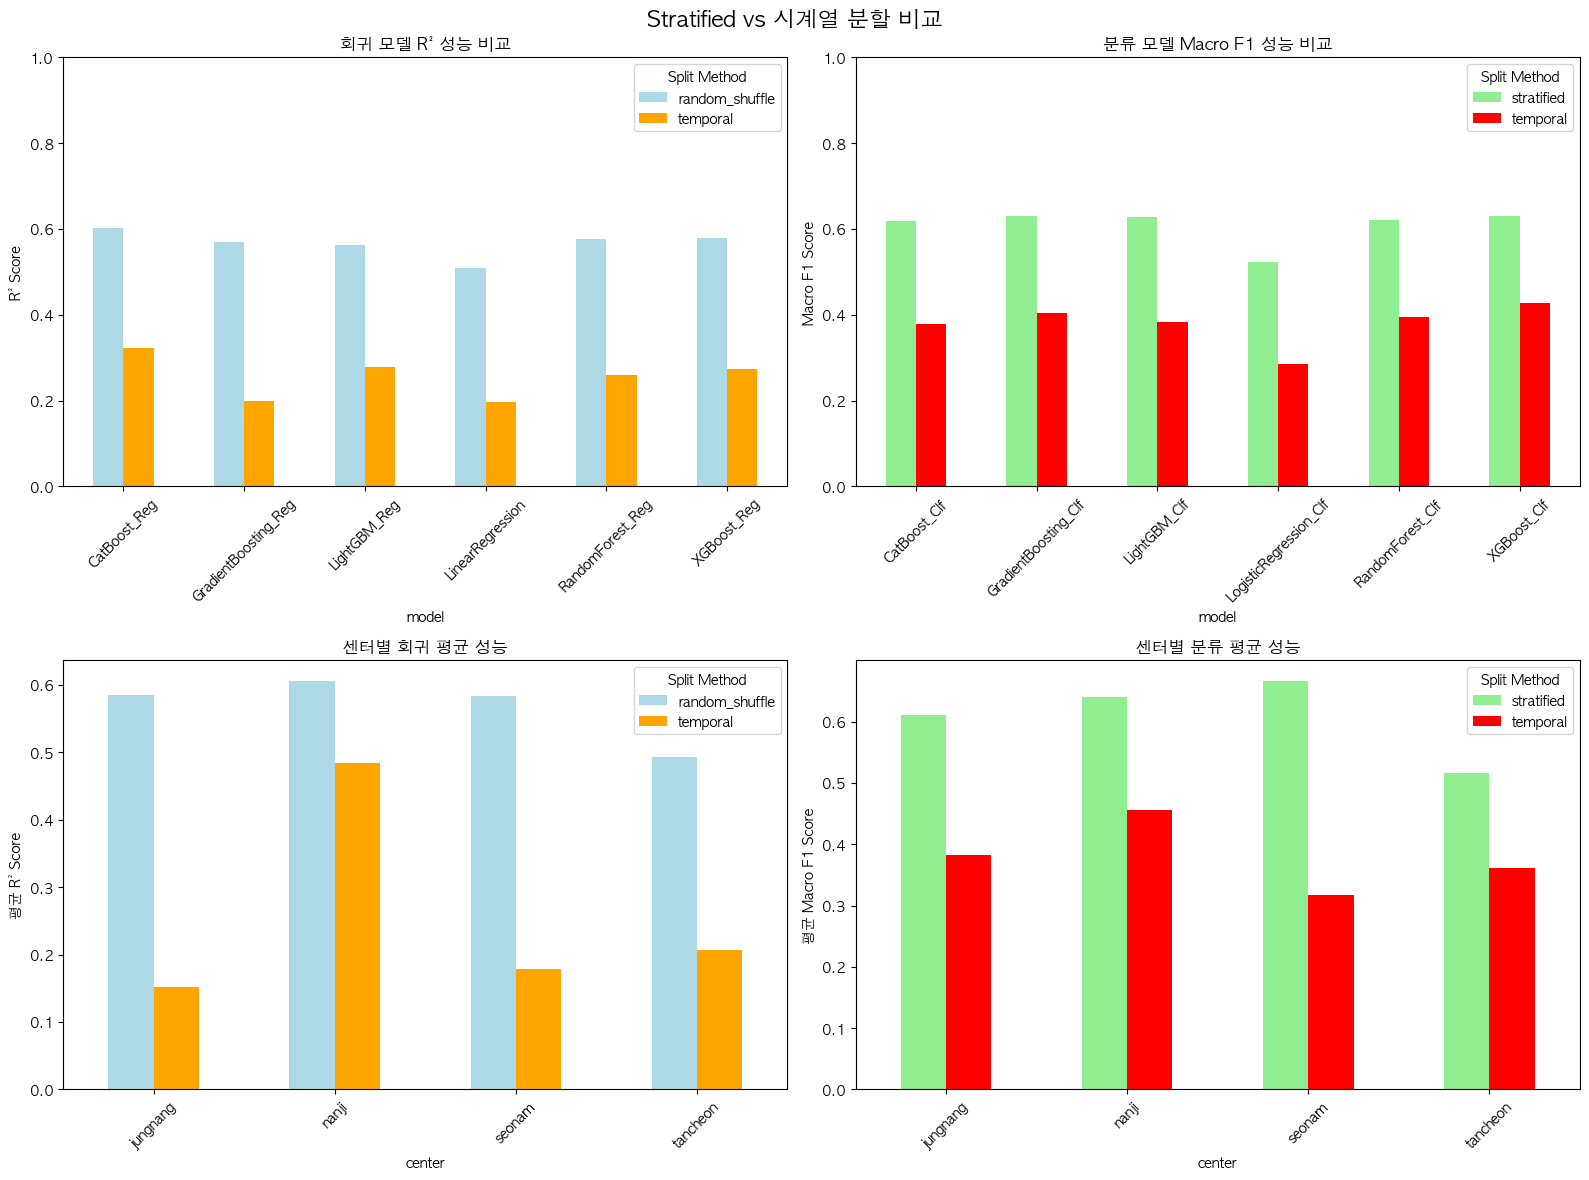

시각화 저장: ../data/results/visualizations/stratified_comparison_plots_20250826_112418.png


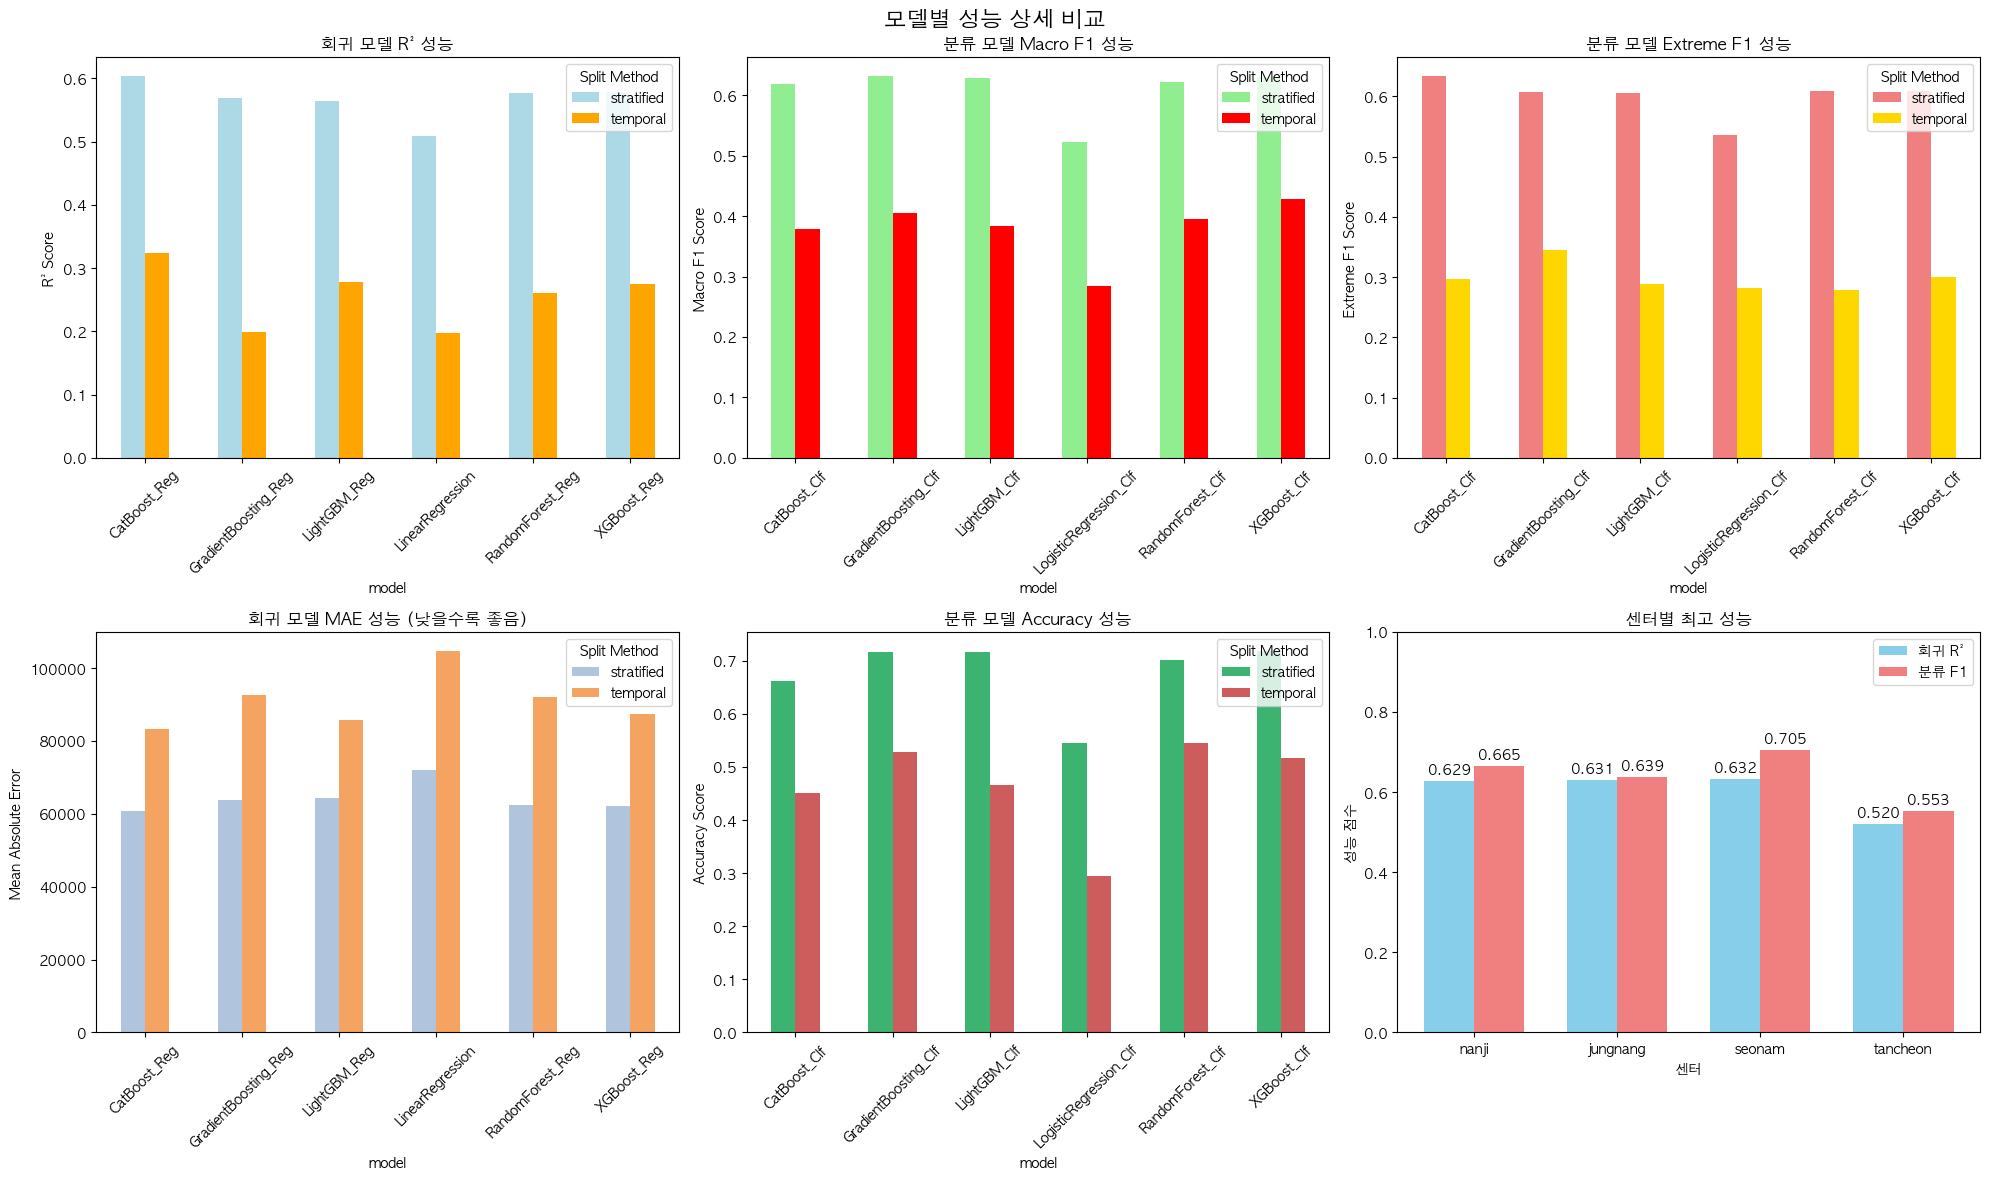

시각화 저장: ../data/results/visualizations/model_performance_comparison_20250826_112419.png

=== 최고 성능 모델 상세 분석 ===

최고 회귀 성능: seonam - CatBoost_Reg (stratified) R²=0.632

모델 재학습 및 분석: seonam - CatBoost_Reg

--- CatBoost_Reg 상세 분석 ---
Top 10 중요 피처:
   feature  importance
일_일강수량(mm)    9.146434
 강수량_7일_누적    6.458956
 강수량_1일_누적    5.586770
       세탁업    5.504623
      목욕장업    5.249139
    체력단련장업    4.094364
        하천    3.741915
   평균습도(%)    3.662000
   강수량_1일전    3.404512
       일교차    3.376256

=== 저장 완료 ===
저장됨: ../data/results/feature_importance/importance_seonam_CatBoost_Reg_20250826_112421.csv


<Figure size 1000x800 with 0 Axes>

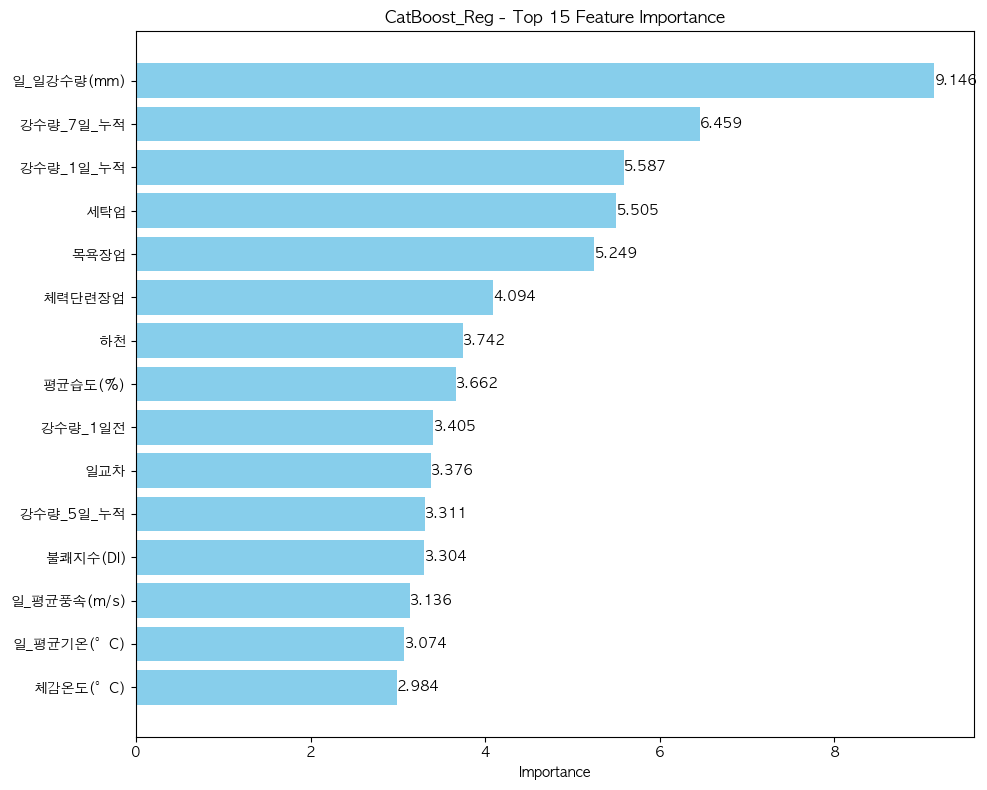

시각화 저장: ../data/results/visualizations/feature_importance_seonam_CatBoost_Reg_20250826_112421.png

=== 저장 완료 ===
저장됨: ../data/results/shap_analysis/shap_values_seonam_CatBoost_Reg_20250826_112421.pkl
저장됨: ../data/results/shap_analysis/shap_summary_seonam_CatBoost_Reg_20250826_112421.csv


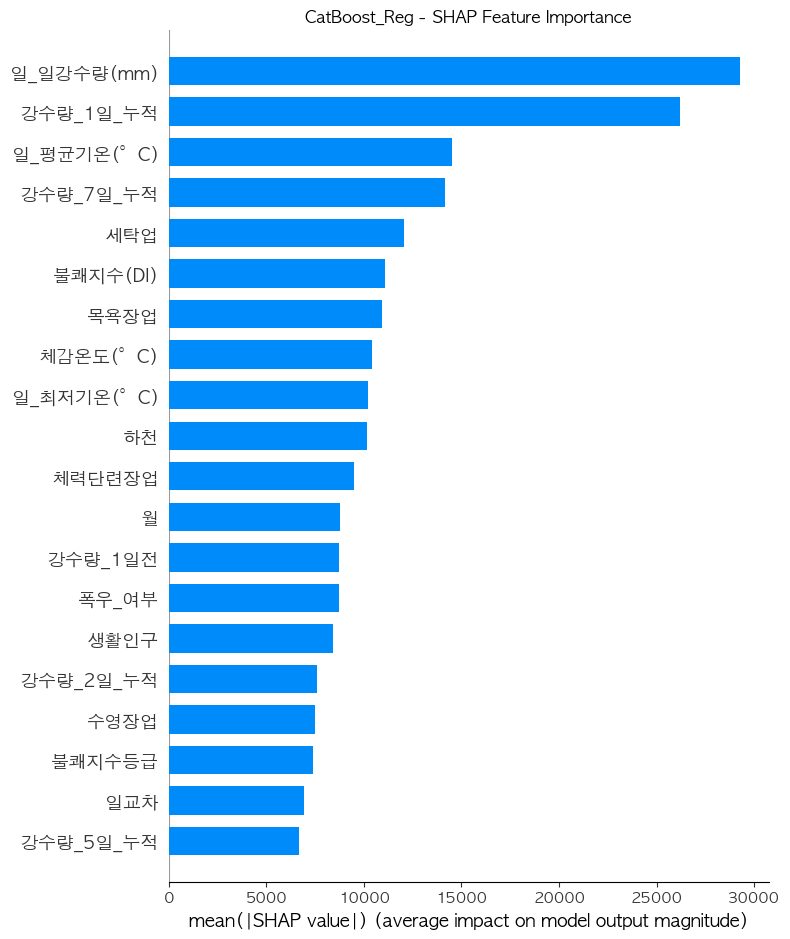

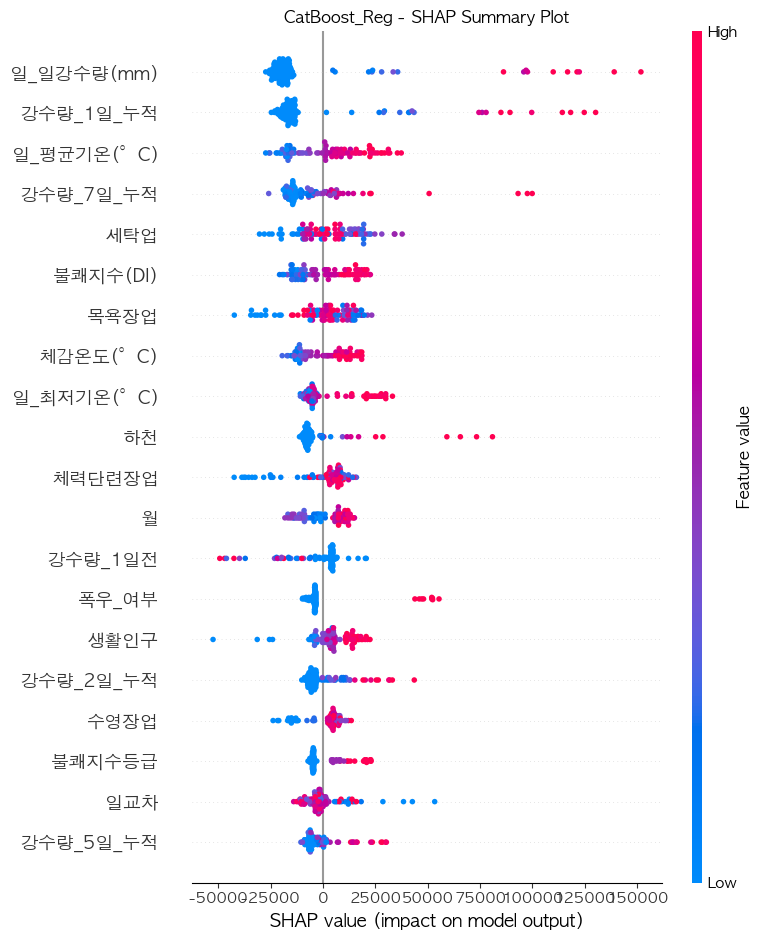

시각화 저장: ../data/results/visualizations/shap_seonam_CatBoost_Reg_20250826_112421.png

최고 분류 성능: seonam - GradientBoosting_Clf (stratified) F1=0.705

모델 재학습 및 분석: seonam - GradientBoosting_Clf

--- GradientBoosting_Clf 상세 분석 ---
Top 10 중요 피처:
   feature  importance
       세탁업    0.173763
    체력단련장업    0.088739
 강수량_7일_누적    0.069484
        하천    0.055266
 강수량_1일_누적    0.054156
일_일강수량(mm)    0.051667
  체감온도(°C)    0.051003
일_최저기온(°C)    0.045501
 강수량_5일_누적    0.043873
      생활인구    0.042652

=== 저장 완료 ===
저장됨: ../data/results/feature_importance/importance_seonam_GradientBoosting_Clf_20250826_112428.csv


<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

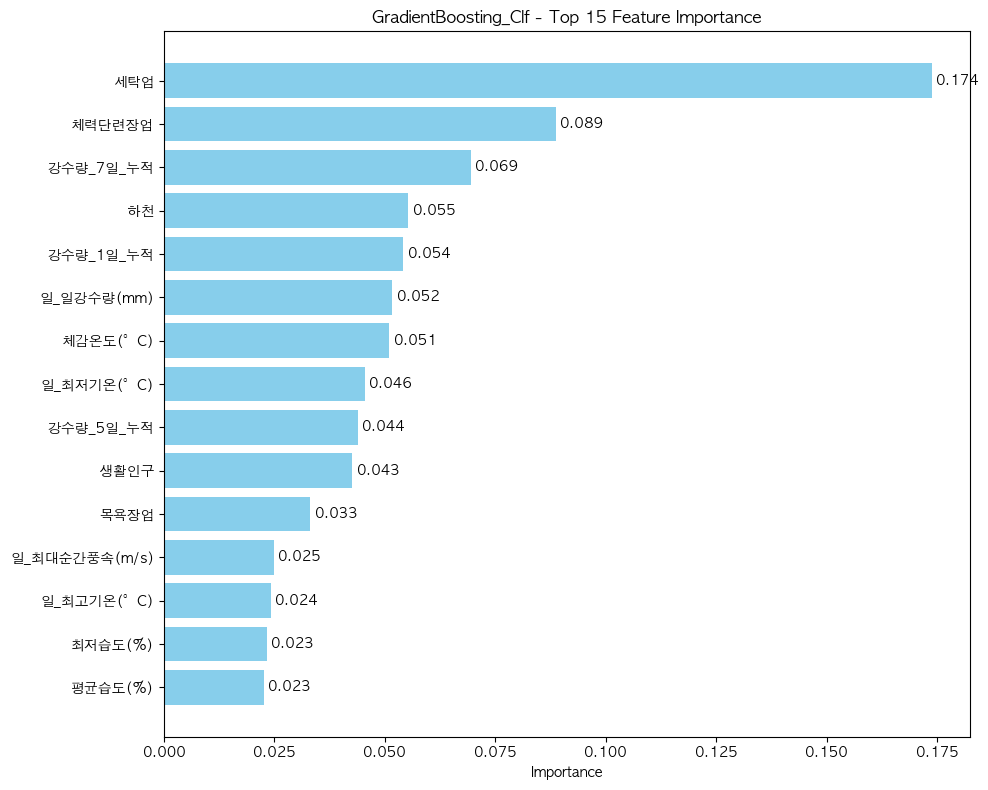

시각화 저장: ../data/results/visualizations/feature_importance_seonam_GradientBoosting_Clf_20250826_112429.png
SHAP 분석 실패 (GradientBoosting_Clf): GradientBoostingClassifier is only supported for binary classification right now!

=== 저장 완료 ===
저장됨: ../data/results/stratified_comparison/stratified_comparison_20250826_112429.csv
저장됨: ../data/results/stratified_comparison/stratified_summary_20250826_112429.csv
저장됨: ../data/results/stratified_comparison/stratified_best_models_20250826_112429.csv

=== 저장 완료 ===
저장됨: ../data/results/model_performance/performance_20250826_112429.csv

=== 실험 완료 ===
총 96개 실험 중 96개 성공
결과 저장 위치: ../data/results/


In [81]:
# 전체 실험 실행
results_df = run_stratified_comparison()

In [83]:
# 코드 수정
# 근데 코드를 수정해야함

In [84]:
best_model_stratified = pd.read_csv('../data/results/stratified_comparison/stratified_summary_20250826_110215.csv', encoding='utf-8')
best_model_stratified

FileNotFoundError: [Errno 2] No such file or directory: '../data/results/stratified_comparison/stratified_summary_20250826_110215.csv'